<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/notebooks/phase2/tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 2769, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 2769 (delta 112), reused 80 (delta 41), pack-reused 2588 (from 2)
Receiving objects: 100% (2769/2769), 47.02 MiB | 15.31 MiB/s, done.
Resolving deltas: 100% (1920/1920), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import json
import gc

from kltn import *
from kltn.datasets.get_datasets import  convert_to_2D_dataset, get_datasets_2d, get_liver_mask_bbox
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import  trainer_stage2
from kltn.utils.metrics import  DiceMetric, TverskyLossWSigmoid
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results_stage_2
from kltn.datasets.prepare_data import prepare_dataset_LiTS, merge_lits_and_msd

In [4]:
drive.flush_and_unmount()
drive.mount("/content/gdrive")

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/gdrive


In [5]:
LOGGER = init_logger(config["log_path"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
!tar -czvf /content/2D_dataset.tar.gz -C /content/gdrive/MyDrive/KLTN/datasets 2D_dataset && mkdir -p /content/2D_dataset && tar -xzvf /content/2D_dataset.tar.gz -C /content/2D_dataset --strip-components=1

Streaming output truncated to the last 5000 lines.
tar: 2D_dataset/msd_patient_109_slice_528.npz: file changed as we read it
2D_dataset/msd_patient_109_slice_538.npz
tar: 2D_dataset/msd_patient_109_slice_538.npz: file changed as we read it
2D_dataset/msd_patient_109_slice_536.npz
tar: 2D_dataset/msd_patient_109_slice_536.npz: file changed as we read it
2D_dataset/msd_patient_109_slice_534.npz
tar: 2D_dataset/msd_patient_109_slice_534.npz: file changed as we read it
2D_dataset/msd_patient_109_slice_532.npz
tar: 2D_dataset/msd_patient_109_slice_532.npz: file changed as we read it
2D_dataset/msd_patient_109_slice_546.npz
tar: 2D_dataset/msd_patient_109_slice_546.npz: file changed as we read it
2D_dataset/msd_patient_109_slice_542.npz
tar: 2D_dataset/msd_patient_109_slice_542.npz: file changed as we read it
2D_dataset/msd_patient_109_slice_540.npz
tar: 2D_dataset/msd_patient_109_slice_540.npz: file changed as we read it
2D_dataset/msd_patient_109_slice_544.npz
tar: 2D_dataset/msd_patient_1

In [18]:
# move tar file from colab to drive
!cp ./2D_dataset.tar.gz /content/gdrive/MyDrive/KLTN/datasets/

In [ ]:
# move tar file from drive to colab and decompression
!cp /content/gdrive/MyDrive/KLTN/datasets/2D_dataset.tar.gz /content/2D_dataset.tar.gz && tar -xzvf /content/2D_dataset.tar.gz -C /content/2D_dataset --strip-components=1

## download data

In [ ]:
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.00% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 1) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
0.00% complete (down: 0.0 kB/s up: 0.1 kB/s peers: 3) downloading LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
1.51% complete (down: 18490.3 kB/s up: 527.1 kB/s peers: 8) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreach

In [ ]:
!wget https://msd-for-monai.s3-us-west-2.amazonaws.com/Task03_Liver.tar

--2025-05-16 14:18:12--  https://msd-for-monai.s3-us-west-2.amazonaws.com/Task03_Liver.tar
Resolving msd-for-monai.s3-us-west-2.amazonaws.com (msd-for-monai.s3-us-west-2.amazonaws.com)... 3.5.76.247, 3.5.82.204, 52.92.197.98, ...
Connecting to msd-for-monai.s3-us-west-2.amazonaws.com (msd-for-monai.s3-us-west-2.amazonaws.com)|3.5.76.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28925891584 (27G) [application/x-tar]
Saving to: ‘Task03_Liver.tar’

Task03_Liver.tar    100%[===================>]  26.94G  20.5MB/s    in 33m 51s 

2025-05-16 14:52:04 (13.6 MB/s) - ‘Task03_Liver.tar’ saved [28925891584/28925891584]



In [ ]:
!tar -xf ./Task03_Liver.tar && rm -rf ./Task03_Liver.tar && rm -rf ./Task03_Liver/imagesTs

In [ ]:
merge_lits_and_msd(
    config["source_folder_lits"],
    config["source_folder_msd"],
    config["source_folder_custom_dataset"],
)

Copied /content/LITS17/segmentation-13.nii to /content/custom_datasets/lits-segmentation-13.nii
Copied /content/LITS17/segmentation-105.nii to /content/custom_datasets/lits-segmentation-105.nii
Copied /content/LITS17/volume-116.nii to /content/custom_datasets/lits-volume-116.nii
Copied /content/LITS17/volume-3.nii to /content/custom_datasets/lits-volume-3.nii
Copied /content/LITS17/volume-87.nii to /content/custom_datasets/lits-volume-87.nii
Copied /content/LITS17/volume-13.nii to /content/custom_datasets/lits-volume-13.nii
Copied /content/LITS17/volume-25.nii to /content/custom_datasets/lits-volume-25.nii
Copied /content/LITS17/segmentation-83.nii to /content/custom_datasets/lits-segmentation-83.nii
Copied /content/LITS17/segmentation-53.nii to /content/custom_datasets/lits-segmentation-53.nii
Copied /content/LITS17/segmentation-62.nii to /content/custom_datasets/lits-segmentation-62.nii
Copied /content/LITS17/segmentation-69.nii to /content/custom_datasets/lits-segmentation-69.nii
Co

## Model

In [ ]:
weight_path = "/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver_1.pth"
model_stage_1 = ModelFactory.get_model("unet3d_resnextcot",in_channels=1, n_classes=1, n_channels=16).to(device)
model_stage_1.load_state_dict(torch.load(weight_path, map_location=device))

<All keys matched successfully>

In [9]:
# model = ModelFactory.get_model("unet2d_resnextcot",in_channels=3, n_classes=1, n_channels=32).to(device)
model = ModelFactory.get_model("unet2d_resnextcot",in_channels=5, n_classes=1, n_channels=32).to(device) # use this when 5 slide 3d image

## Prepare Dataset 2.5D

In [ ]:
liver_masks_bbox = get_liver_mask_bbox(source=config["source_folder_custom_dataset"], model_stage_1=model_stage_1, device=device)

In [ ]:
import json
path_save_result = f"/content/gdrive/MyDrive/KLTN/bbox.json"


sources, patient_ids, bboxs = liver_masks_bbox
results = [
    {
        "source": src,
        "patient_id": int(pid),
        "bbox": [int(x) for x in bbox]
    }
    for src, pid, bbox in zip(sources, patient_ids, bboxs)
]
with open(path_save_result, "w") as f:
    json.dump(results, f, indent=4)

In [ ]:
import json

path_save_result = f"/content/gdrive/MyDrive/KLTN/bbox.json"
def load_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

liver_masks_bbox = load_json(path_save_result)


In [ ]:
# convert_to_2D_dataset(source=config["source_folder_lits"], bbox=liver_masks_bbox, slides=3, save_dir=config["path_save_dataset_2D"]) # 3 slide of 3d and stride 2
convert_to_2D_dataset(source=config["source_folder_custom_dataset"], bbox=liver_masks_bbox, slides=5, stride=2, save_dir=config["path_save_dataset_2D"]) # 5 slide of 3d and stride 2

Patient 96 processed.
Patient 53 processed.
Patient 32 processed.
Patient 129 processed.
Patient 125 processed.
Patient 81 processed.
Patient 98 processed.
Patient 118 processed.
Patient 119 processed.
Patient 12 processed.
Patient 15 processed.
Patient 112 processed.
Patient 62 processed.
Patient 109 processed.
Patient 9 processed.
Patient 104 processed.
Patient 55 processed.
Patient 81 processed.
Patient 93 processed.
Patient 46 processed.
Patient 5 processed.
Patient 39 processed.
Patient 75 processed.
Patient 90 processed.
Patient 89 processed.
Patient 56 processed.
Patient 13 processed.
Patient 63 processed.
Patient 60 processed.
Patient 102 processed.
Patient 33 processed.
Patient 82 processed.
Patient 116 processed.
Patient 100 processed.
Patient 100 processed.
Patient 58 processed.
Patient 126 processed.
Patient 34 processed.
Patient 22 processed.
Patient 84 processed.
Patient 19 processed.
Patient 24 processed.
Patient 25 processed.
Patient 5 processed.
Patient 15 processed.
P

## Load data

In [23]:
full_train_dataset, val_dataset = get_datasets_2d(source_folder=config["path_save_dataset_2D"], seed=123, fold_number=2, normalizations="minmax")
print(len(full_train_dataset), len(val_dataset))

45010 11252


In [ ]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=4, shuffle=True,
                                           num_workers=1, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False,
                                         pin_memory=True, num_workers=2, prefetch_factor=4)

## Statistic Sample of Datasets

In [ ]:
def count_nonzero_masks(data_loader):
    total_samples = 0
    liver_count = 0
    tumor_count = 0

    liver_list = []  # lưu True/False theo từng mẫu
    tumor_list = []

    for batch in data_loader:
        images = batch["image"]           # [B, C, H, W]
        segs = batch["label"]             # [B, 1, H, W]
        liver_masks = batch["liver_mask"] # [B, 1, H, W]

        B = images.shape[0]
        total_samples += B

        for i in range(B):
            has_liver = liver_masks[i].sum().item() > 0
            has_tumor = segs[i].sum().item() > 0

            liver_list.append(has_liver)
            tumor_list.append(has_tumor)

            if has_liver:
                liver_count += 1
            if has_tumor:
                tumor_count += 1

    liver_percent = liver_count / total_samples * 100
    tumor_percent = tumor_count / total_samples * 100

    print(f"Tổng số mẫu: {total_samples}")
    print(f"Số mẫu có liver mask: {liver_count} ({liver_percent:.2f}%)")
    print(f"Số mẫu có tumor mask: {tumor_count} ({tumor_percent:.2f}%)")

    return {
        "total": total_samples,
        "liver_count": liver_count,
        "tumor_count": tumor_count,
        "liver_percent": liver_percent,
        "tumor_percent": tumor_percent,
    }

In [ ]:
train_stats = count_nonzero_masks(train_loader)

Tổng số mẫu: 45008
Số mẫu có liver mask: 14723 (32.71%)
Số mẫu có tumor mask: 6041 (13.42%)


In [ ]:
train_stats

{'total': 45008,
 'liver_count': 14723,
 'tumor_count': 6041,
 'liver_percent': 32.71196231781017,
 'tumor_percent': 13.422058300746533}

In [ ]:
val_stats = count_nonzero_masks(val_loader)

Tổng số mẫu: 11252
Số mẫu có liver mask: 3693 (32.82%)
Số mẫu có tumor mask: 1541 (13.70%)


In [ ]:
val_stats

{'total': 11252,
 'liver_count': 3693,
 'tumor_count': 1541,
 'liver_percent': 32.82083185211518,
 'tumor_percent': 13.695343050124423}

## Visualize

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import random

def visualize_from_loader(image_tensor, label_tensor, liver_mask):
    """
    Hiển thị 3 ảnh: Volume, Liver Mask, và Liver Mask + Segmentation

    Args:
        image_tensor: Tensor, shape [1, 3, H, W]
        label_tensor: Tensor, shape [ 1, 1, H, W]
        liver_mask: Tensor, shape [1, 1, H, W]
    Notes:
        - Chuyển đổi sang numpy
        - Hiển thị 3 ảnh: volume, liver mask, và liver mask + segmentation
    """

    batch_size = image_tensor.shape[0]
    index = random.randint(0, batch_size - 1)

    # Chuyển đổi sang numpy, nén tensor về dạng [D, H, W]
    image = image_tensor[index].detach().cpu().numpy().squeeze() # shape [3, H, W]
    label = label_tensor[index].detach().cpu().numpy().squeeze() # shape [ H, W]
    liver_mask = liver_mask[index].detach().cpu().numpy().squeeze() # shape [ H, W]


    image_center = image[1]

    # Bảng màu cho mask khối u
    cmap1 = mcolors.ListedColormap(["black", "red"])
    cmap2 = mcolors.ListedColormap(["black", "yellow"])

    overlay = np.zeros((*image_center.shape, 4))  # RGBA (H, W, 4)
    overlay[liver_mask == 1] = (1.0, 1.0, 0.0, 0.6)  # Yellow
    overlay[label == 1] = (1.0, 0.0, 0.0, 0.8)       # Red (overwrite if overlapped)

    # Vẽ hình
    plt.figure(figsize=(18, 9))

    # Ảnh đầu tiên: Volume (Ảnh gốc)
    plt.subplot(1, 2, 1)
    plt.title("Volume (slice center of 2.5D)")
    plt.imshow(image_center, cmap='gray')
    plt.axis("off")

    # Ảnh thứ ba: Liver Mask + Segmentation
    plt.subplot(1, 2, 2)
    plt.title("Mask + Volume")
    plt.imshow(image_center, cmap='gray')
    # plt.imshow(liver_mask, cmap=cmap2, alpha=0.7)
    # plt.imshow(label, cmap=cmap1, alpha=0.8)
    plt.imshow(overlay)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

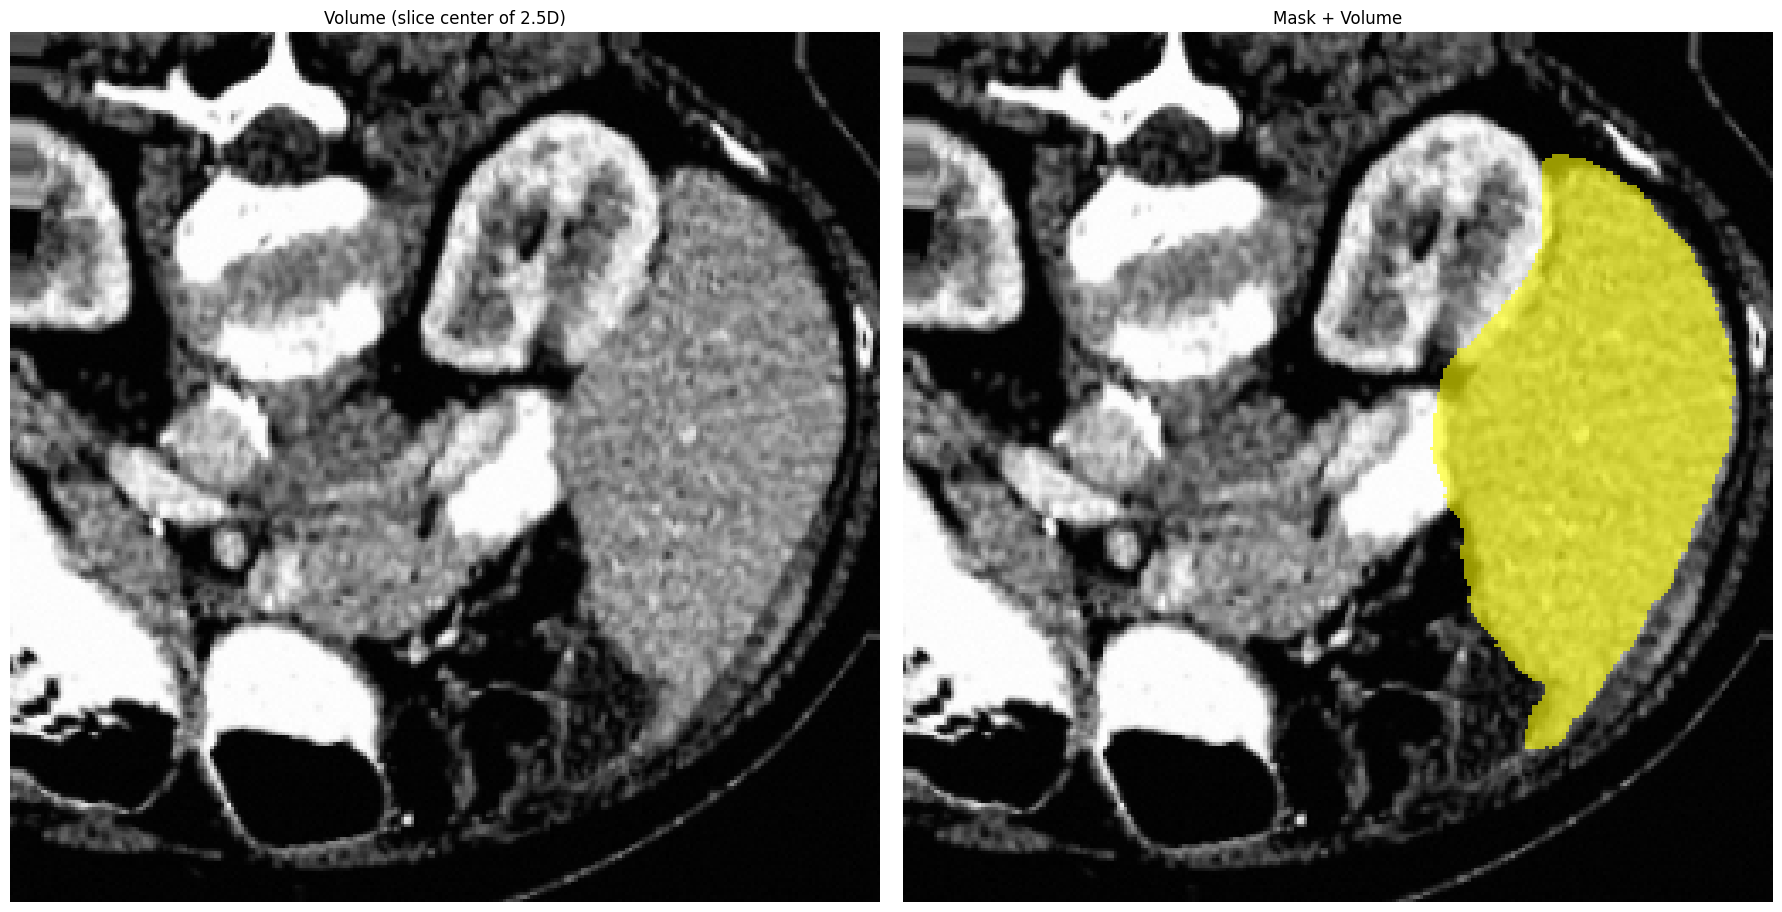

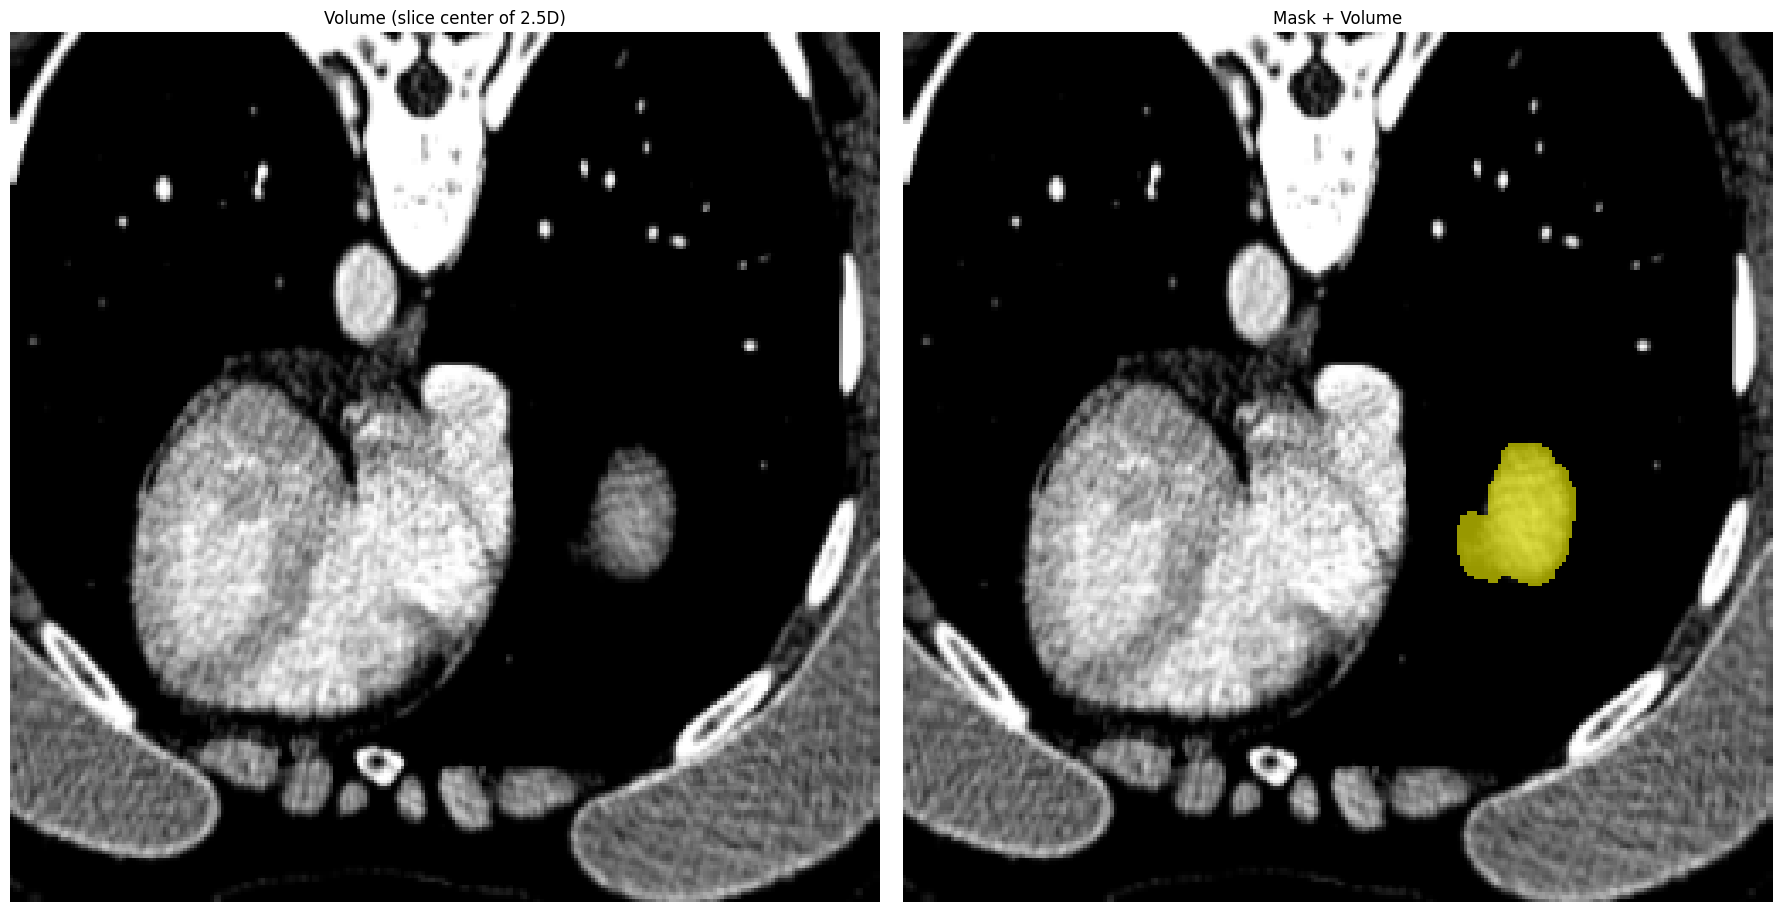

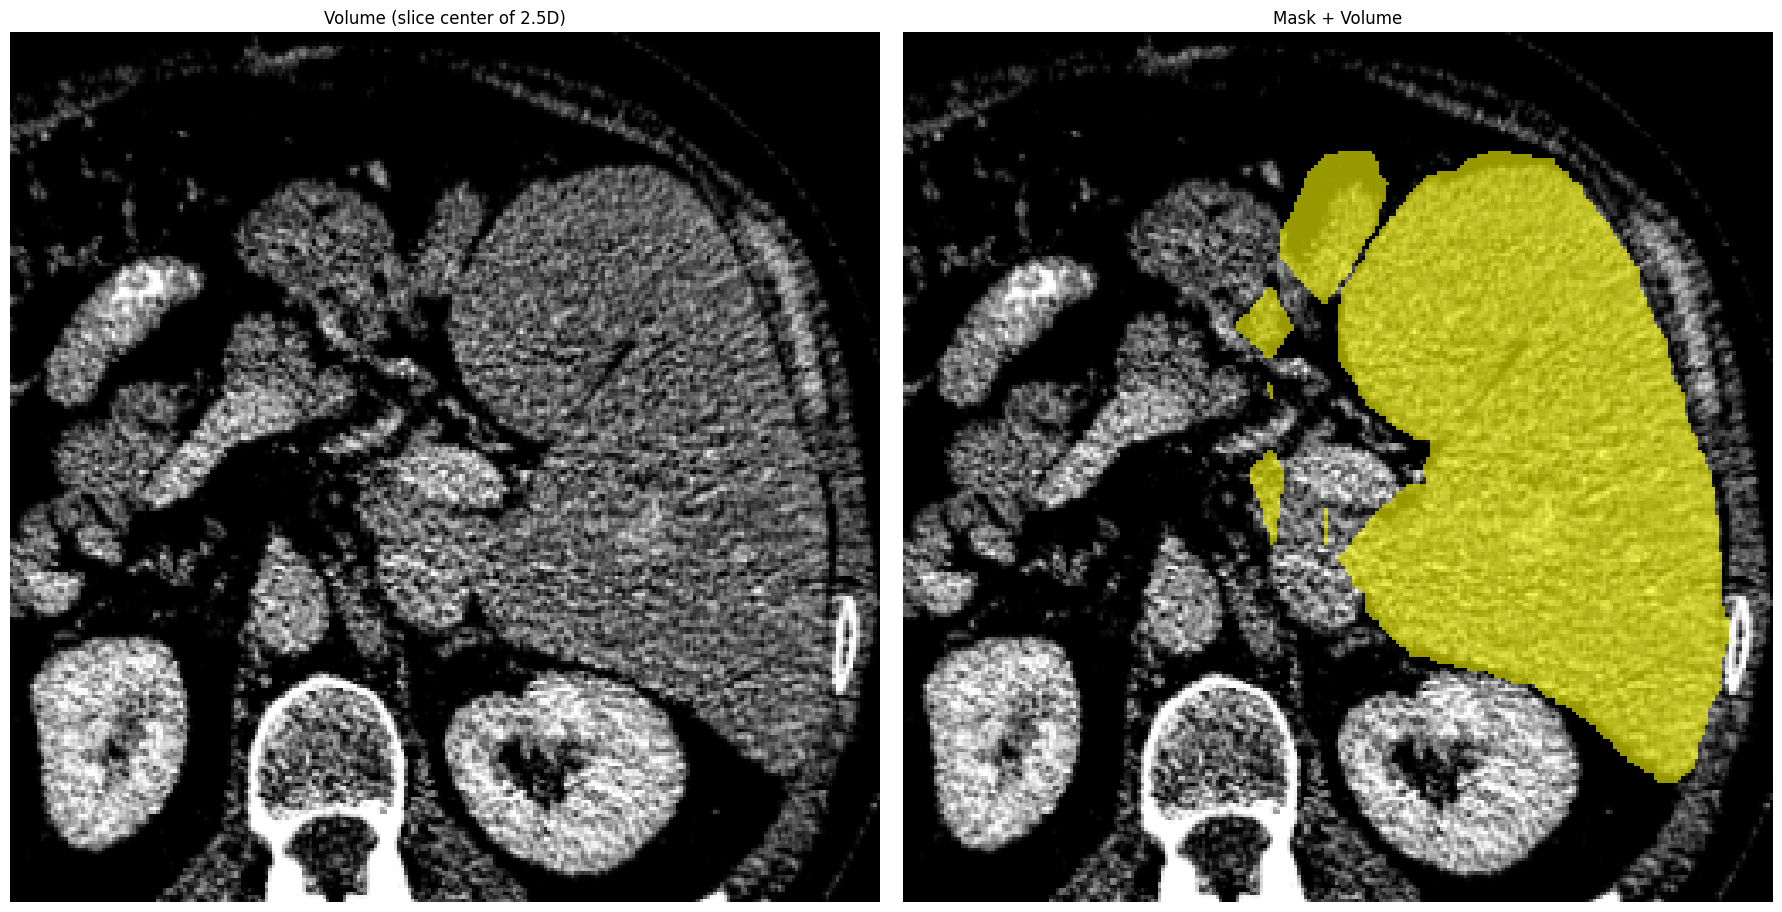

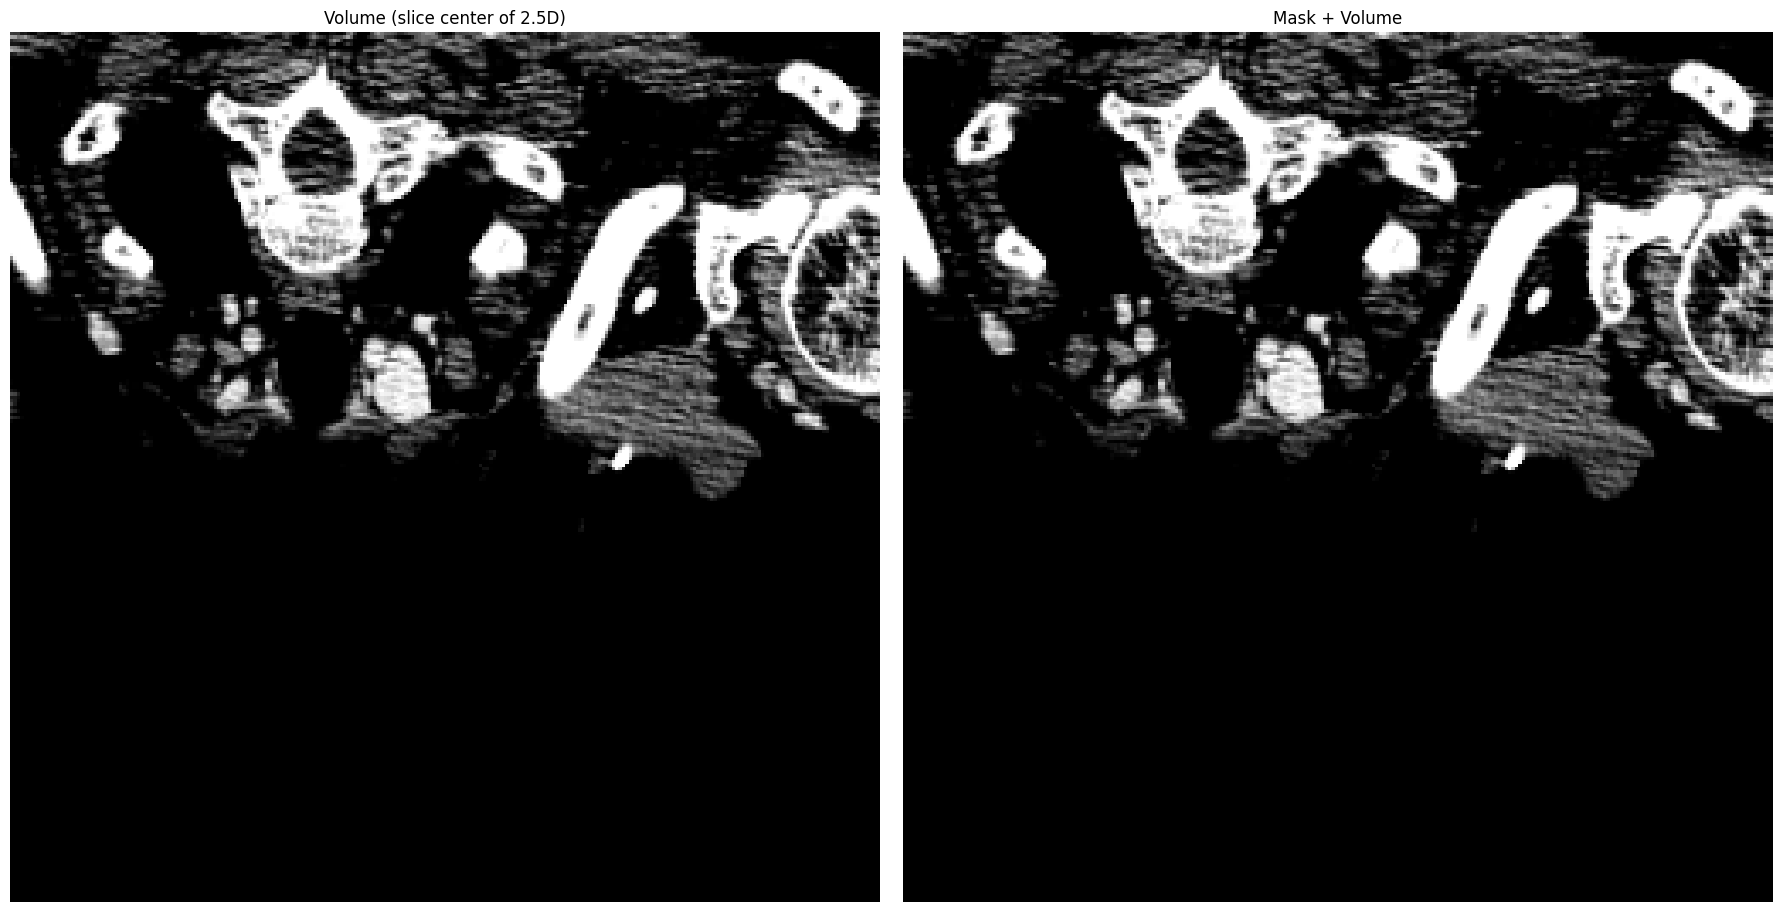

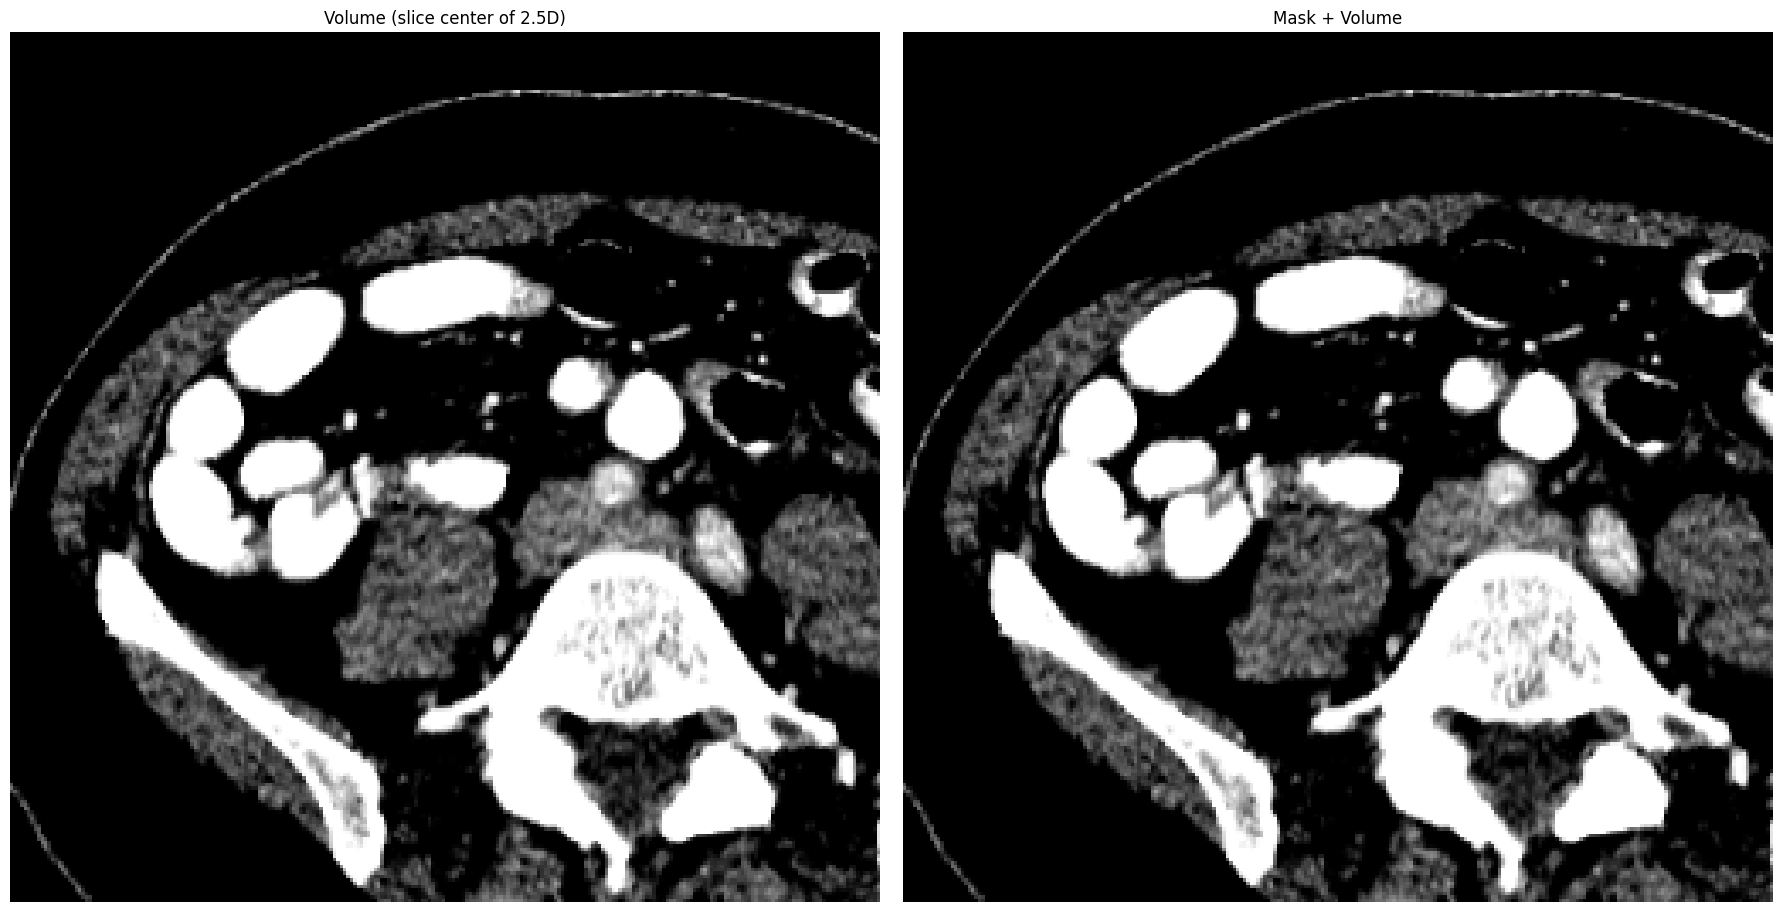

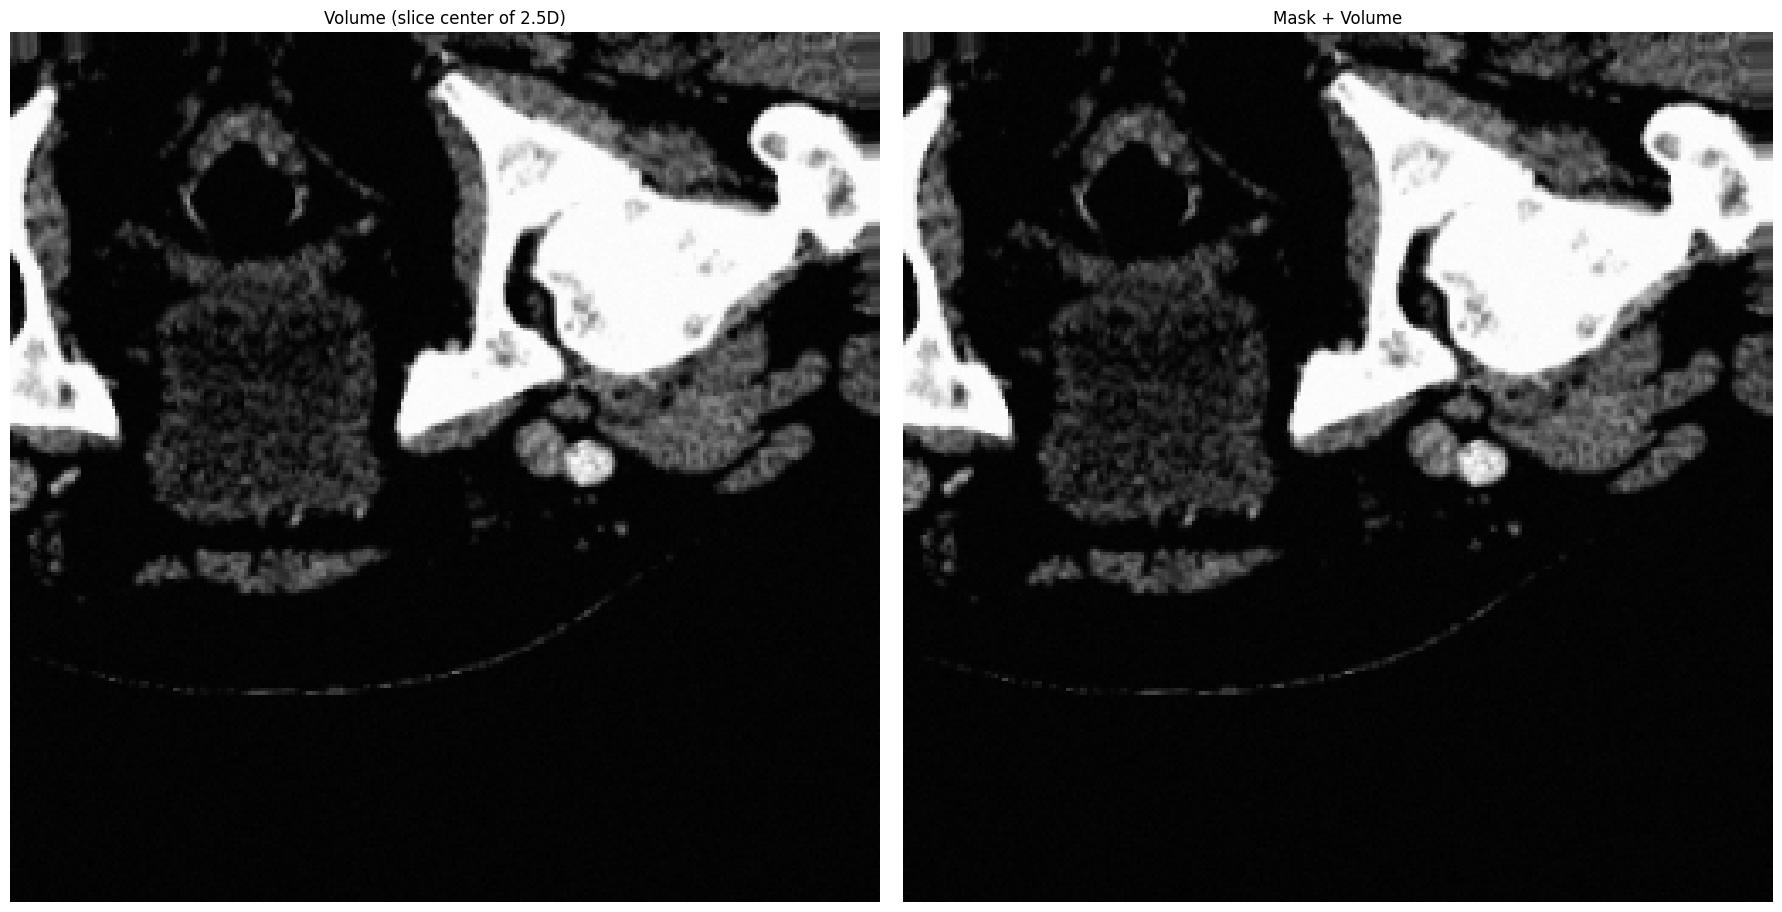

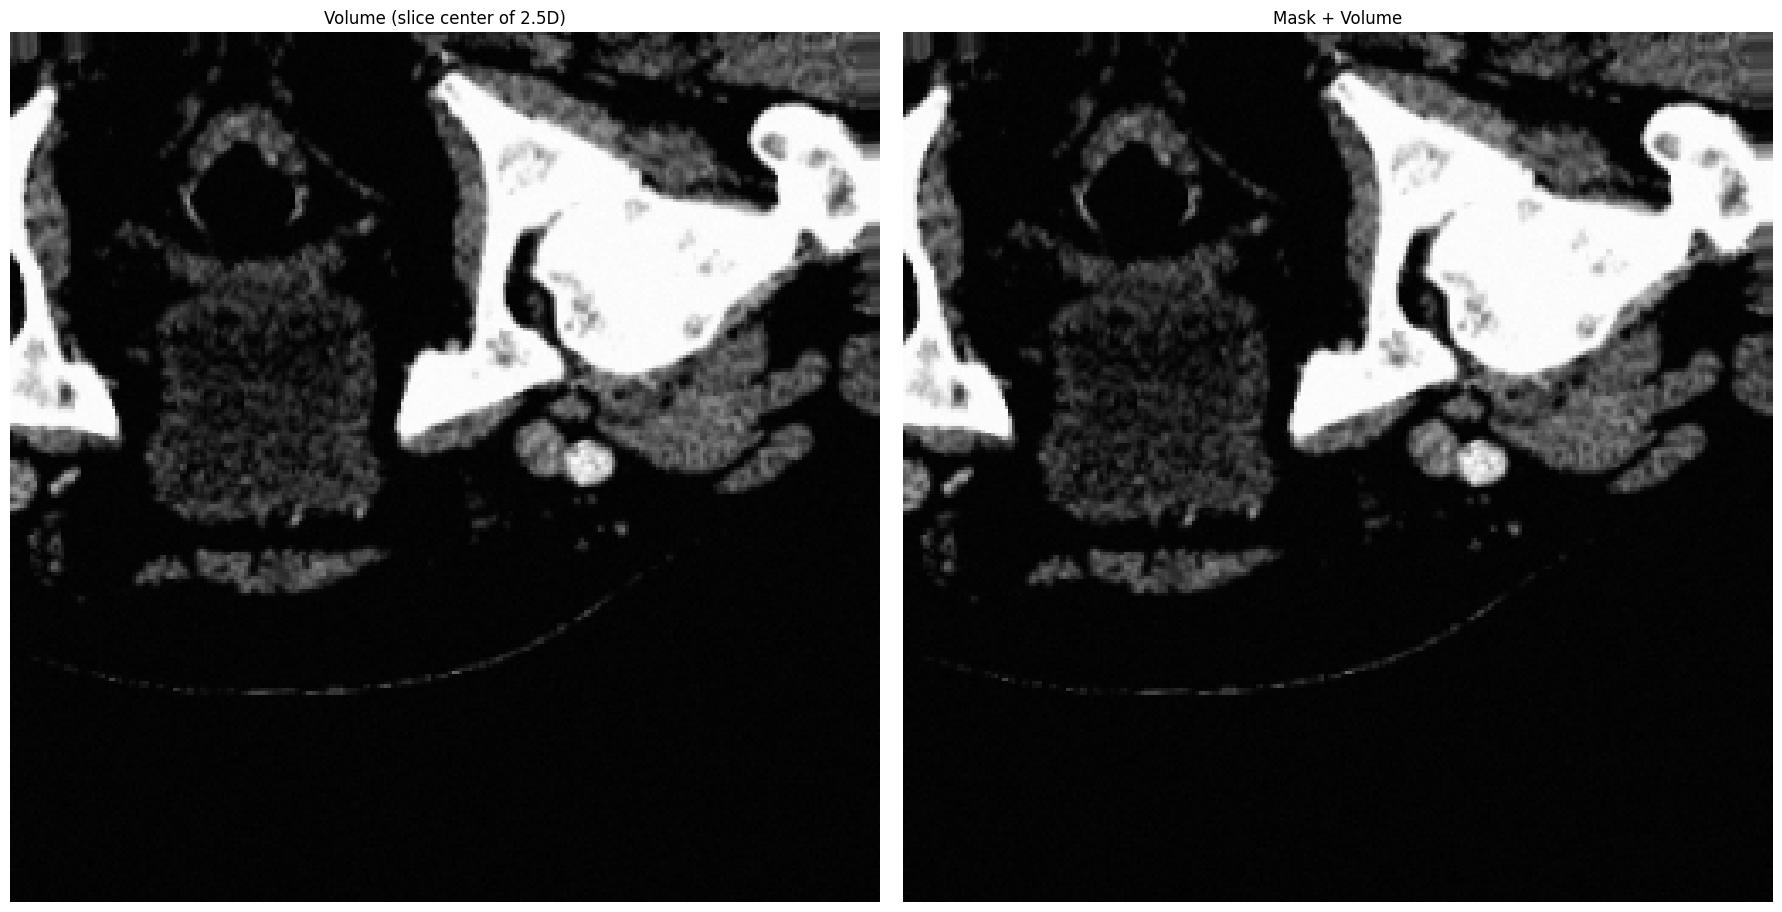

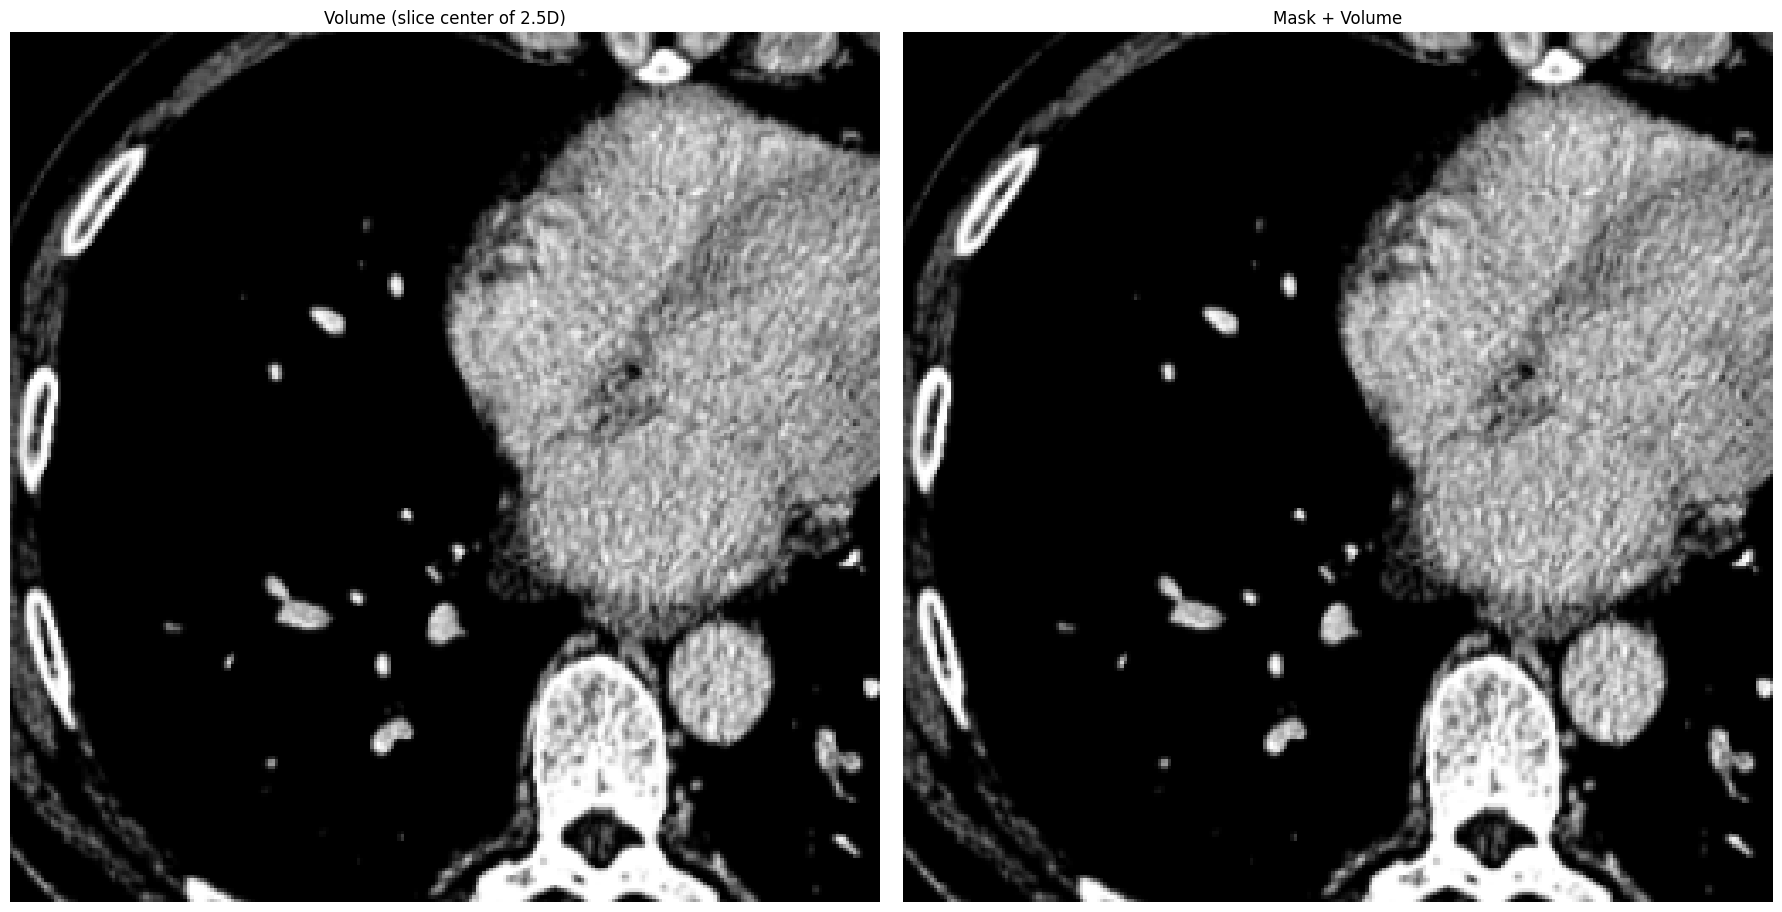

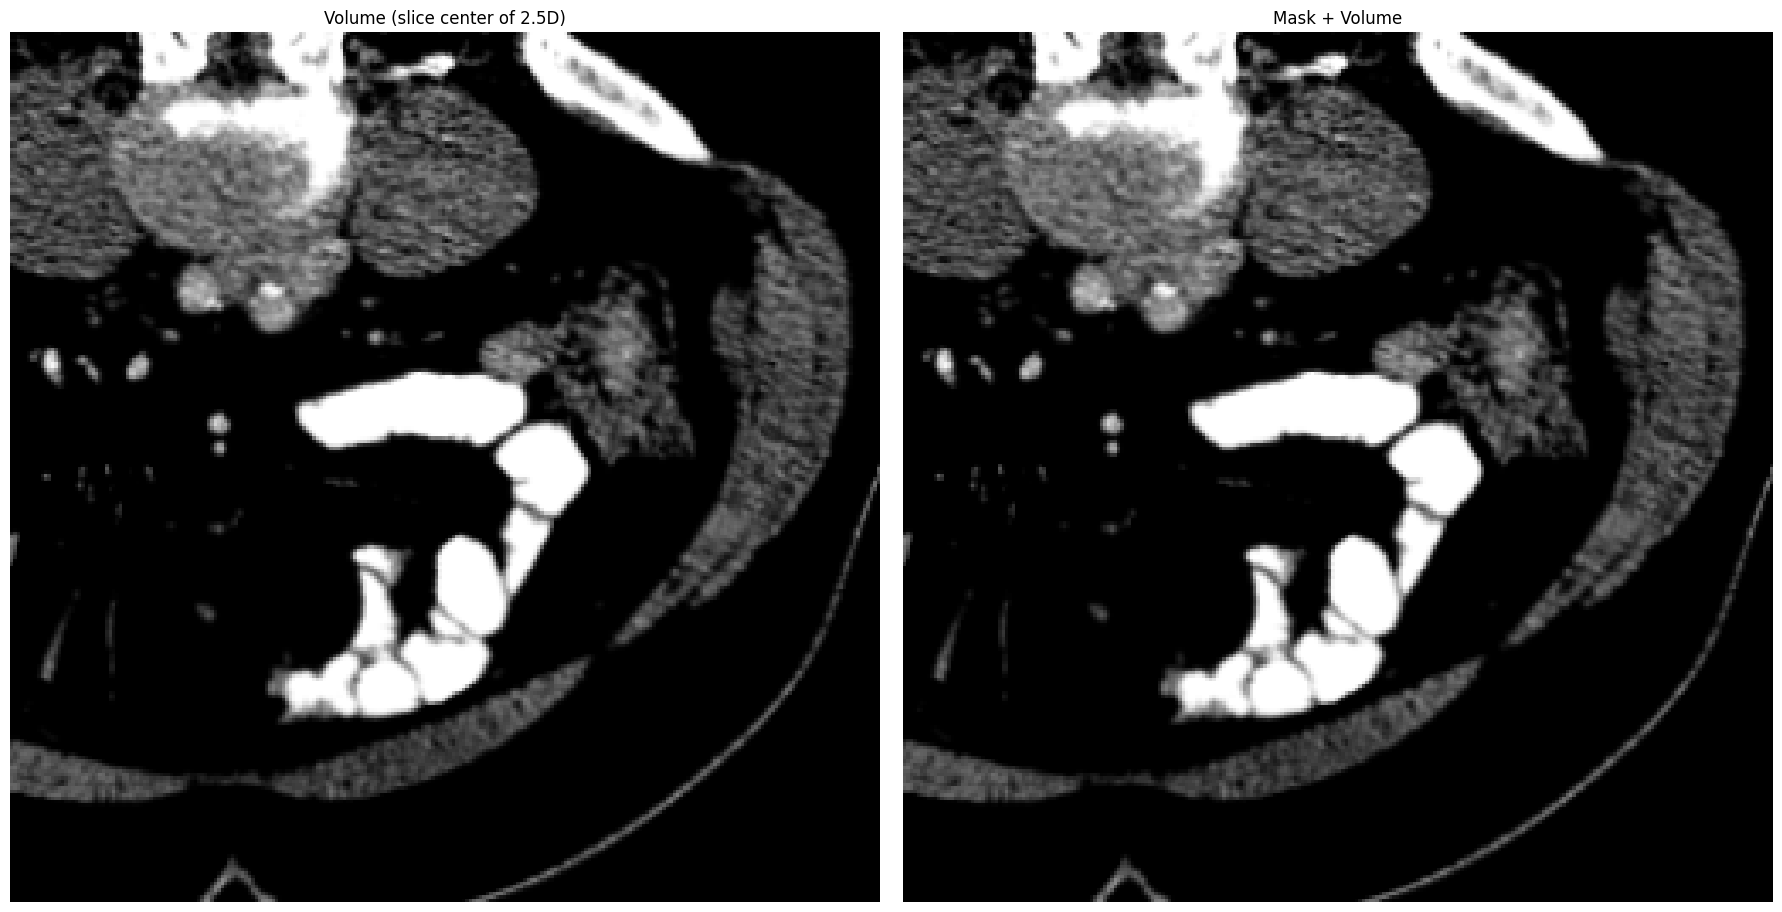

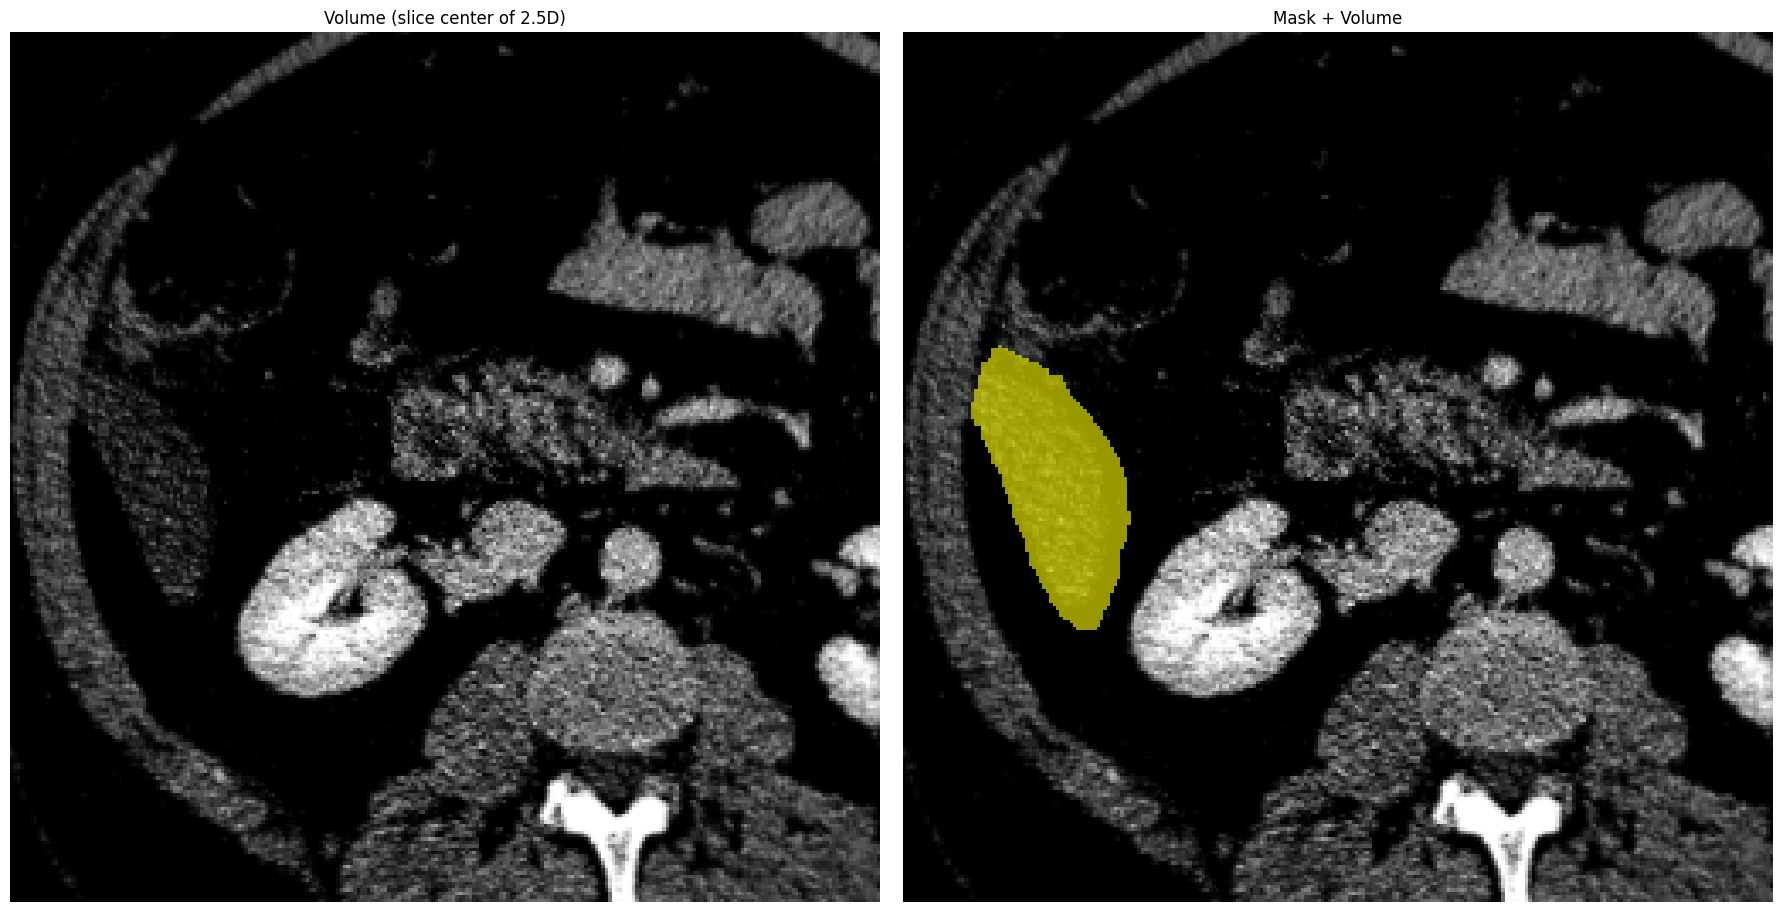

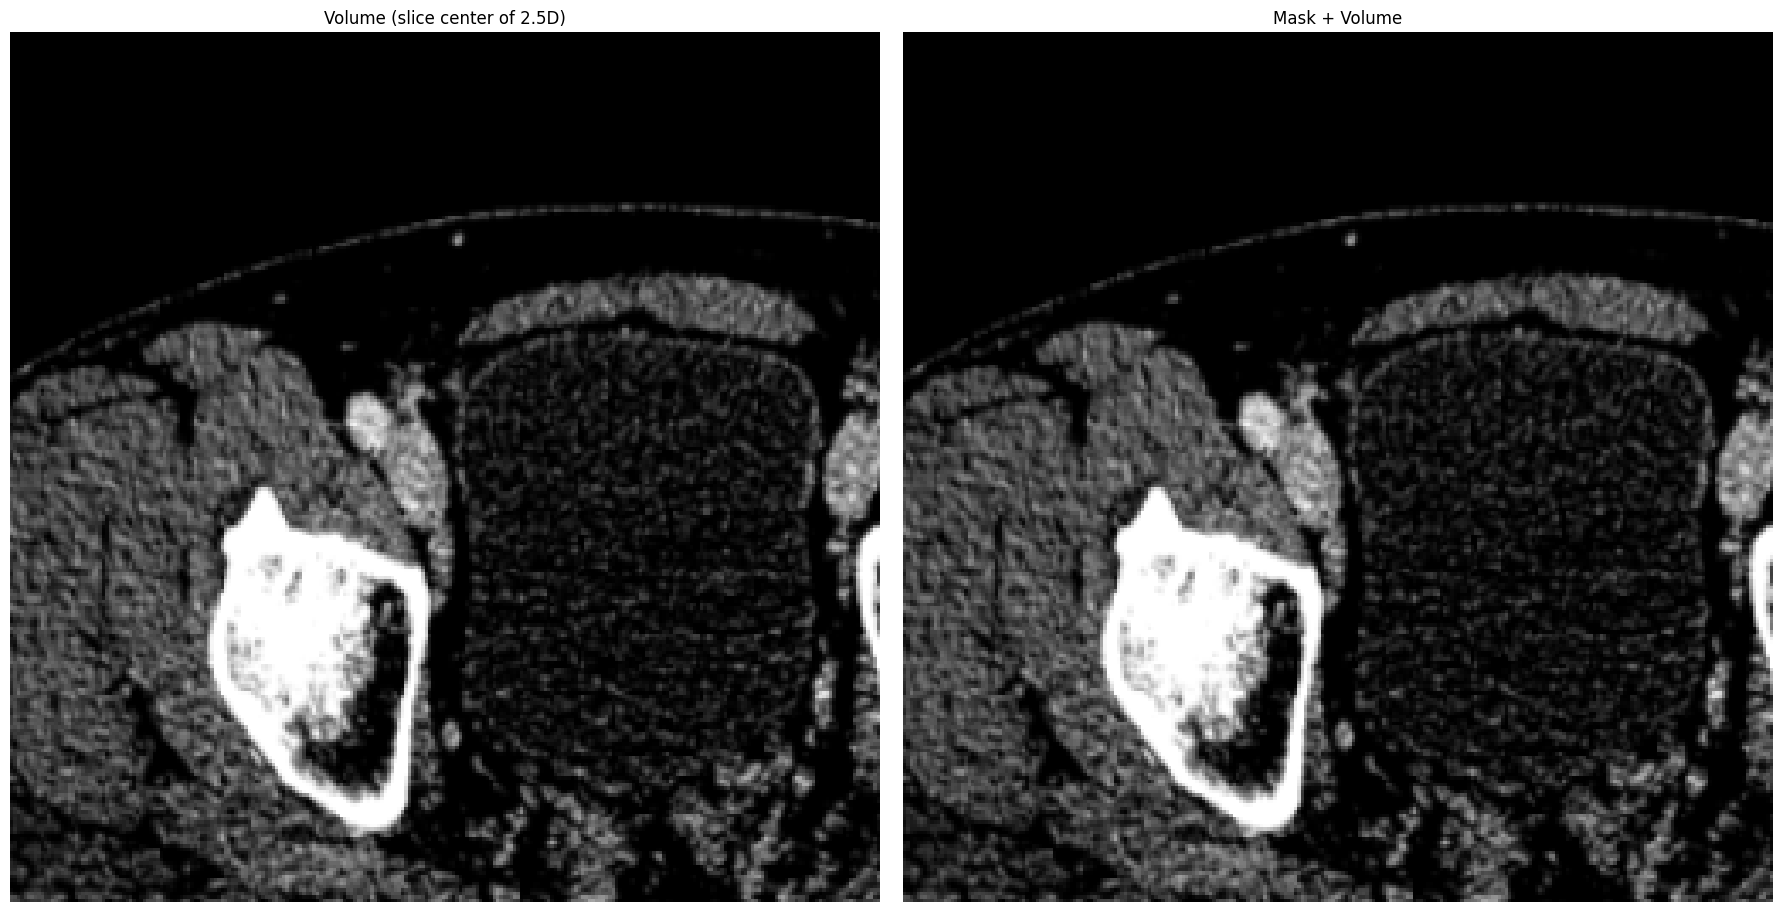

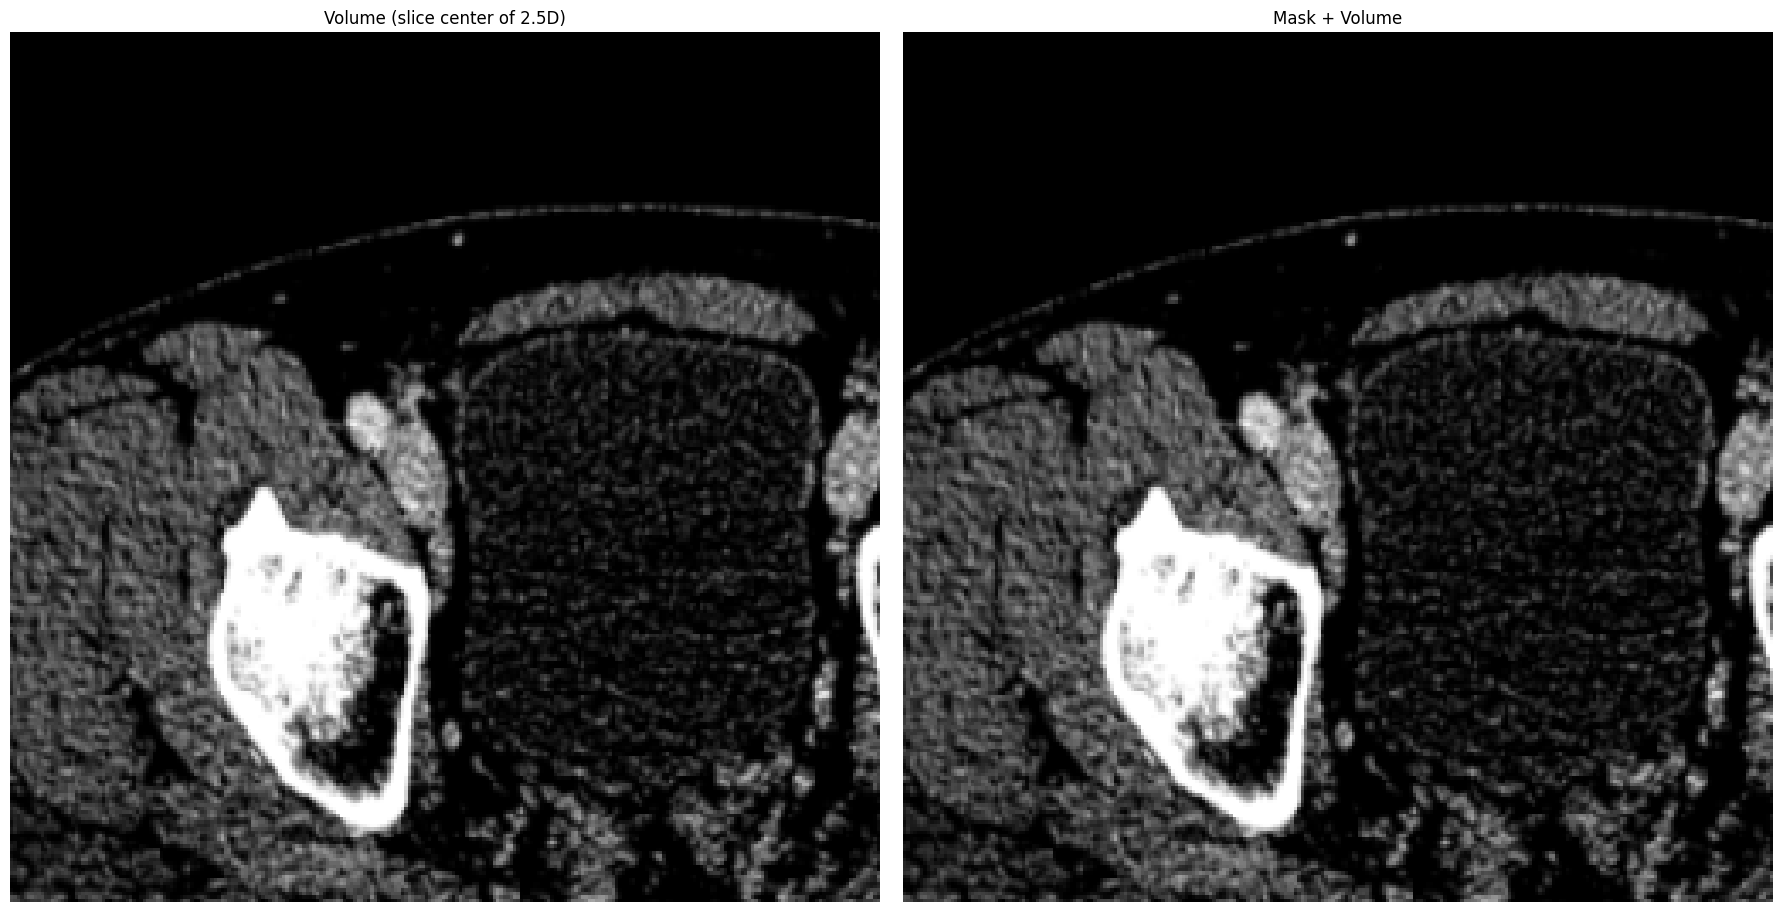

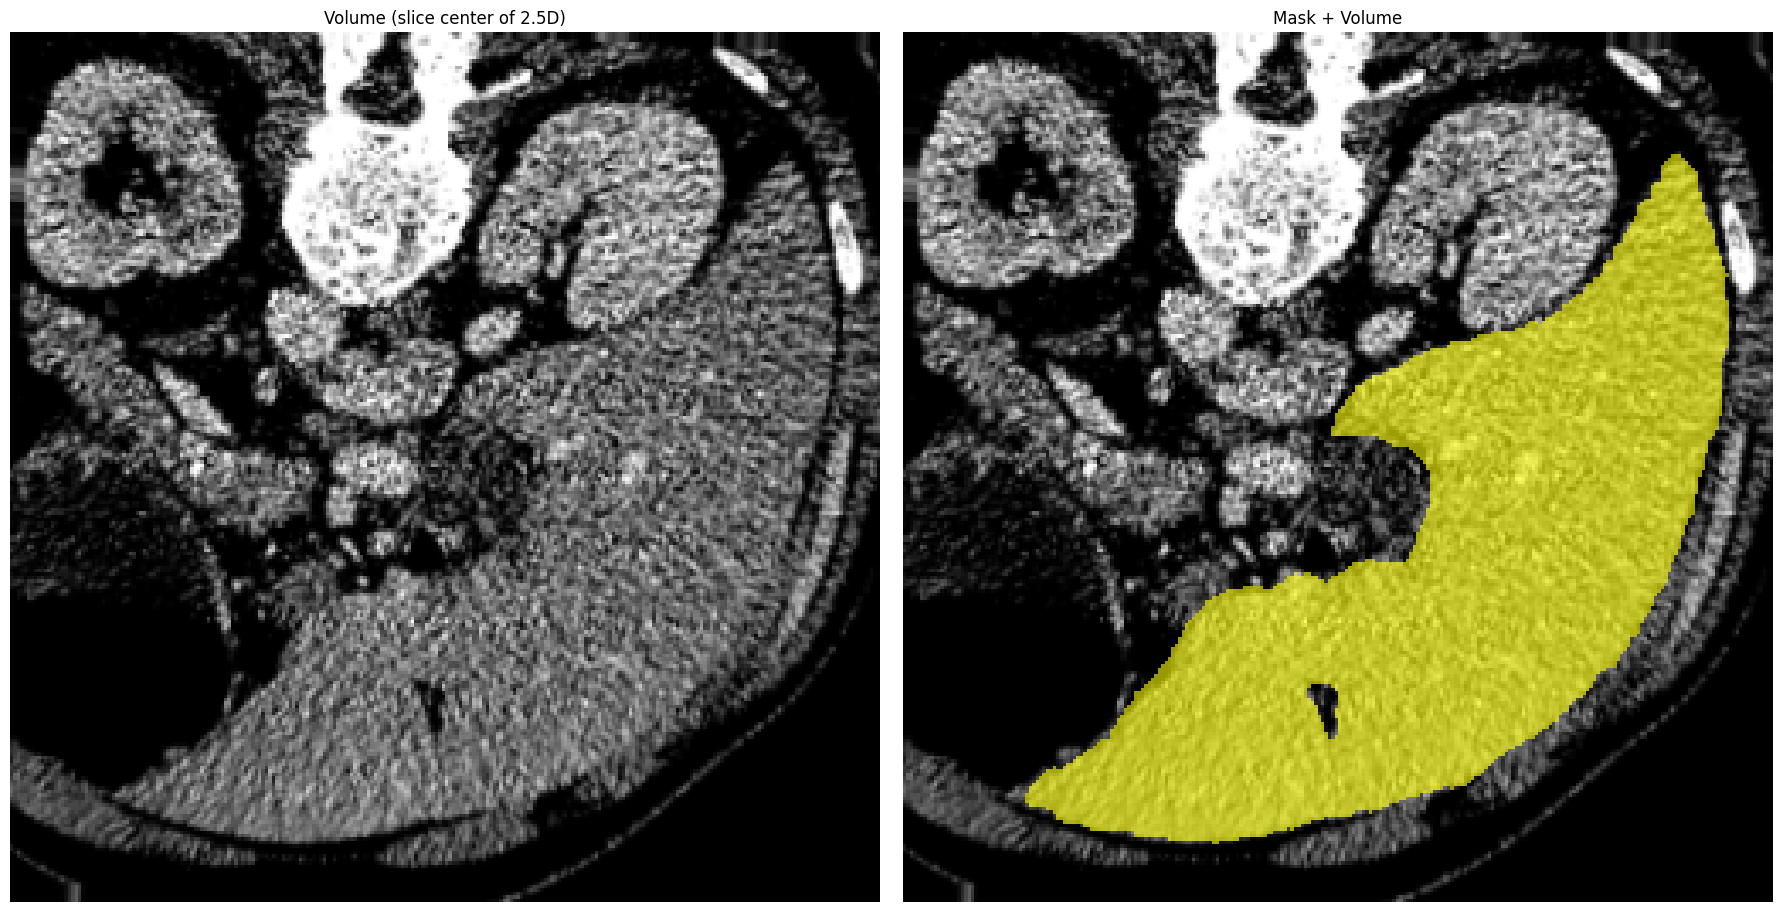

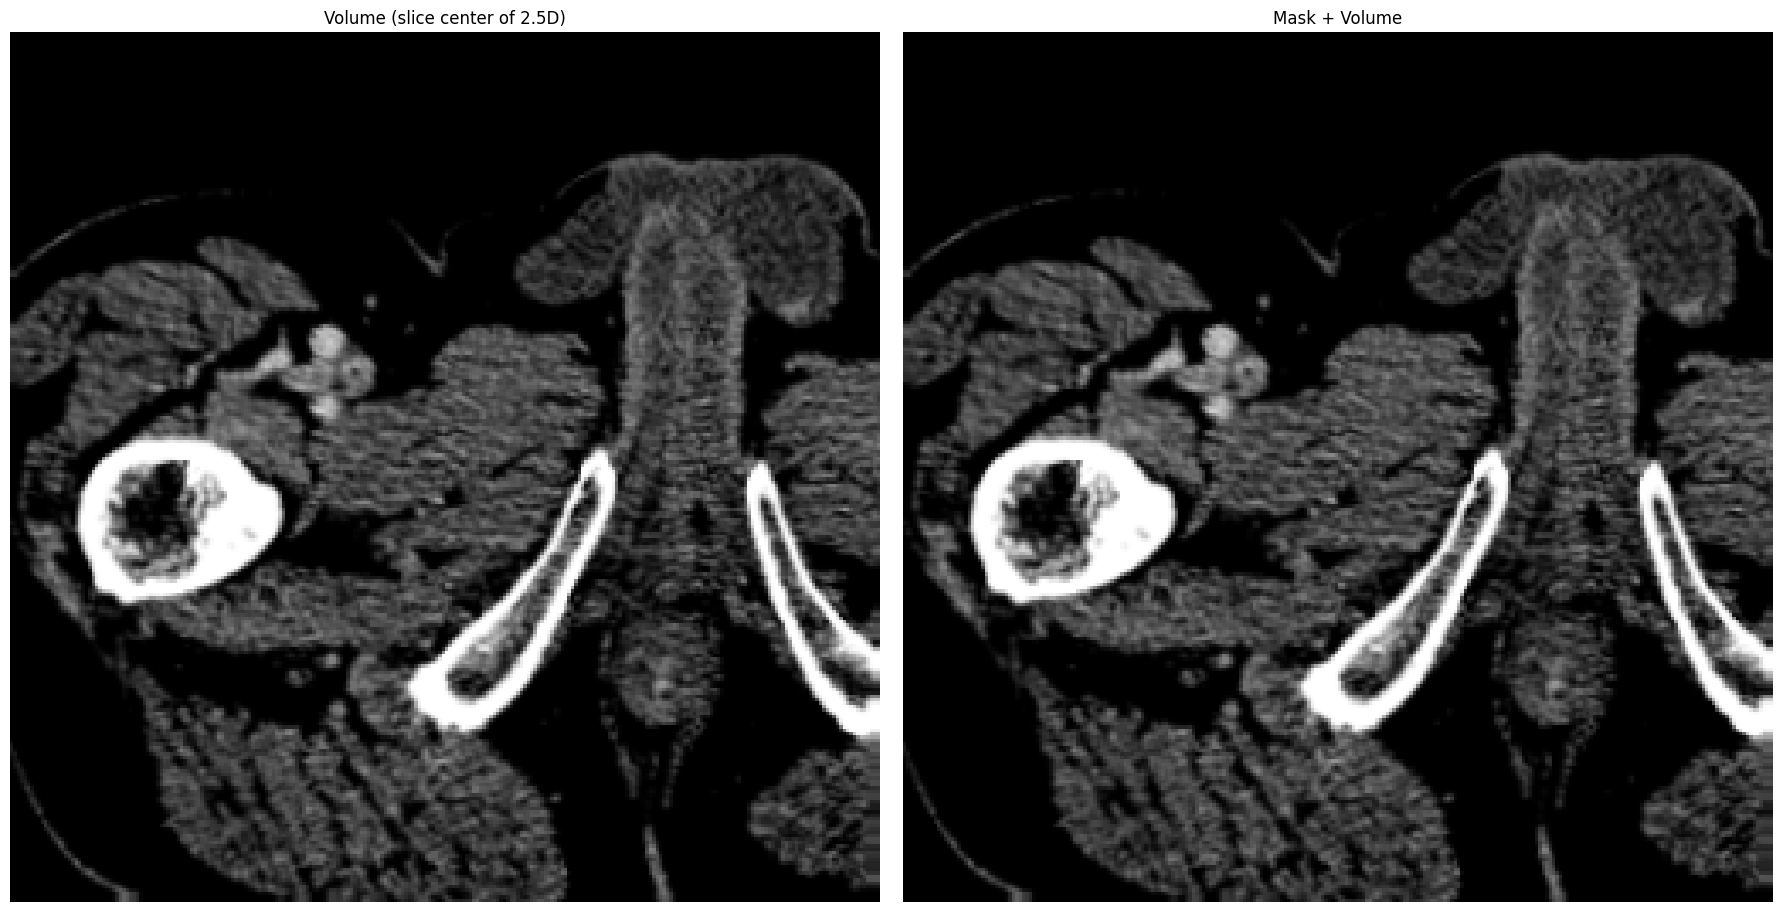

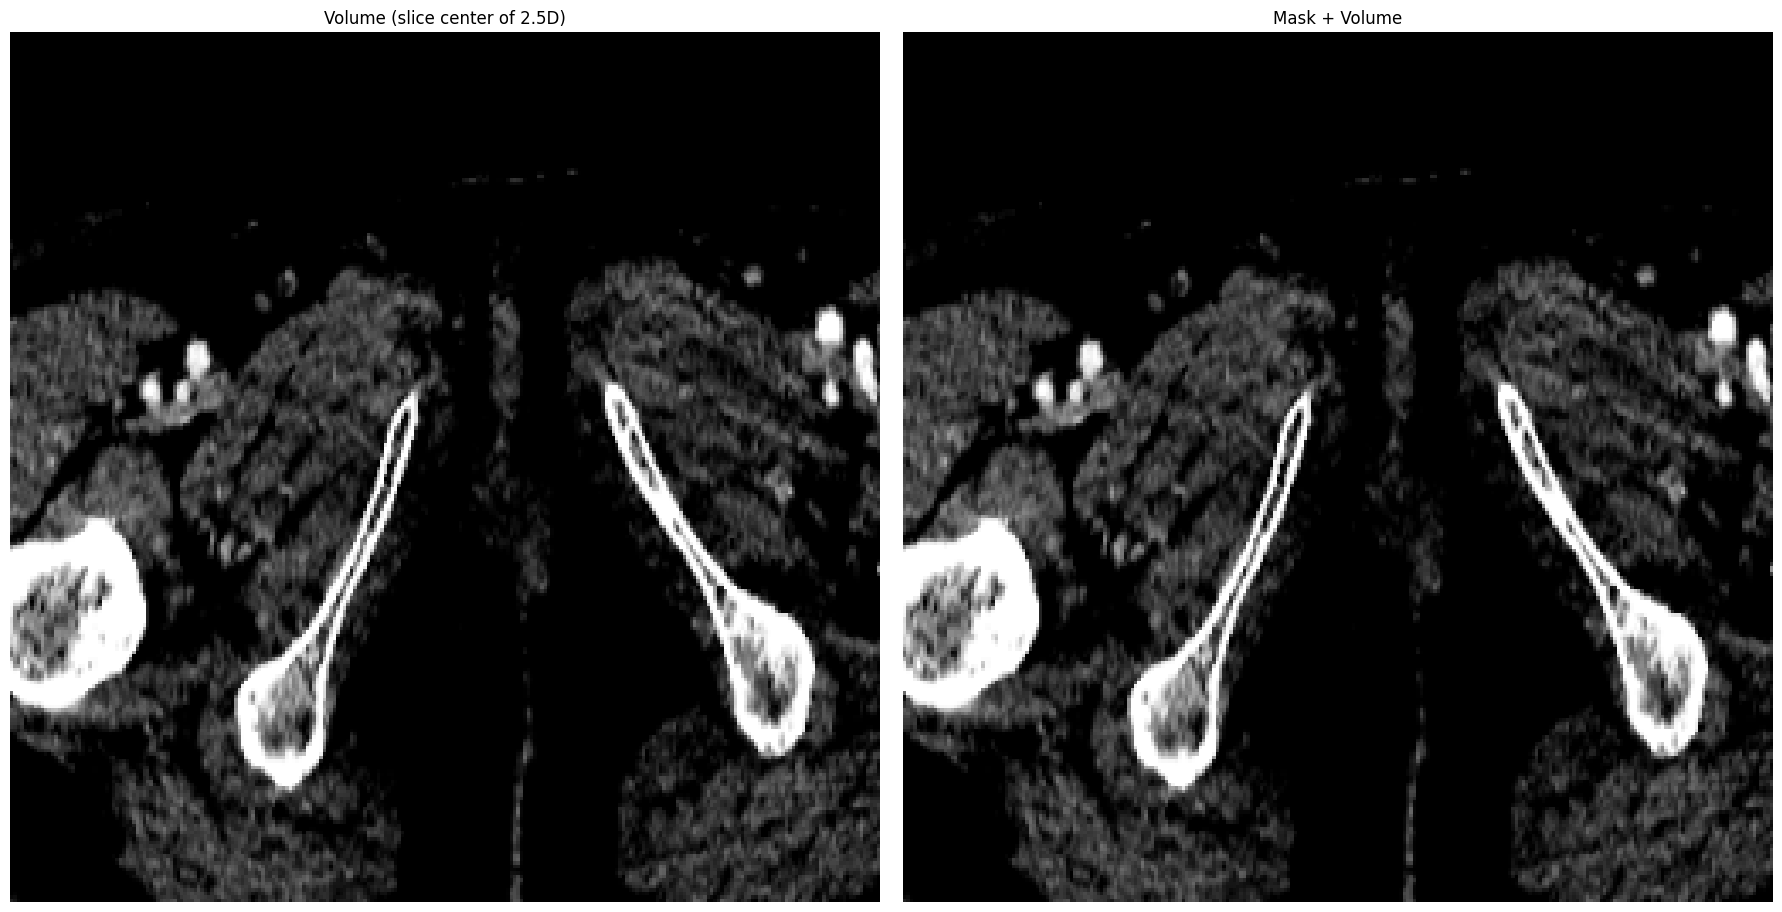

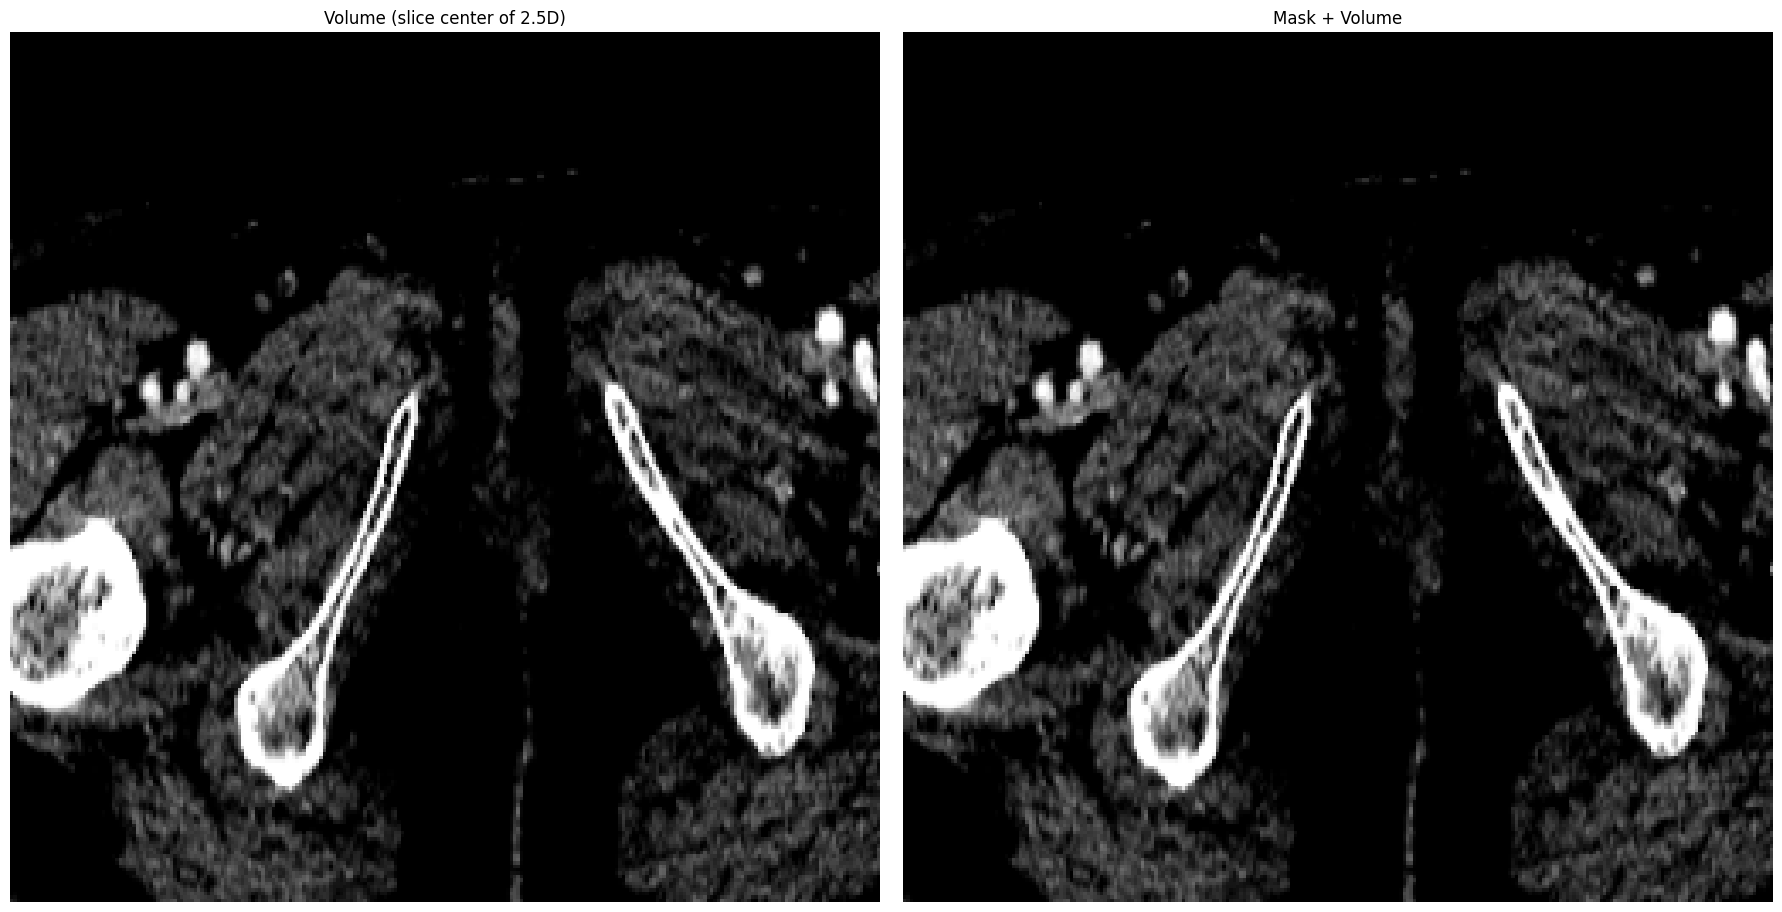

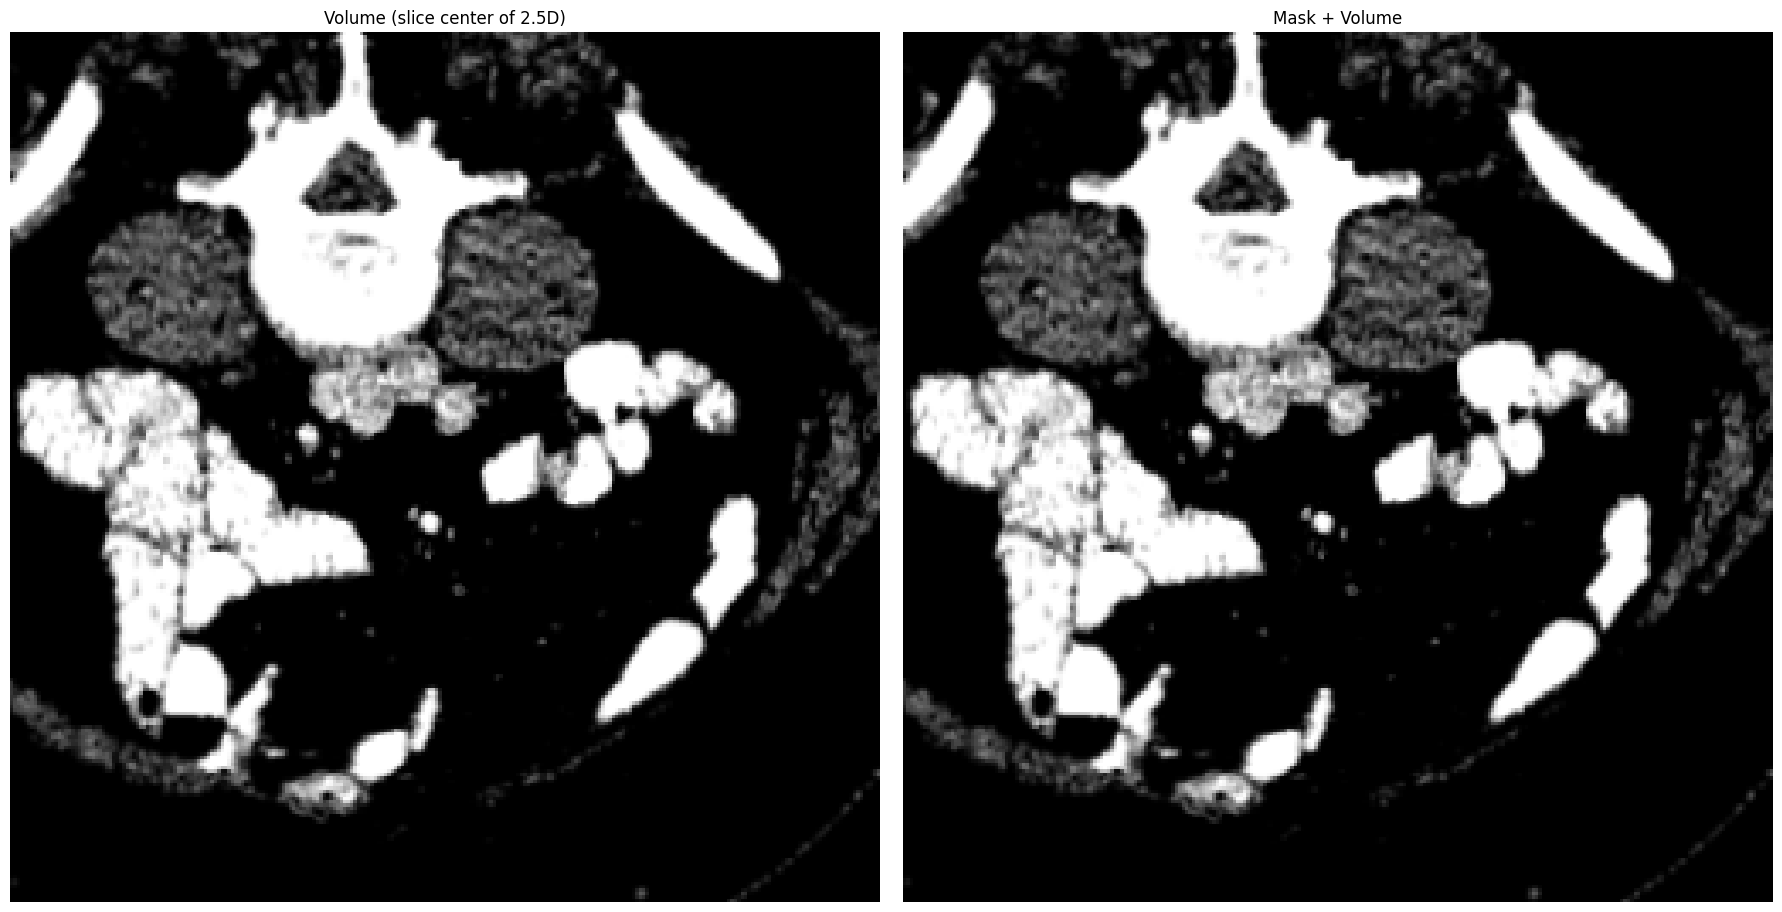

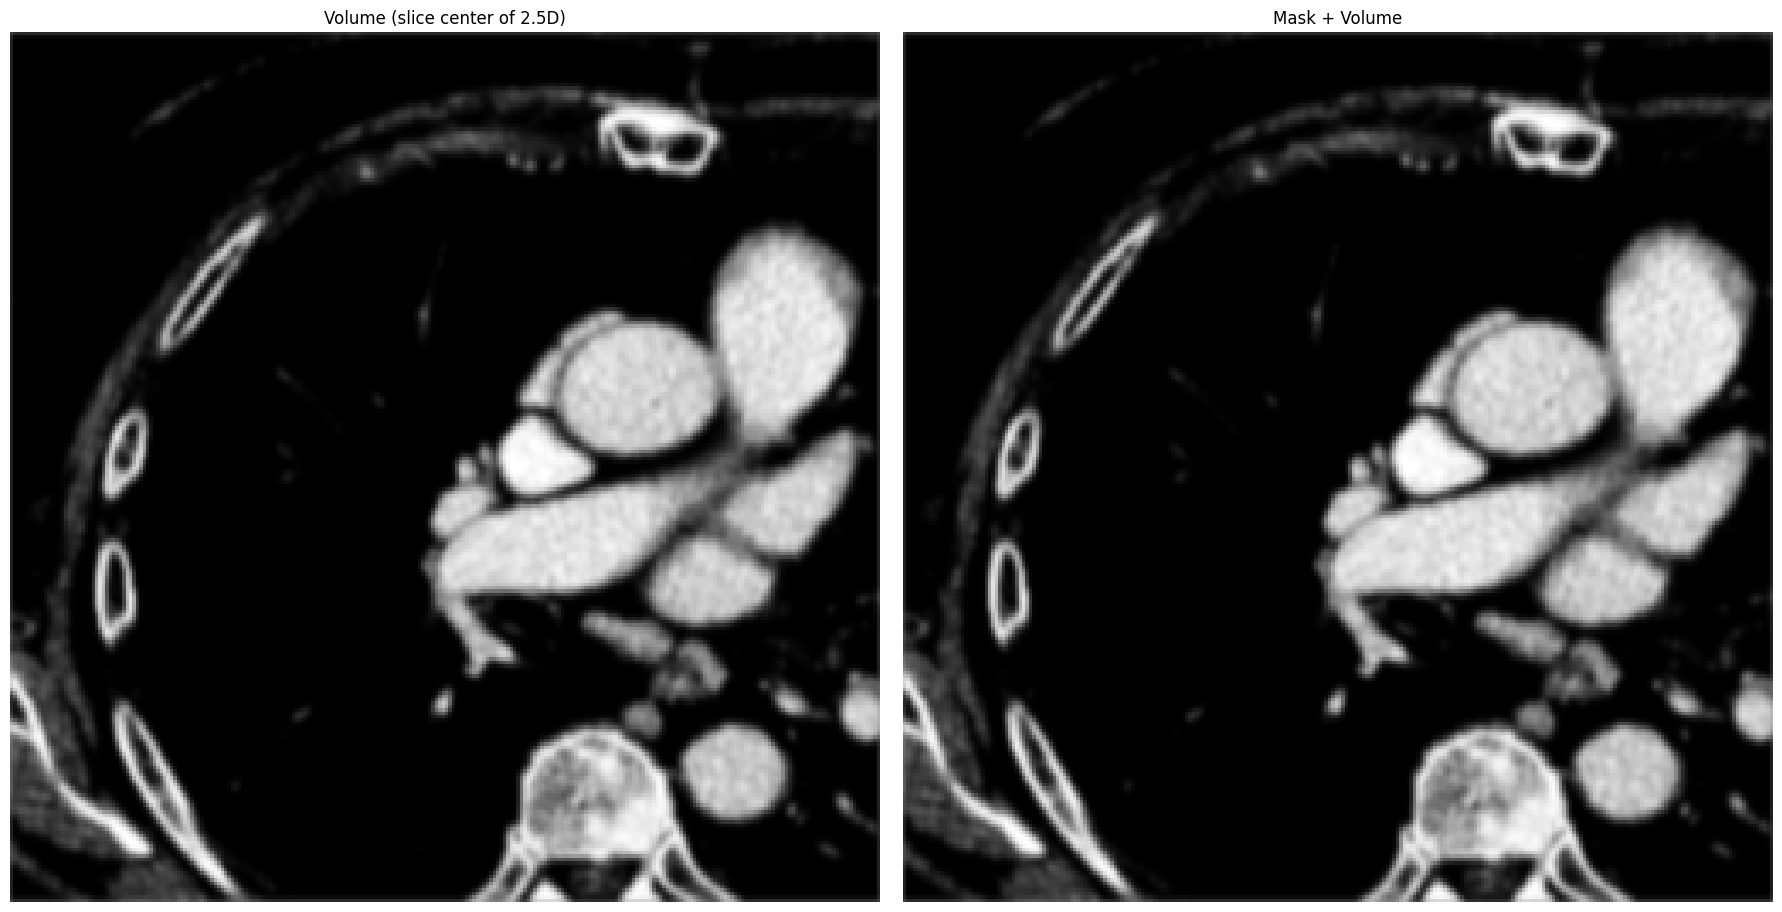

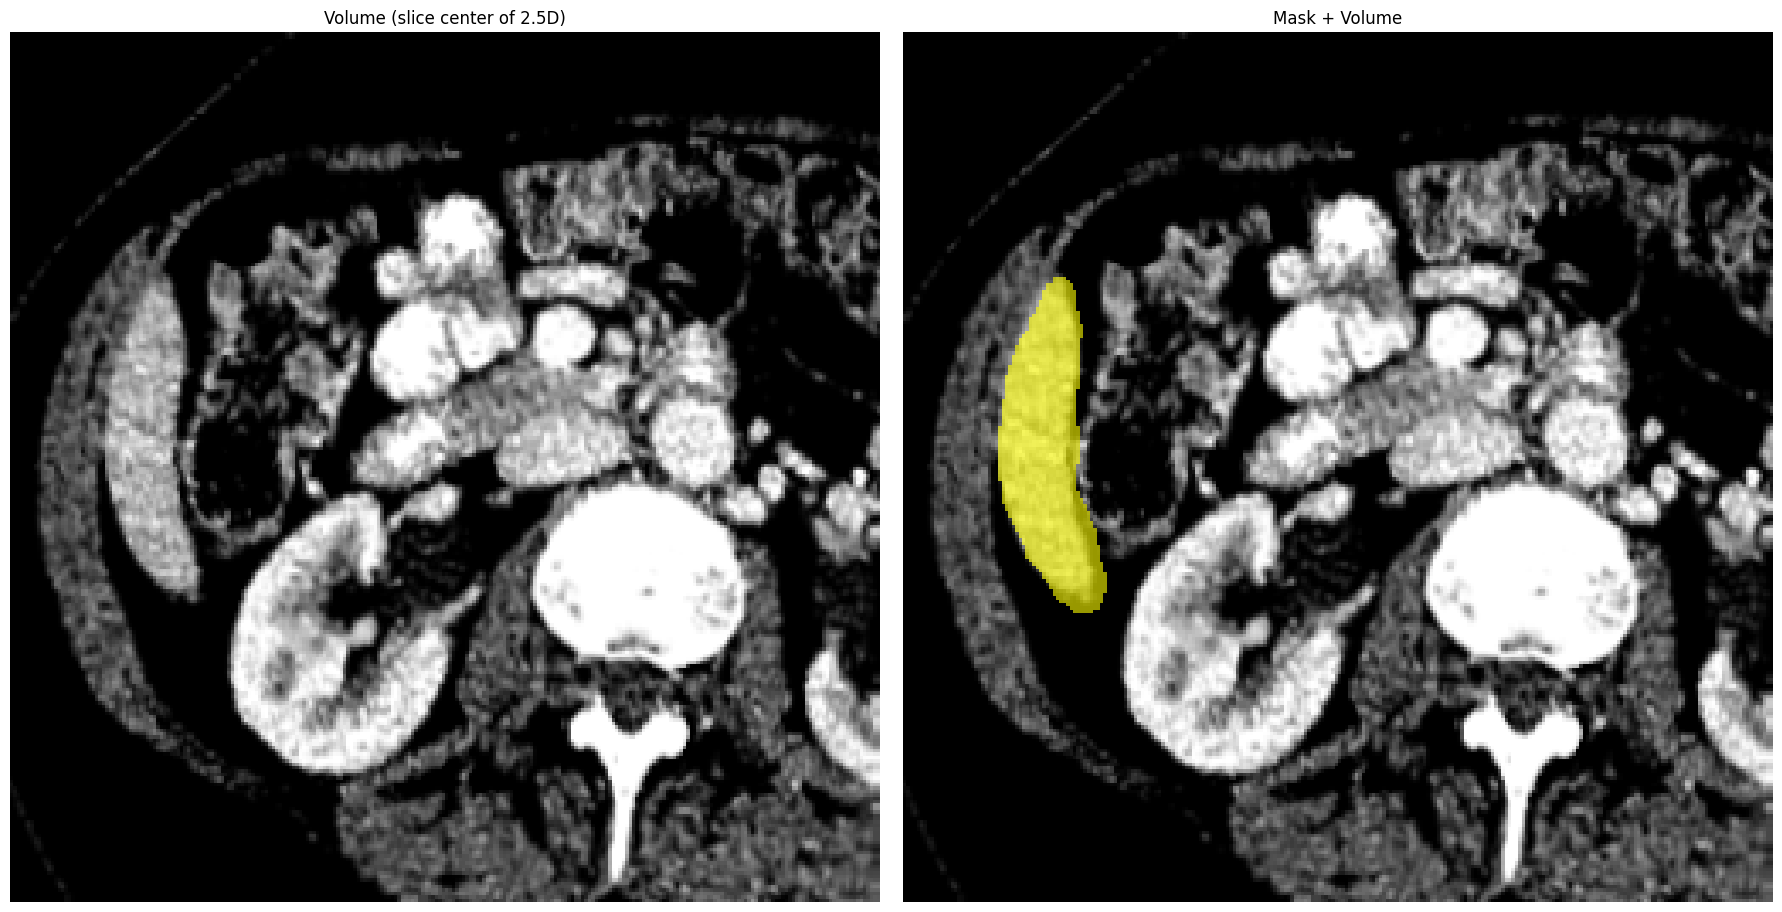

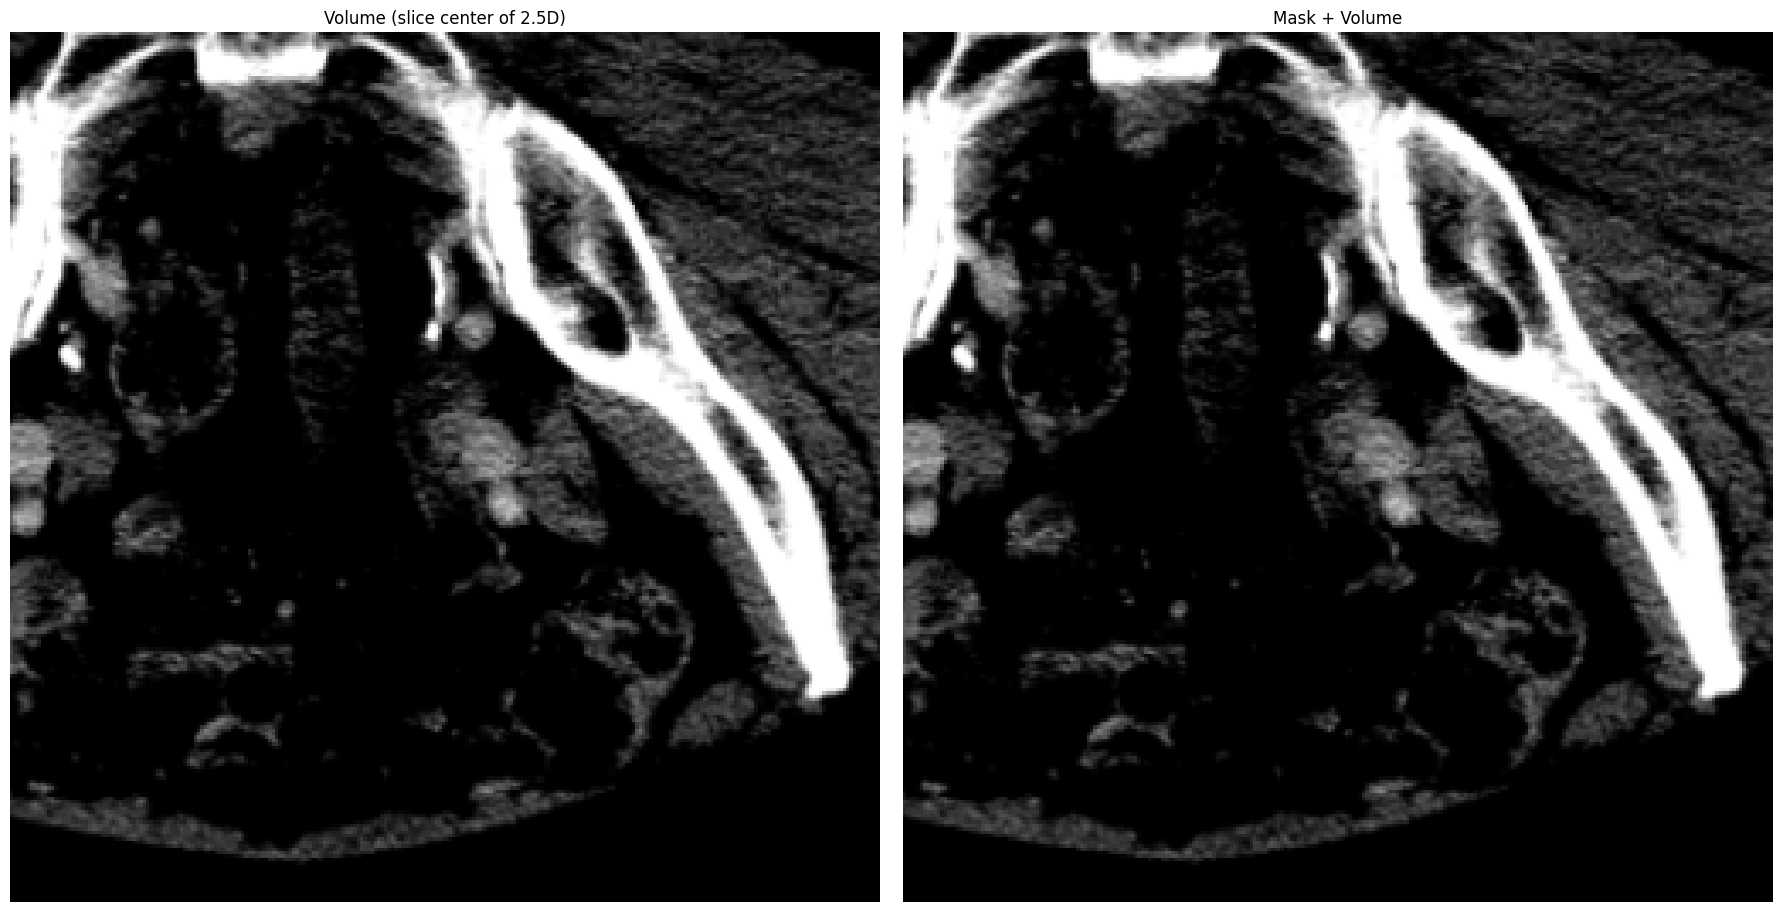

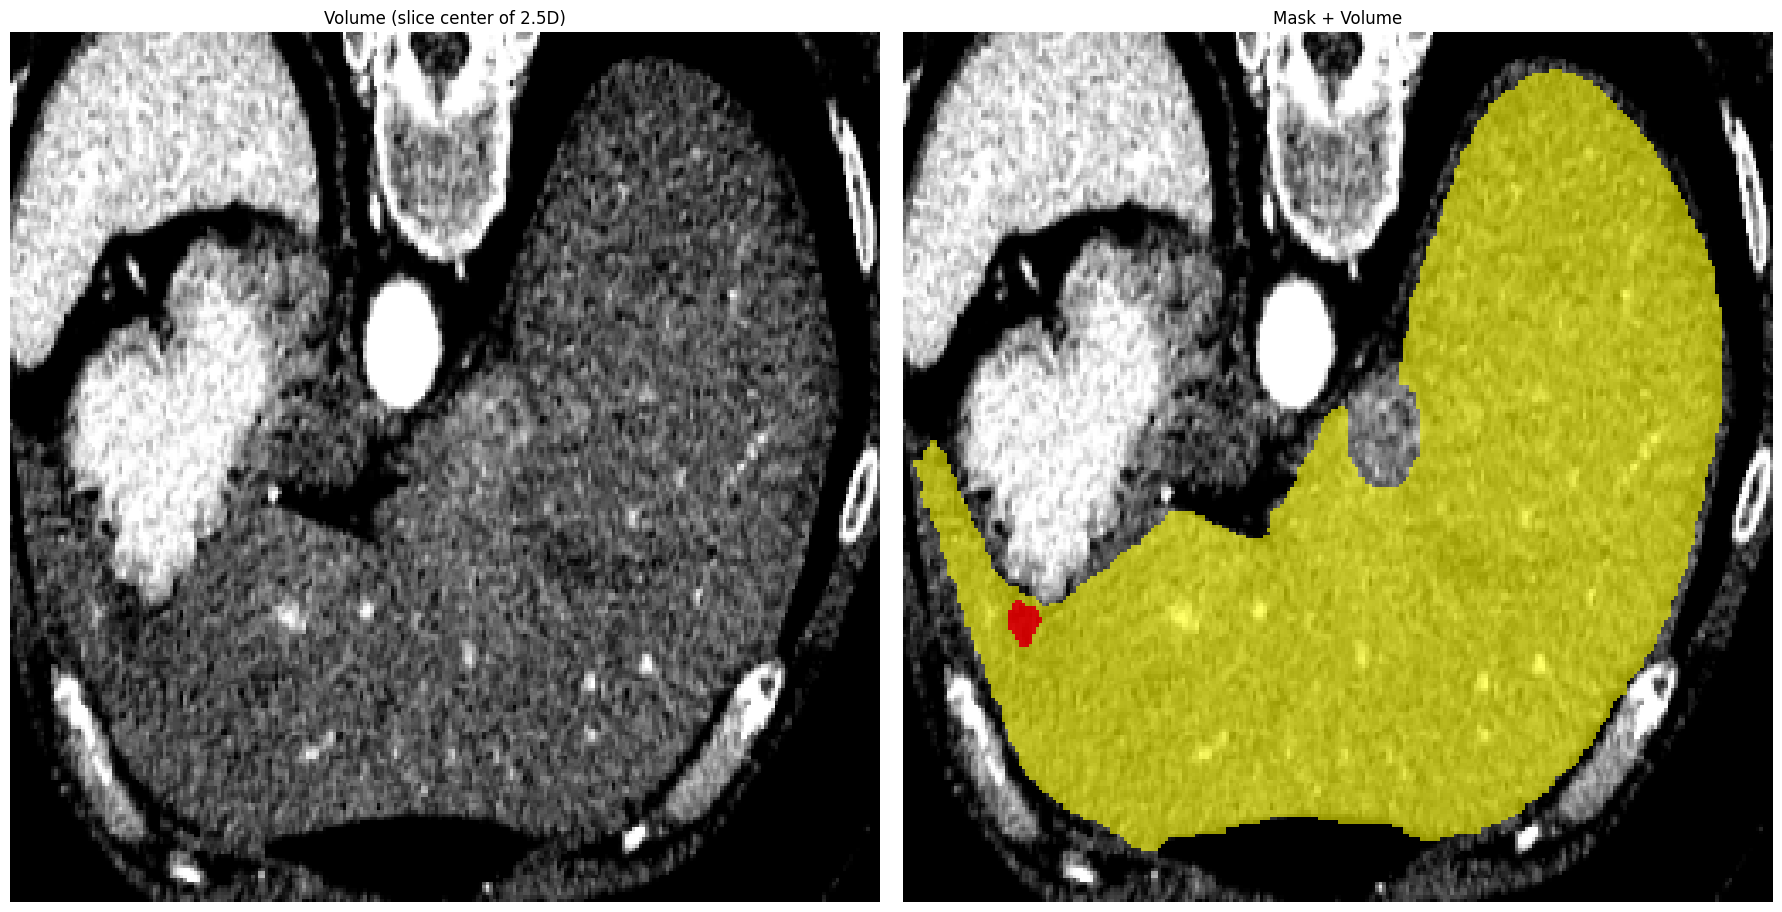

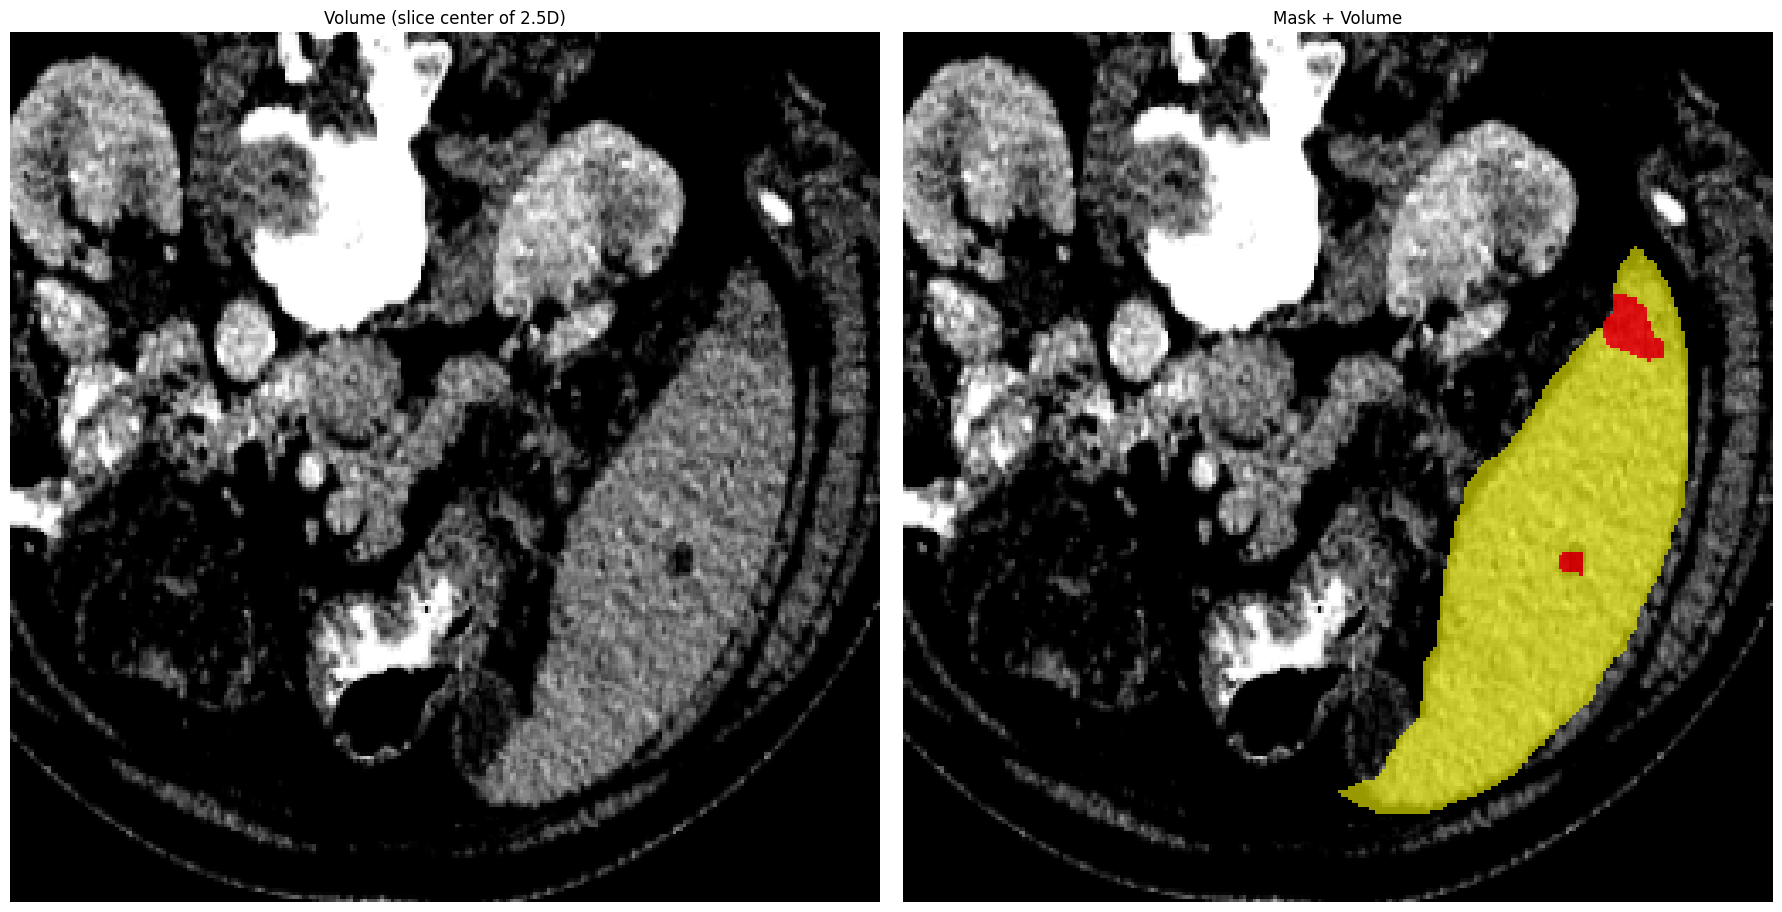

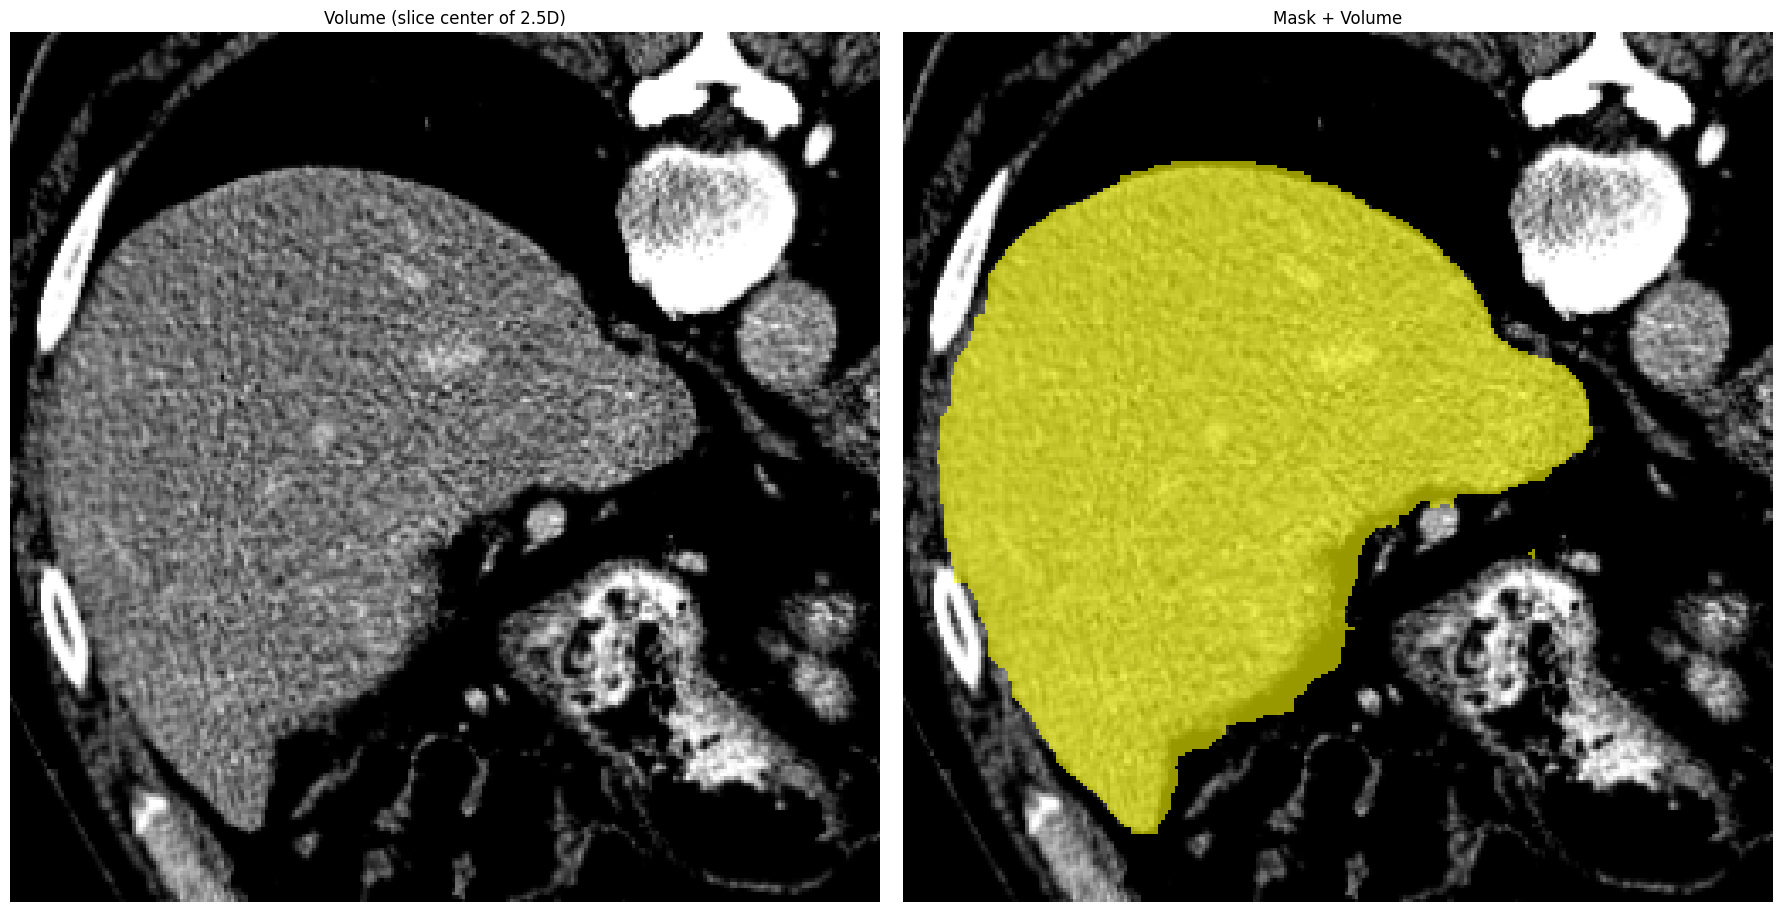

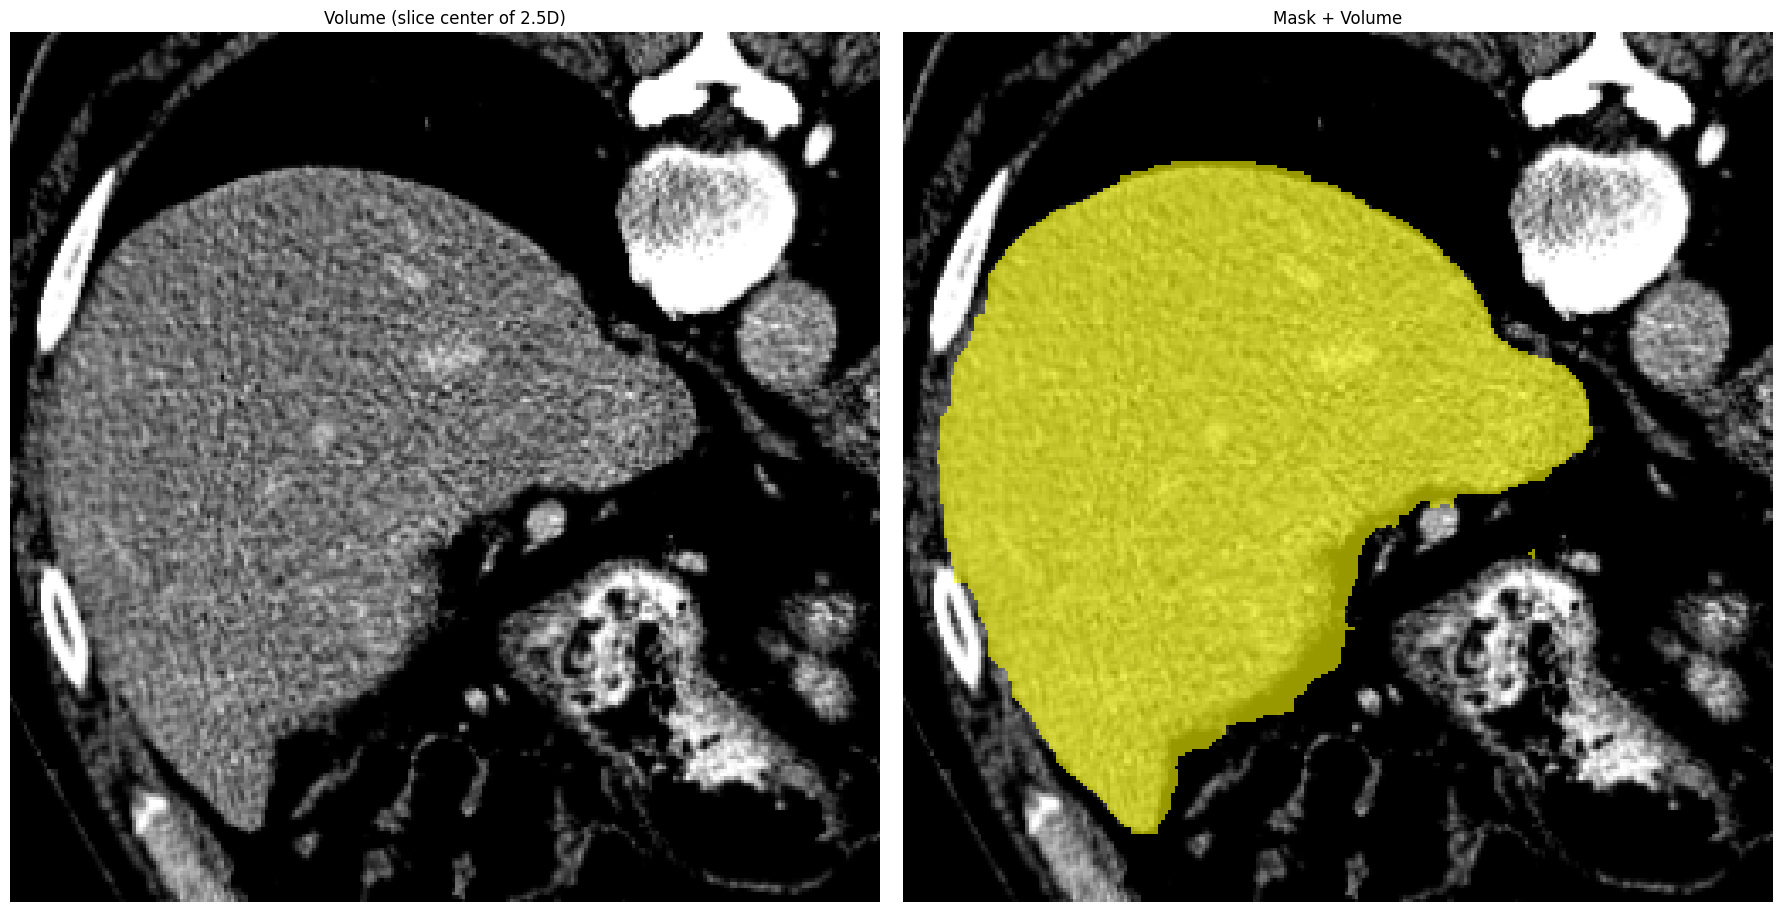

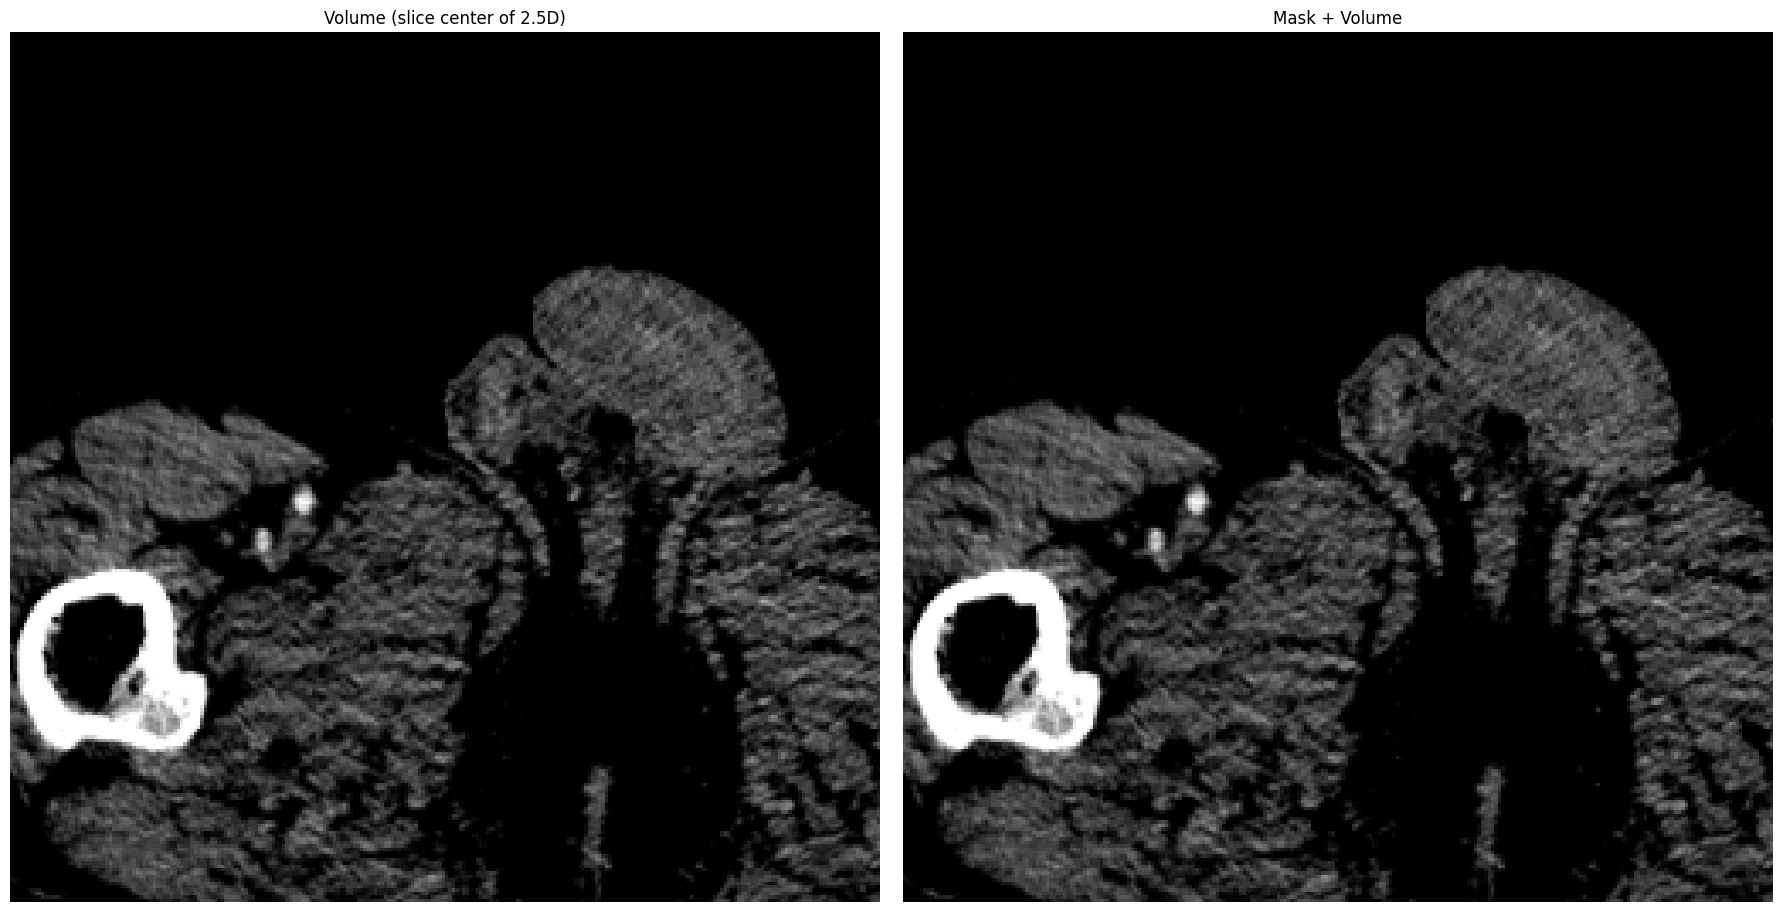

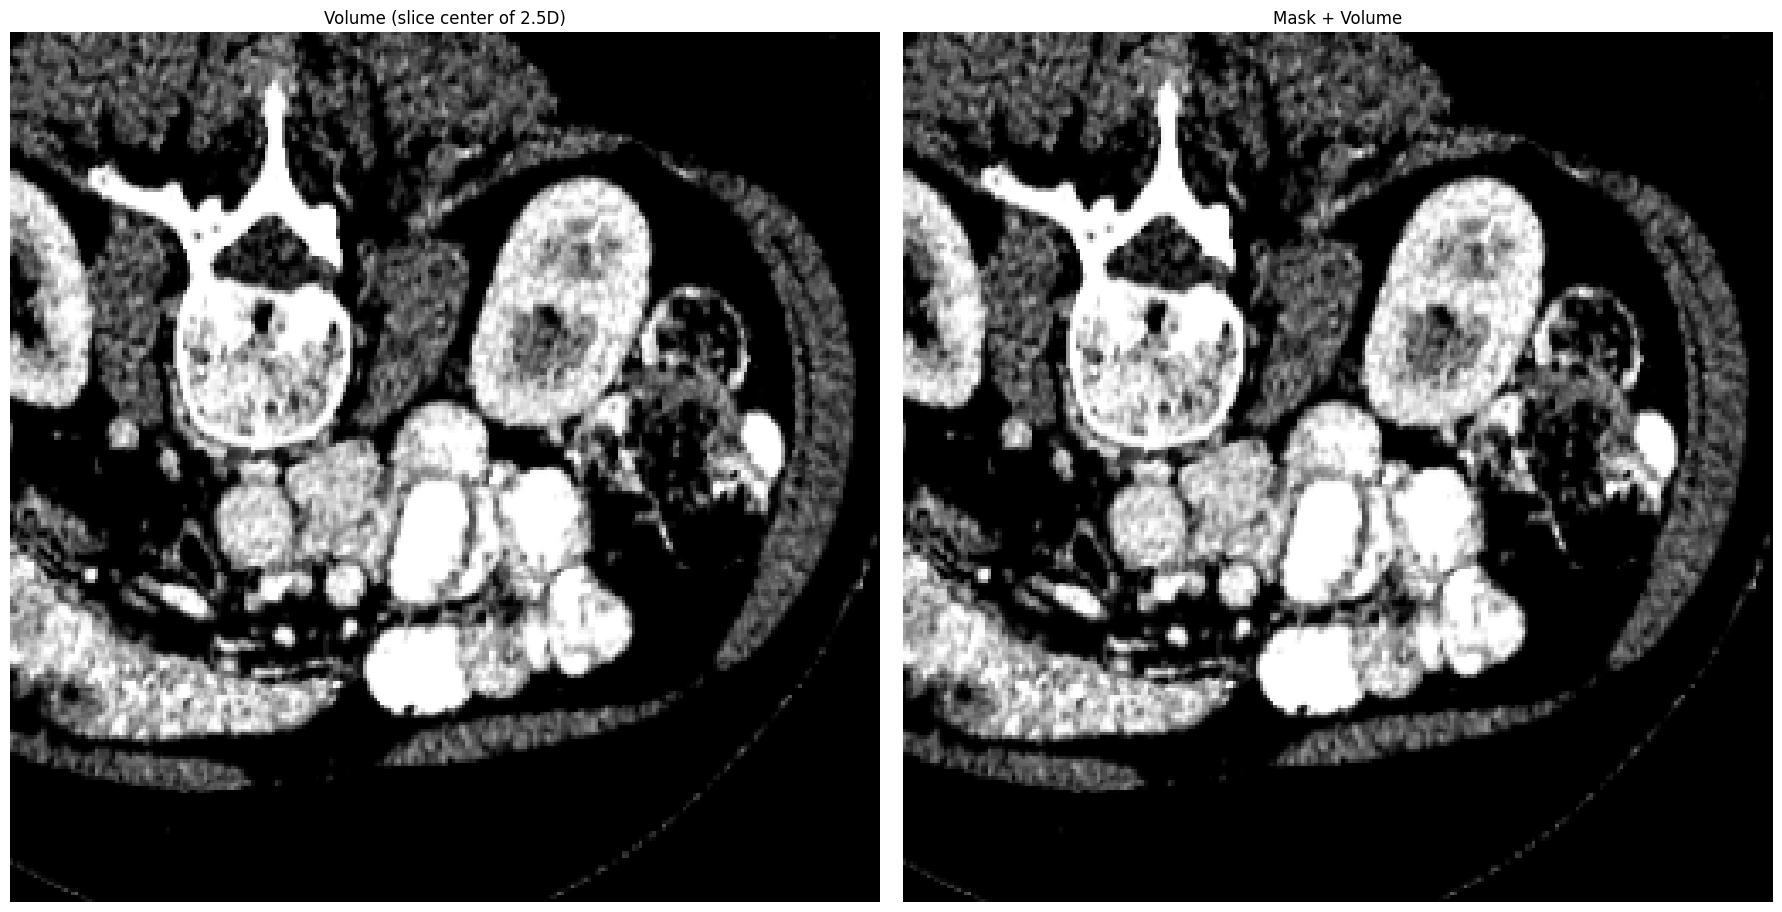

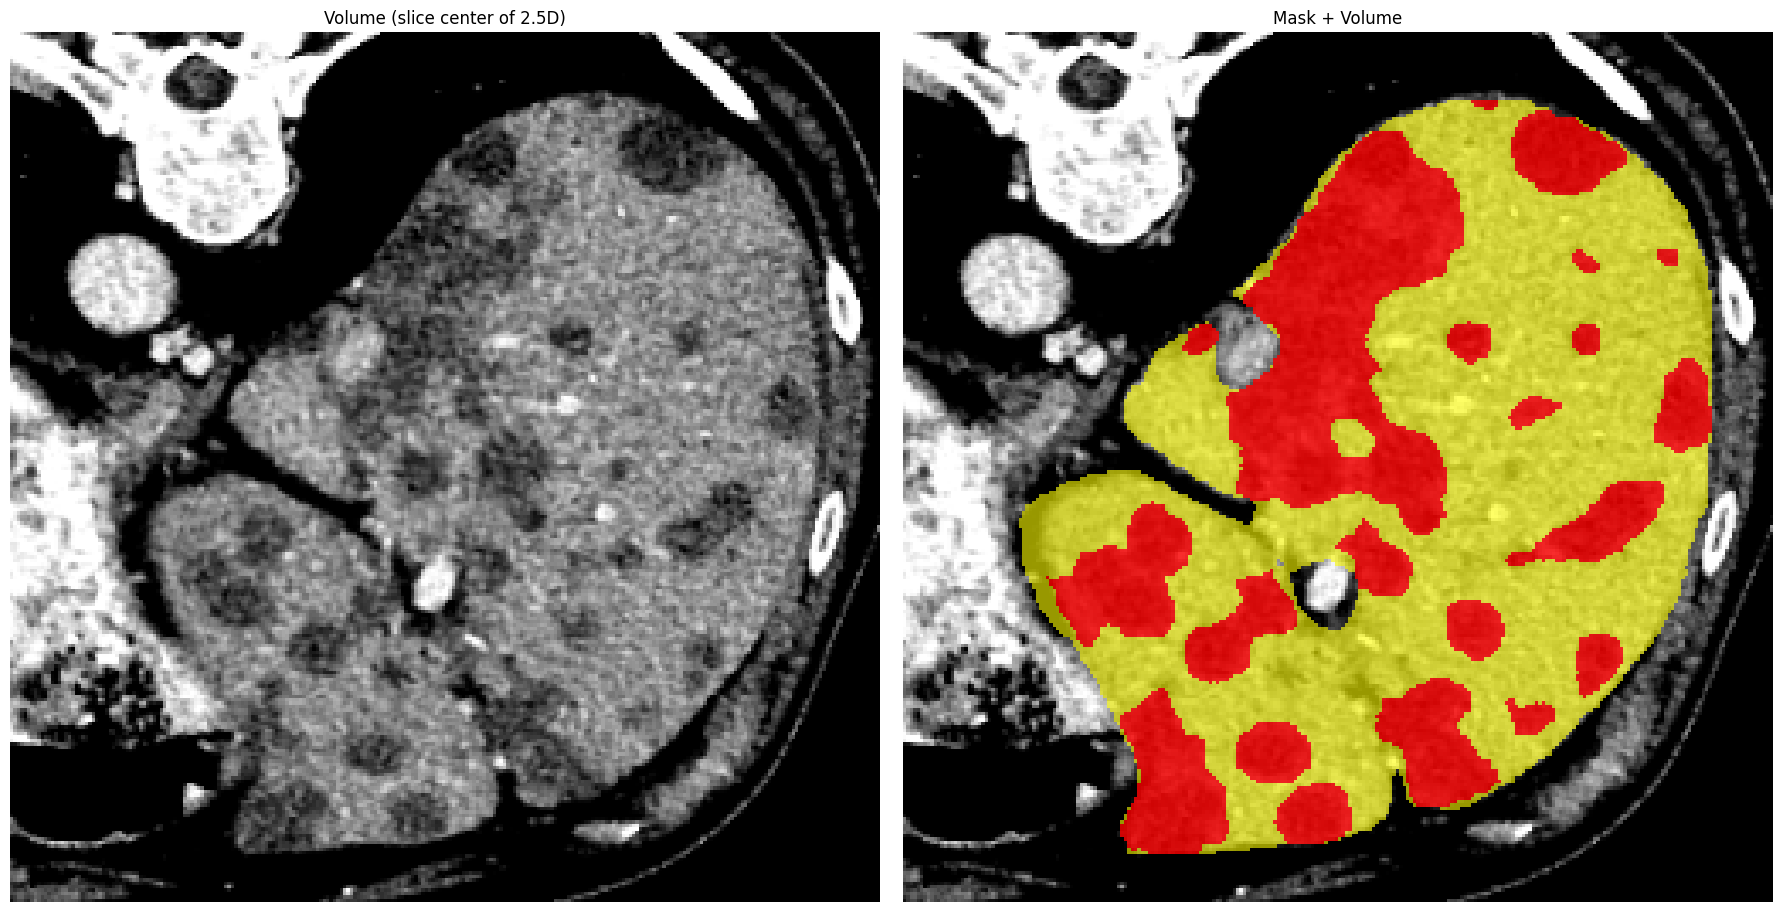

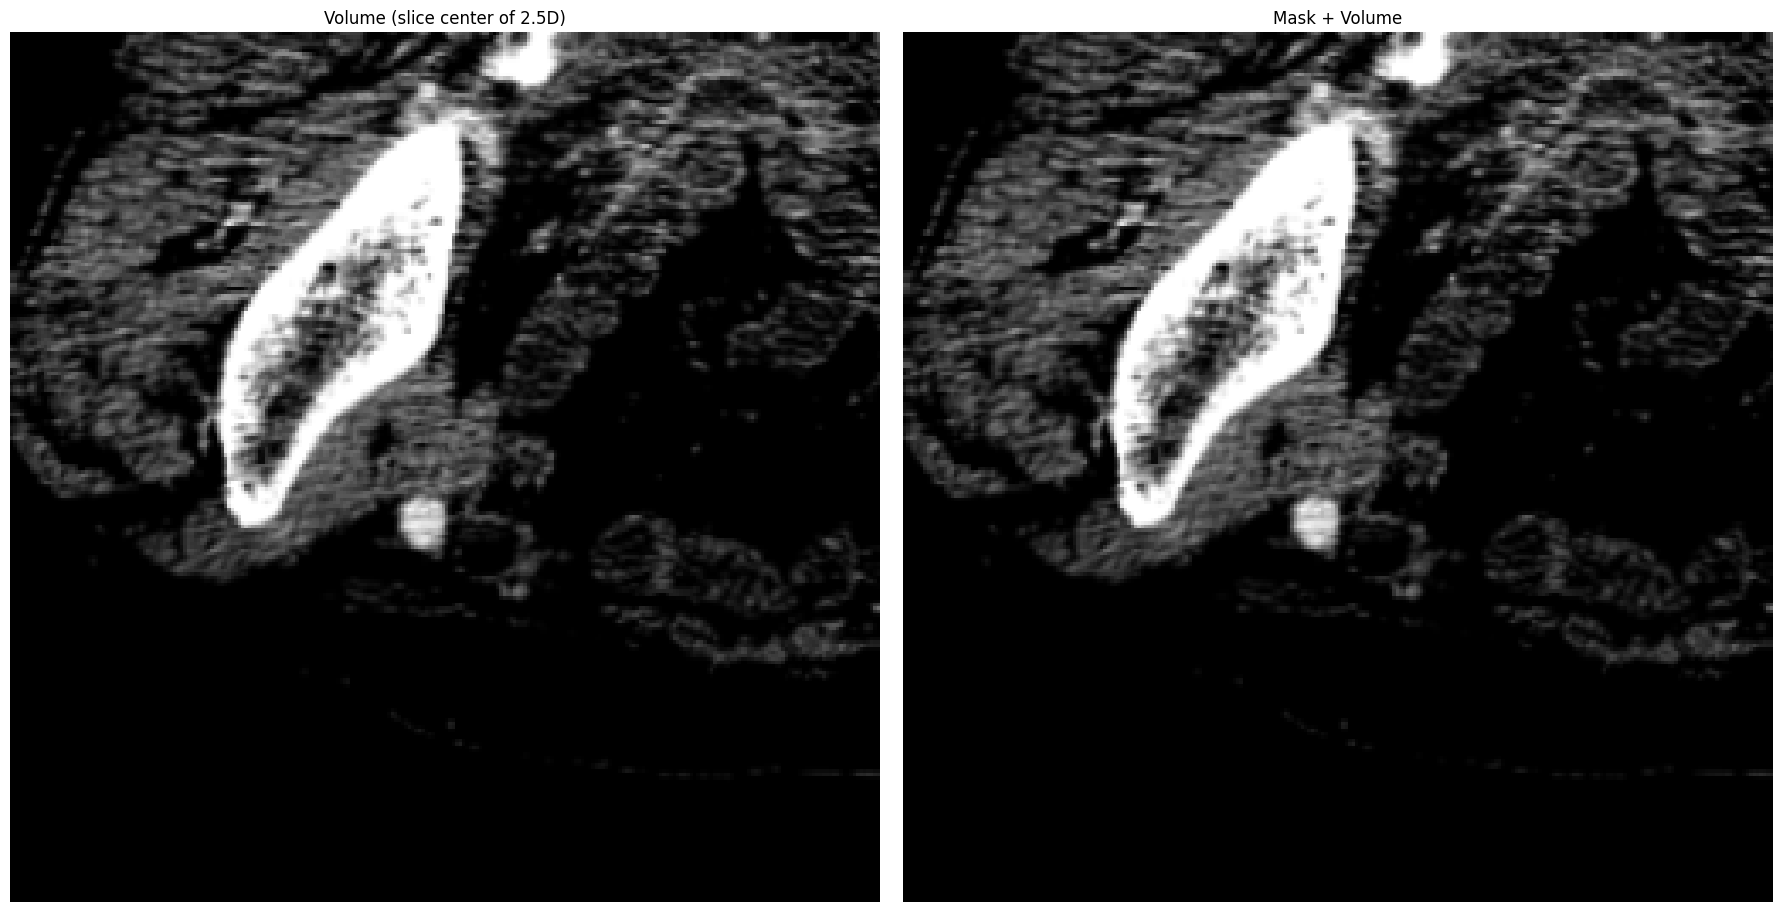

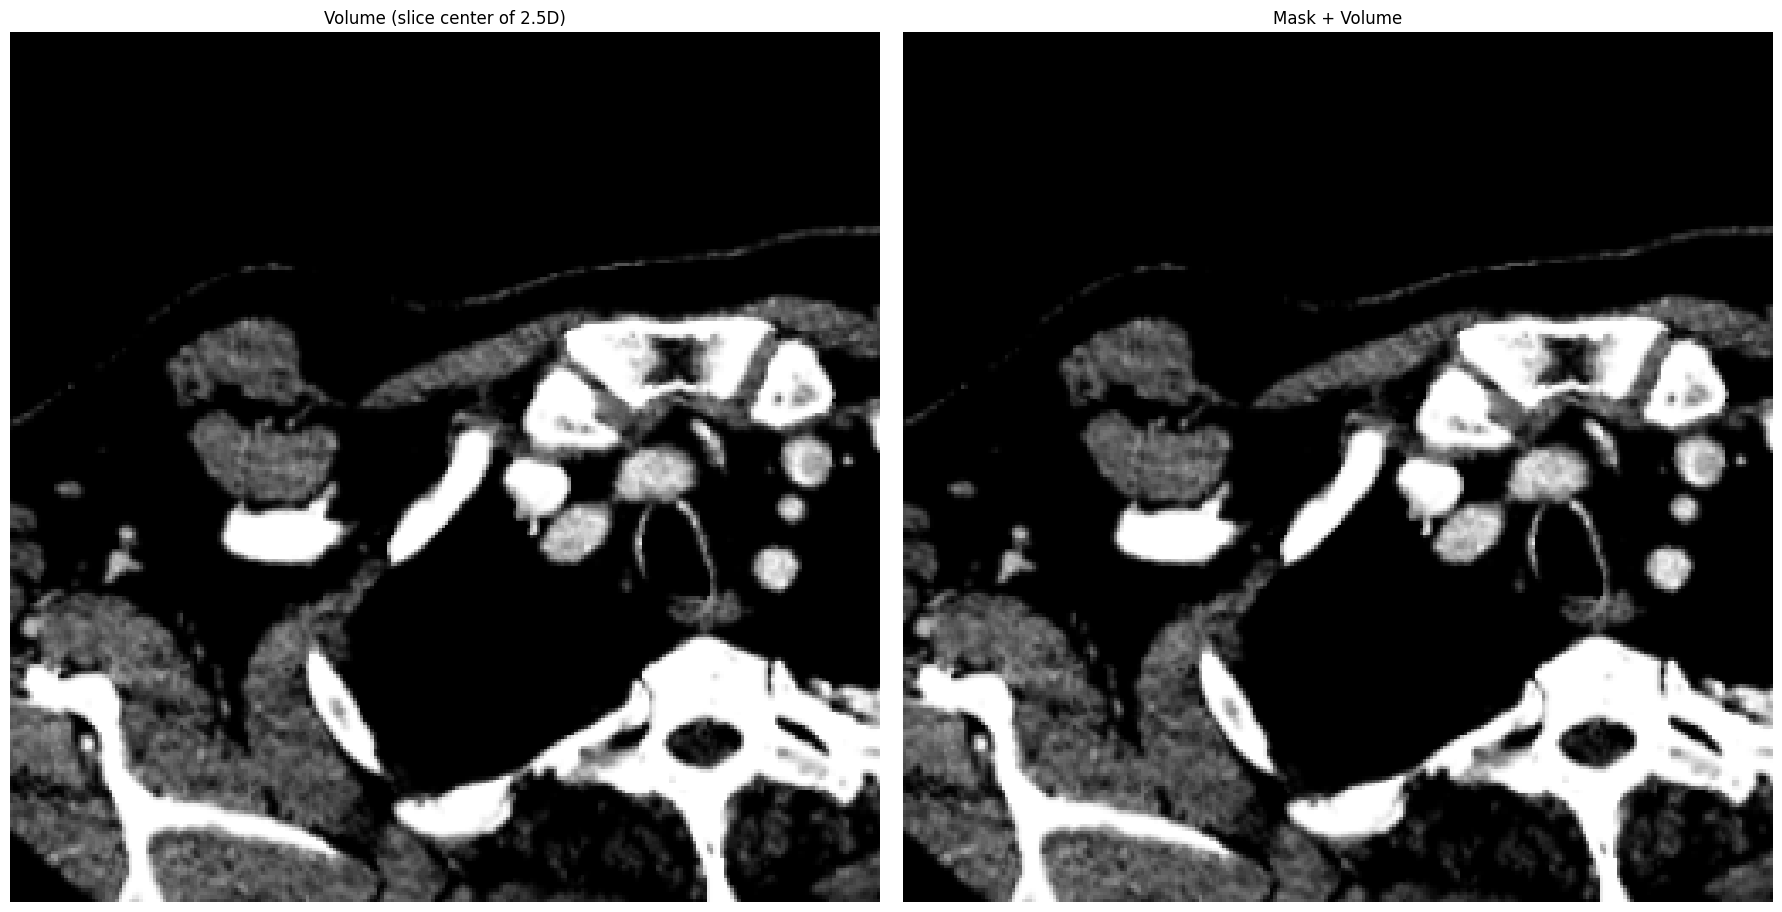

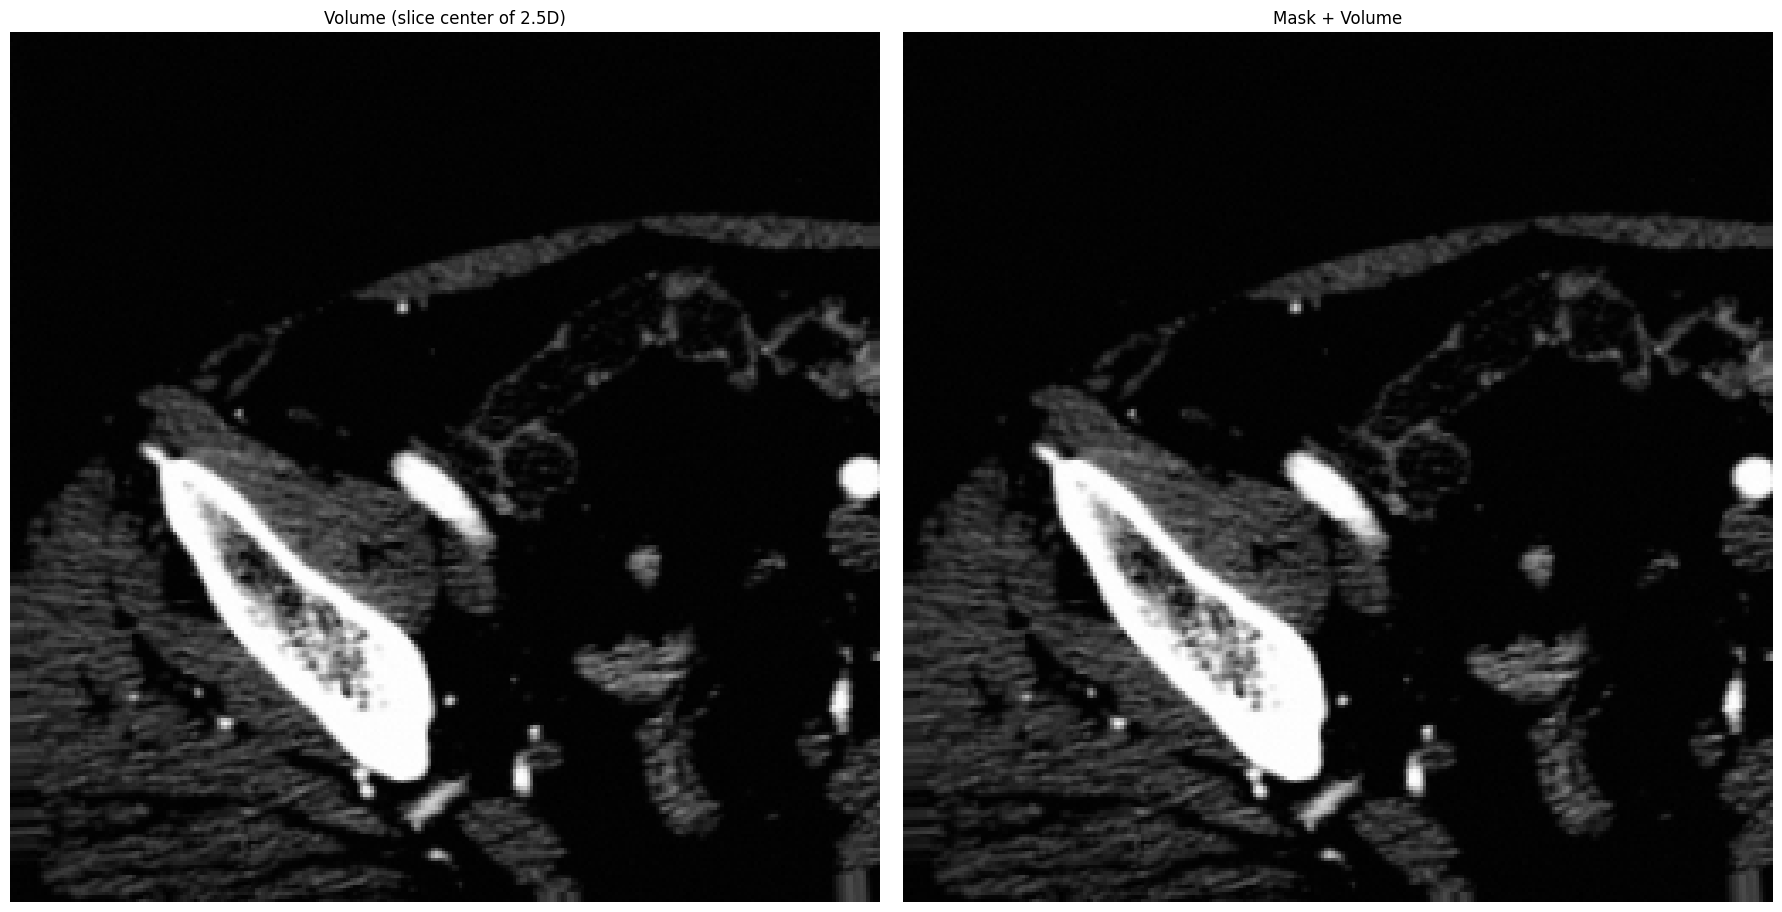

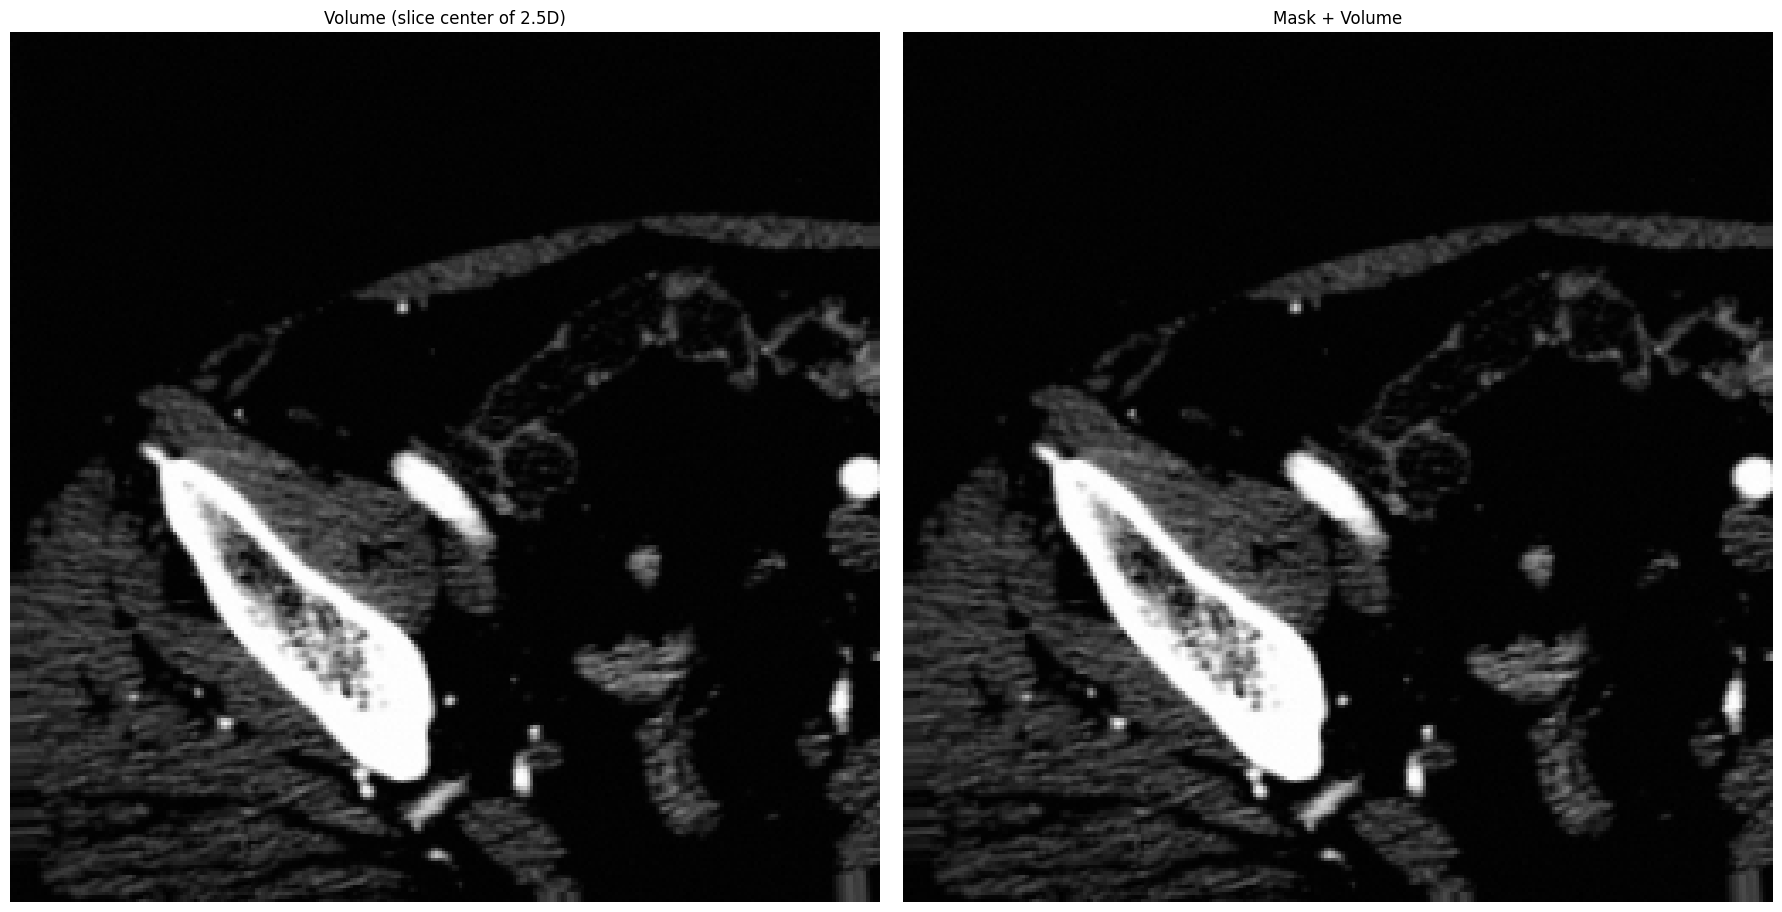

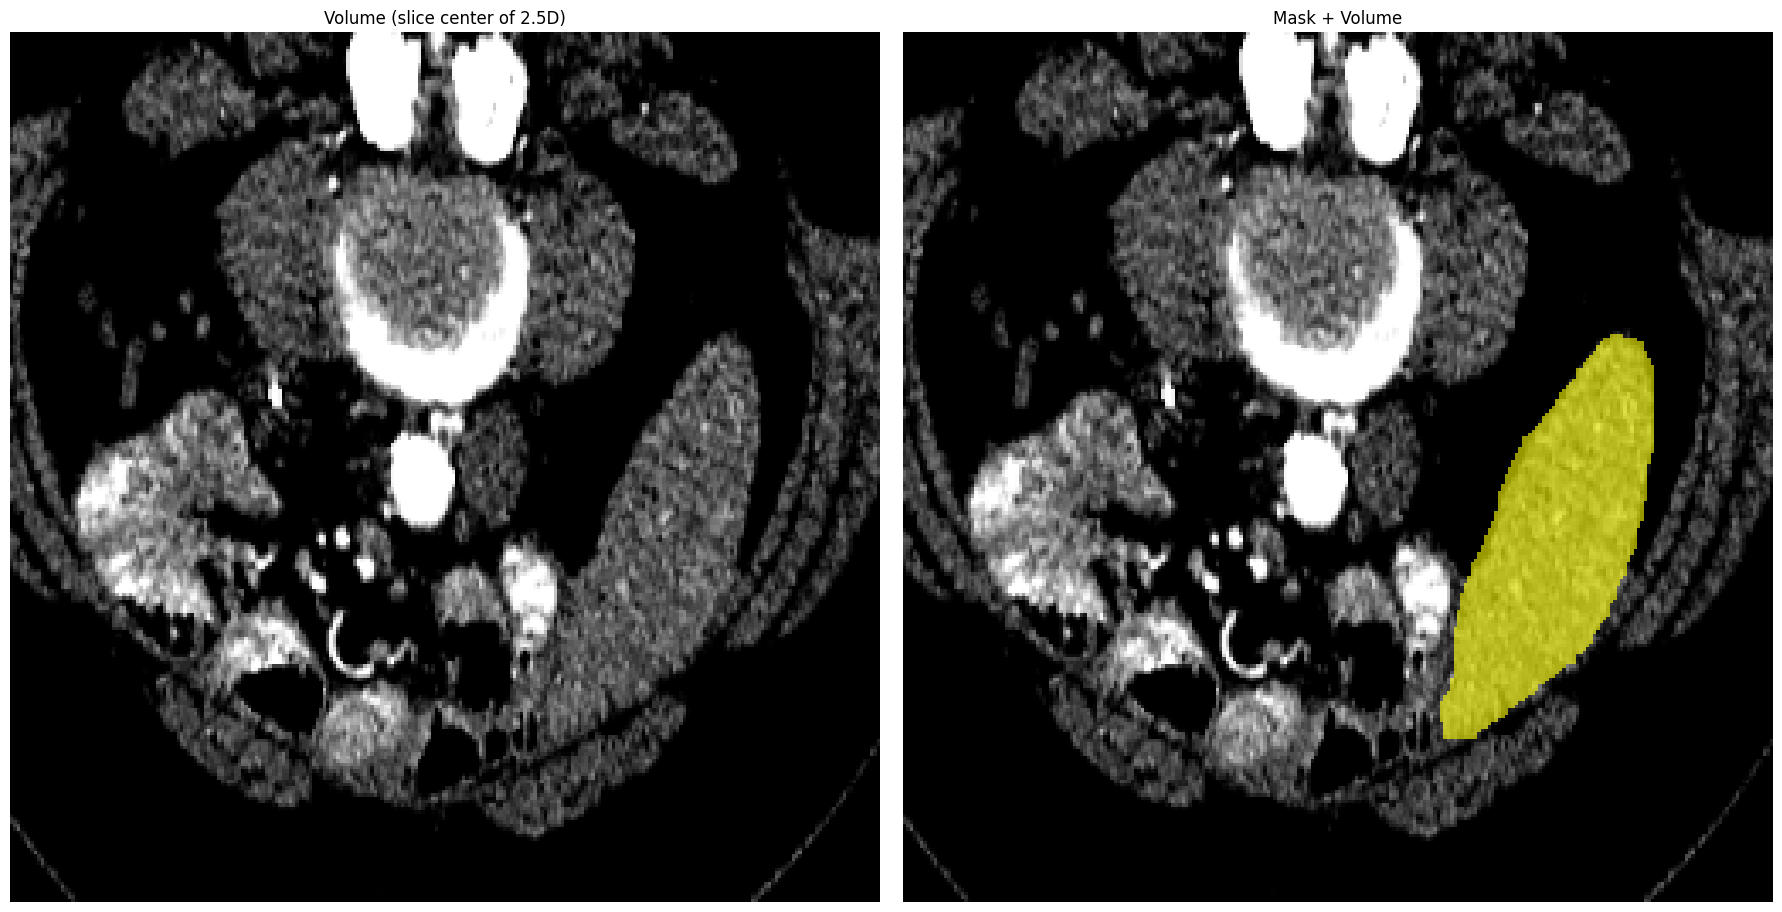

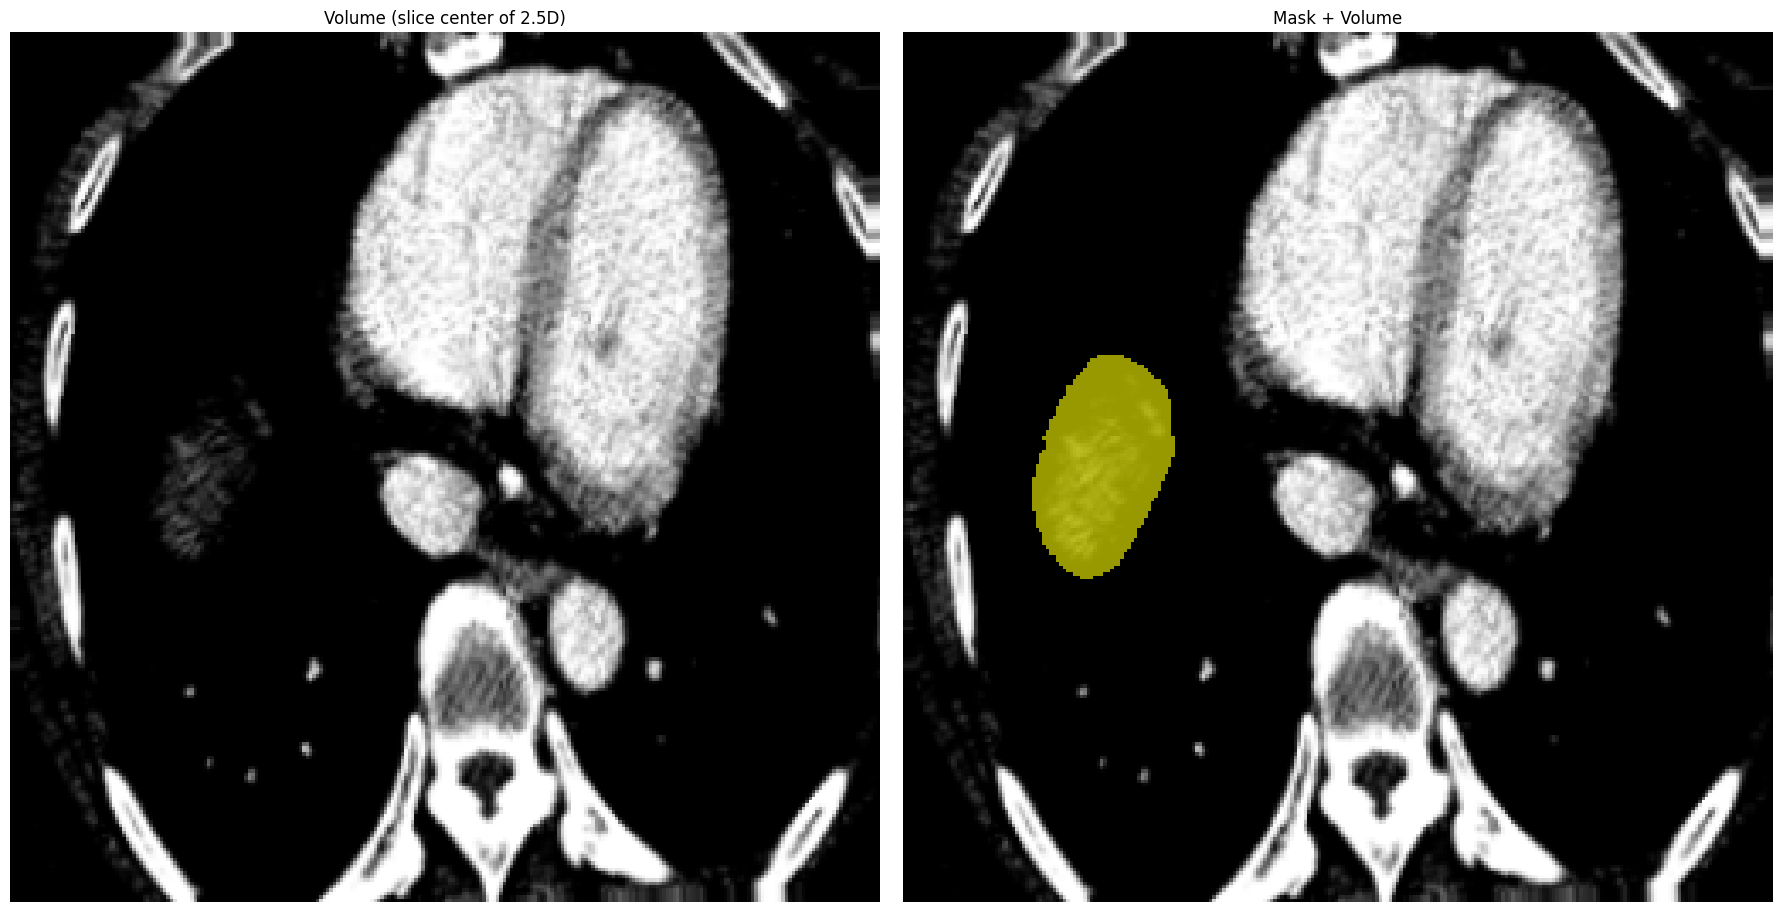

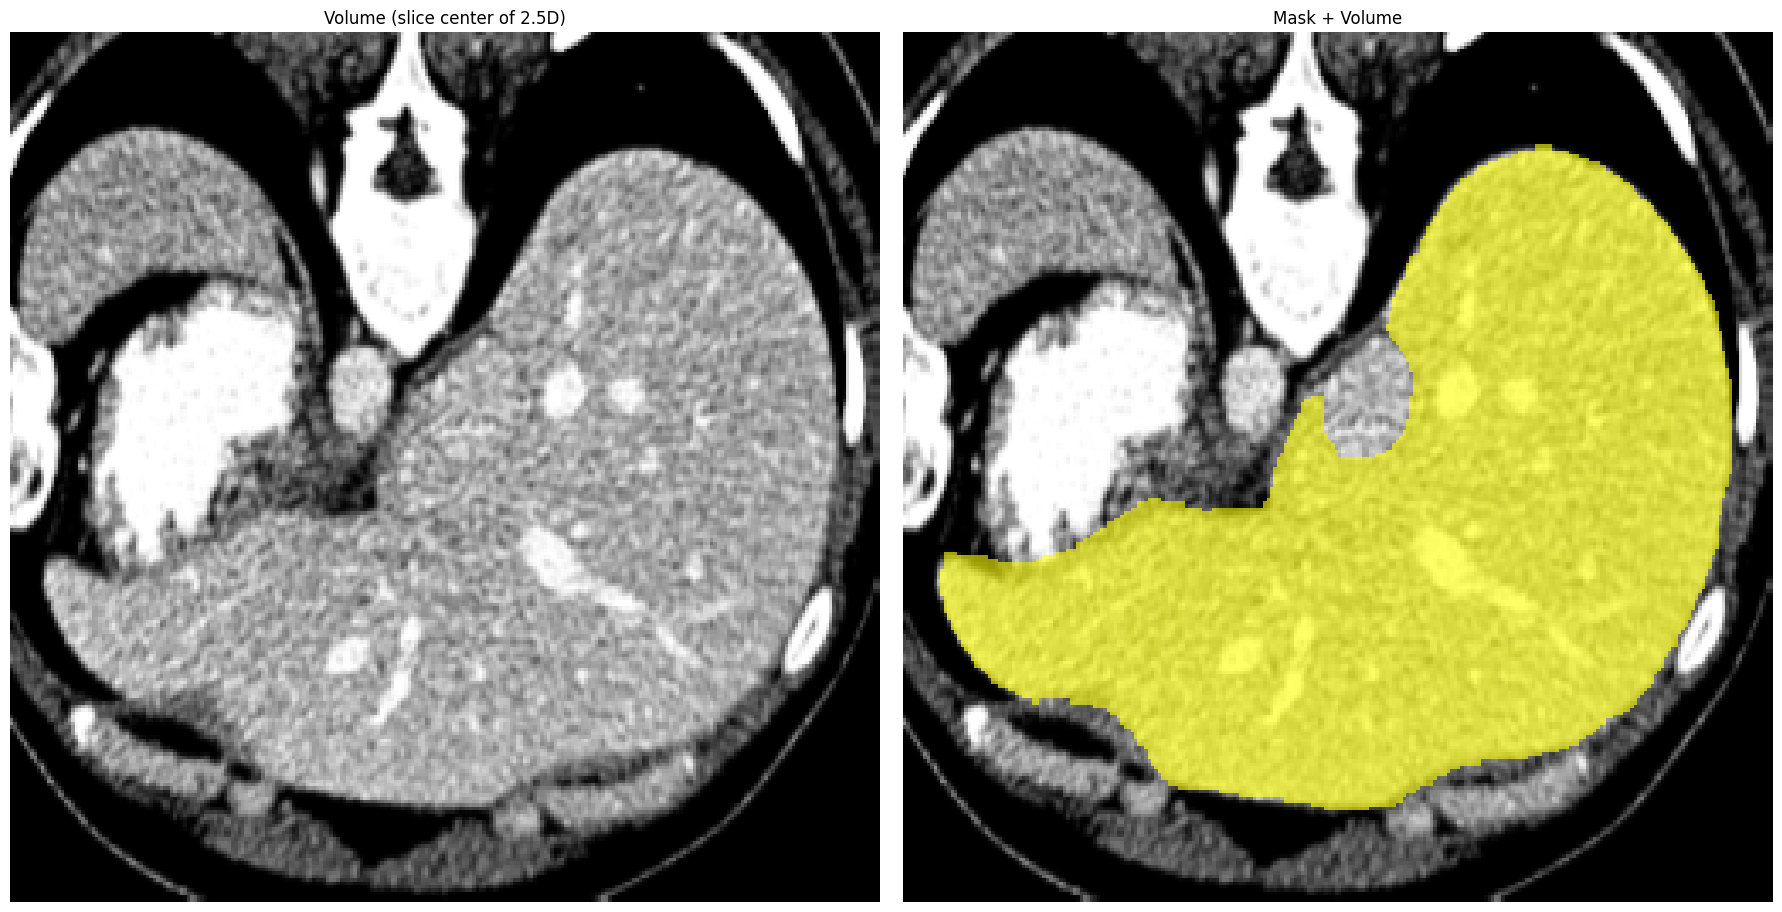

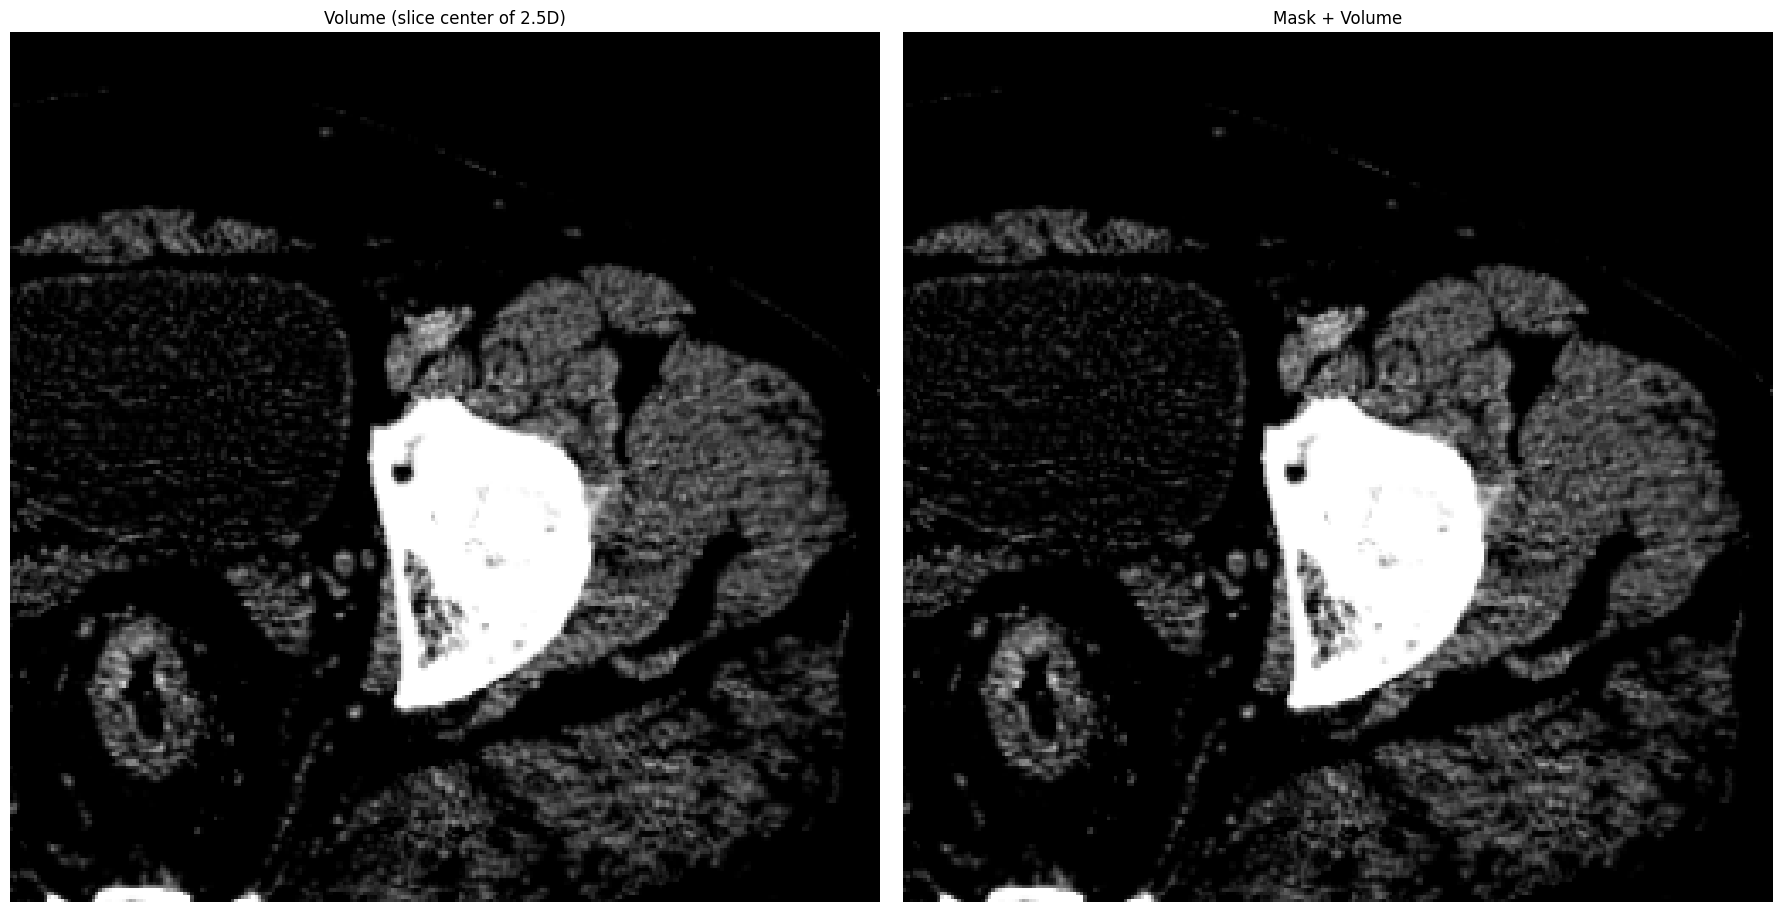

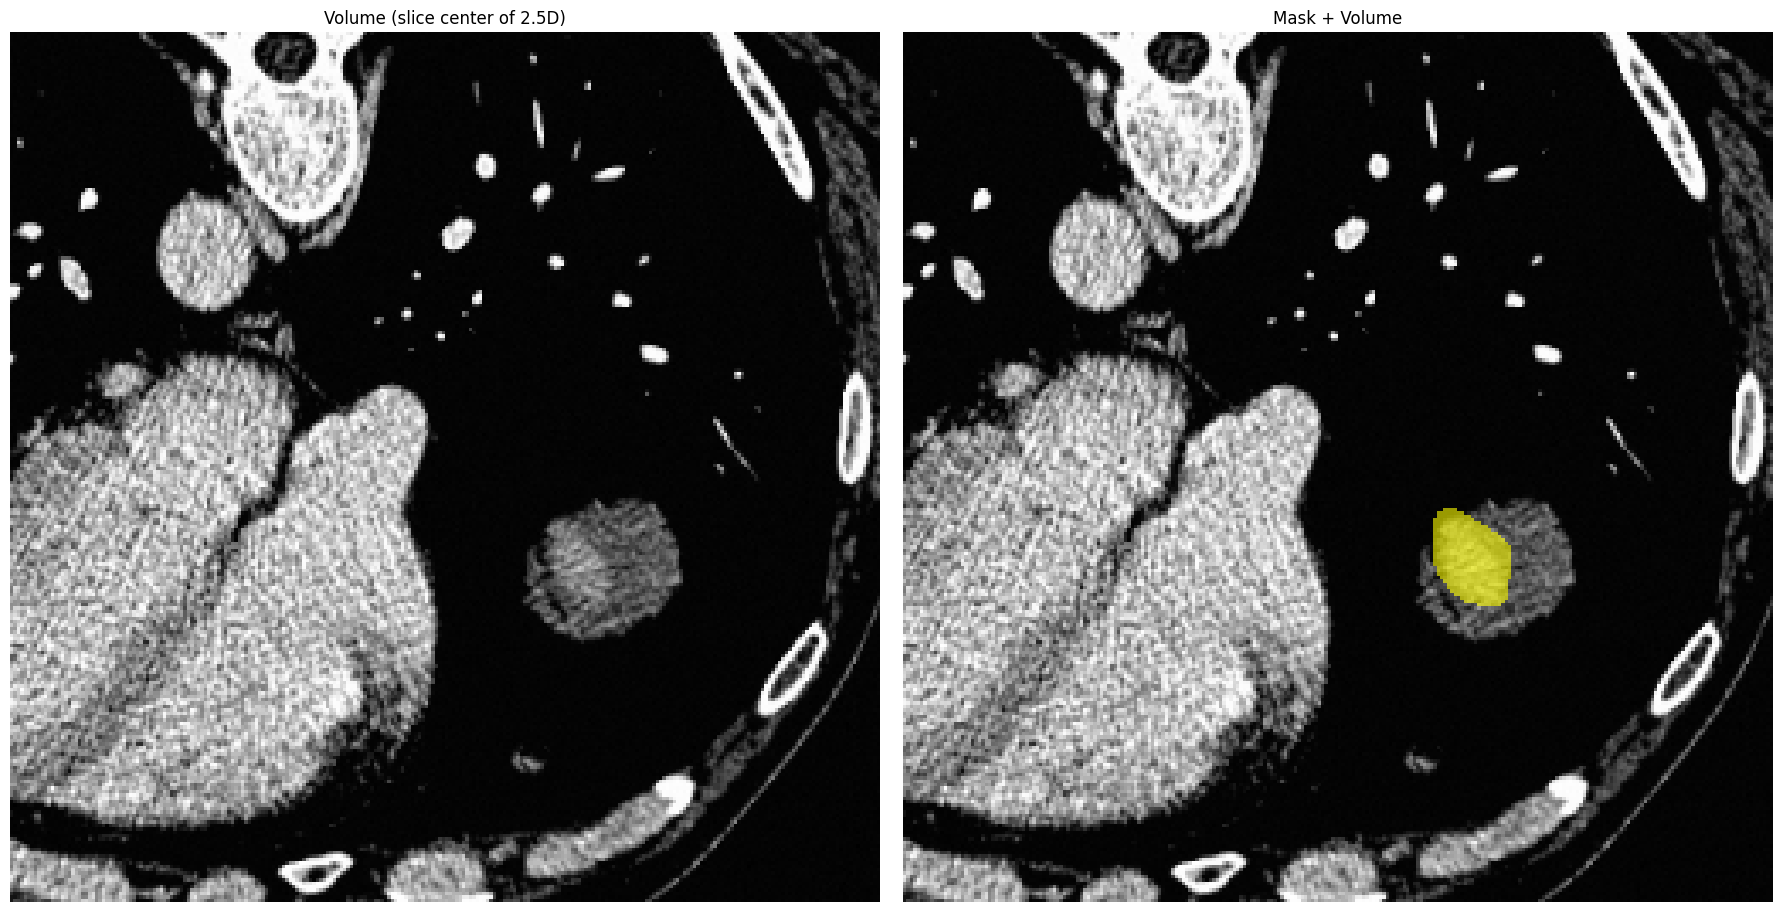

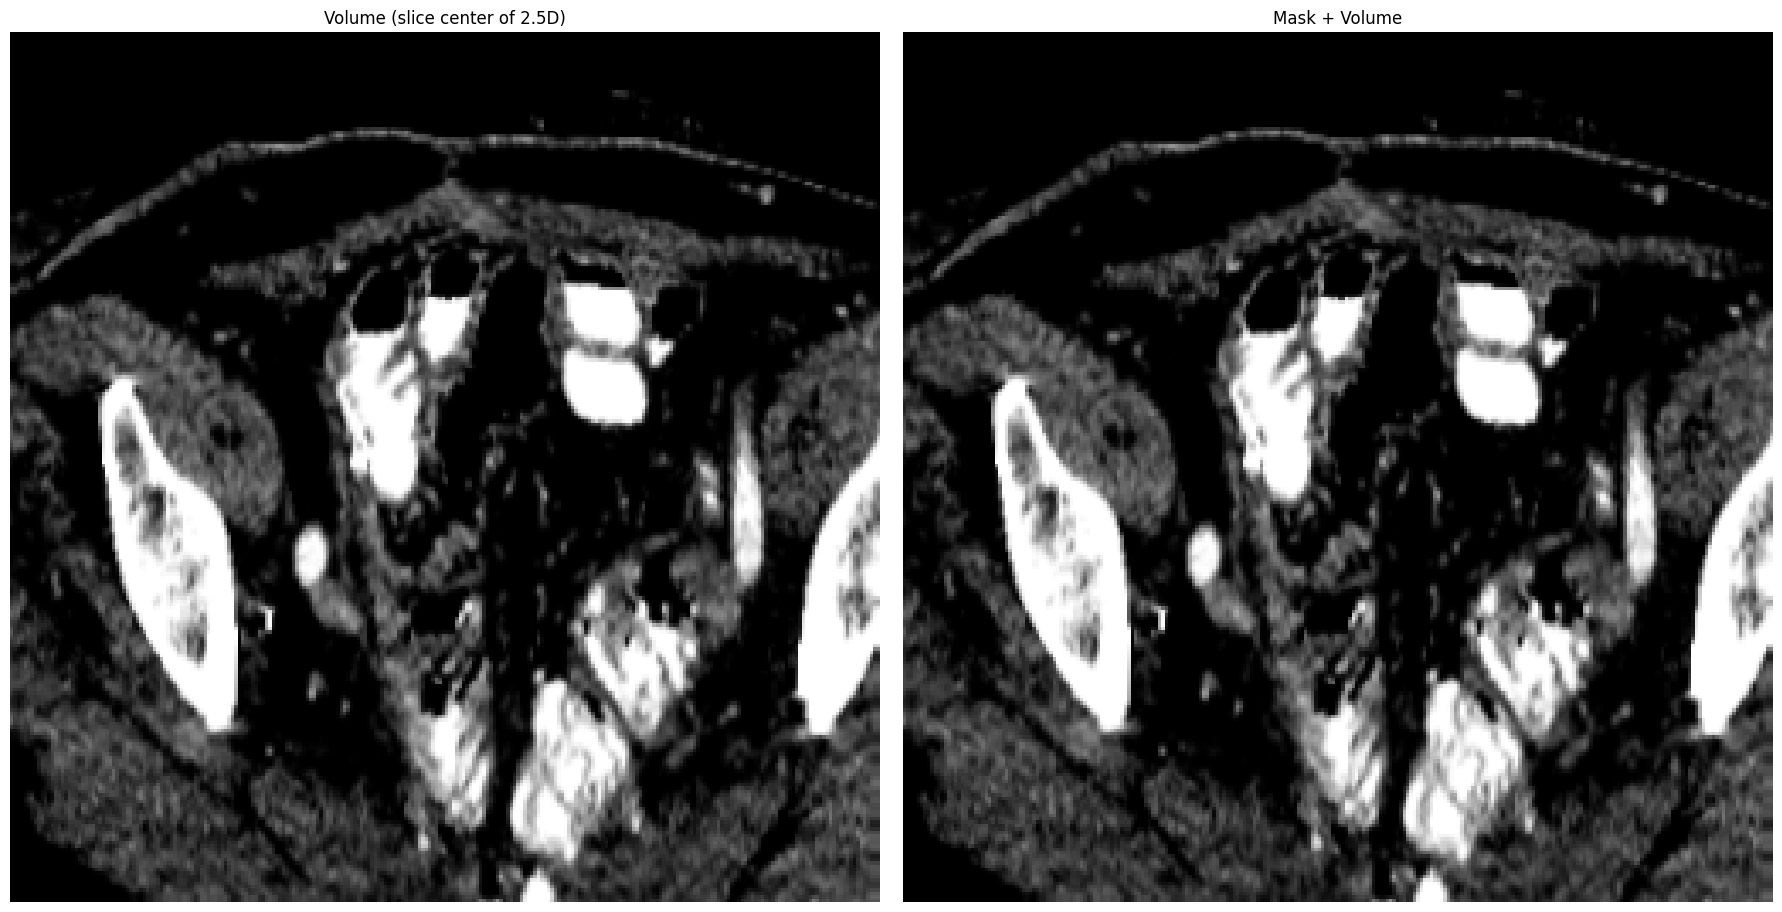

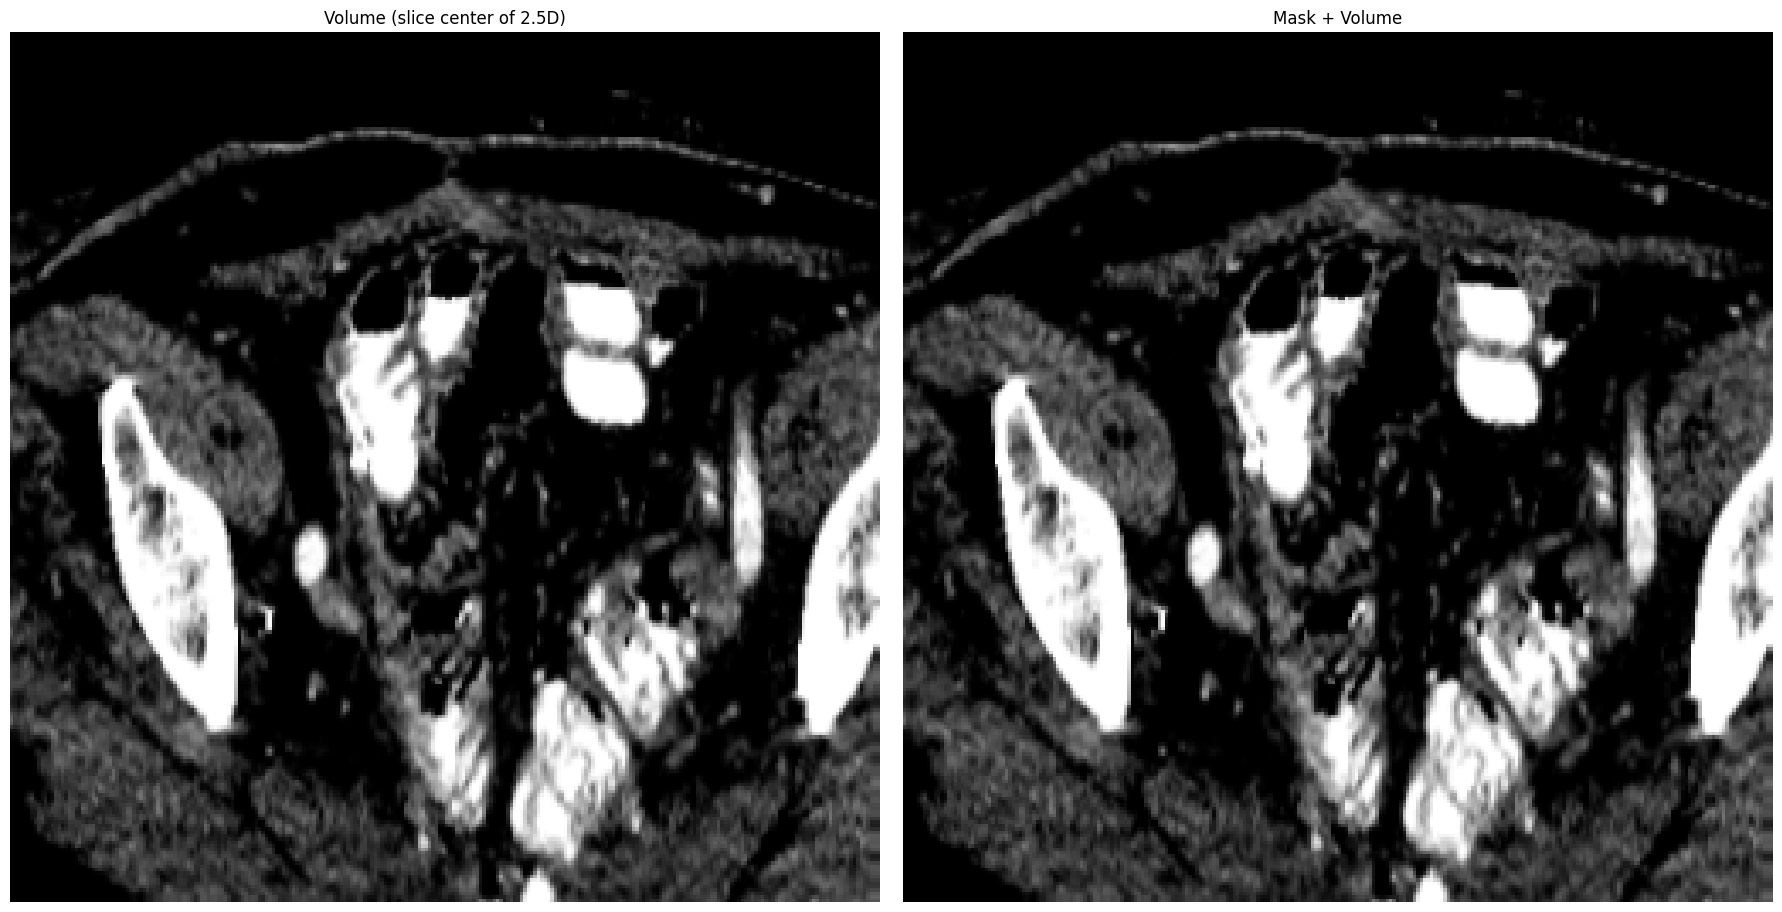

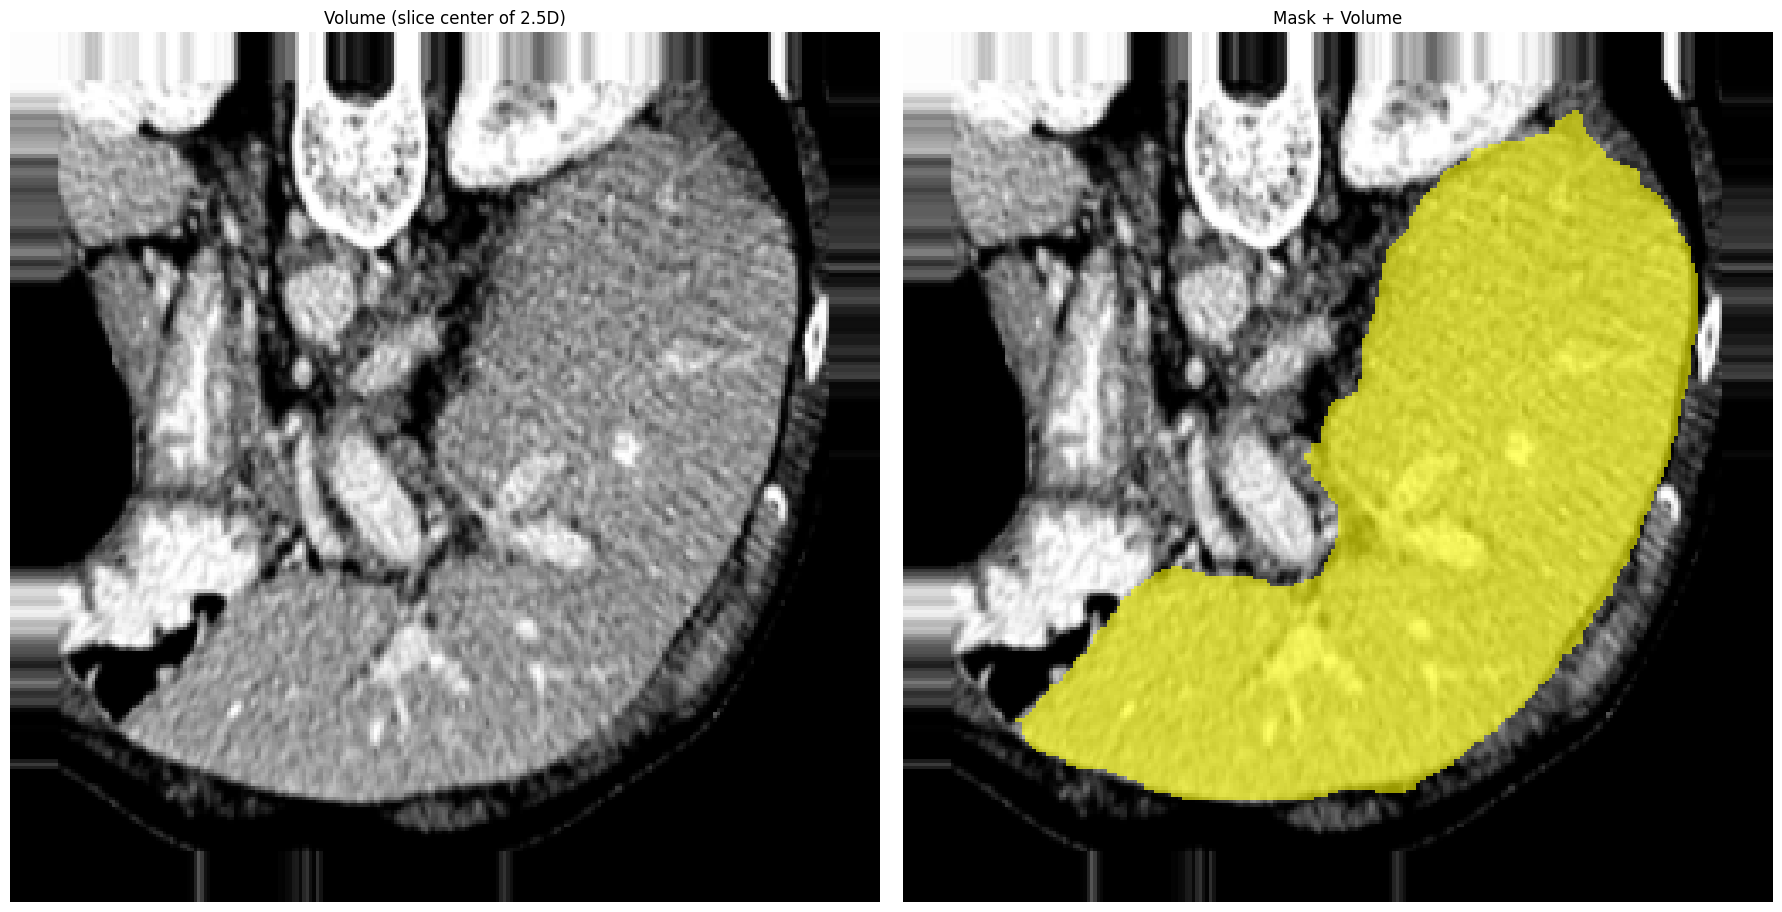

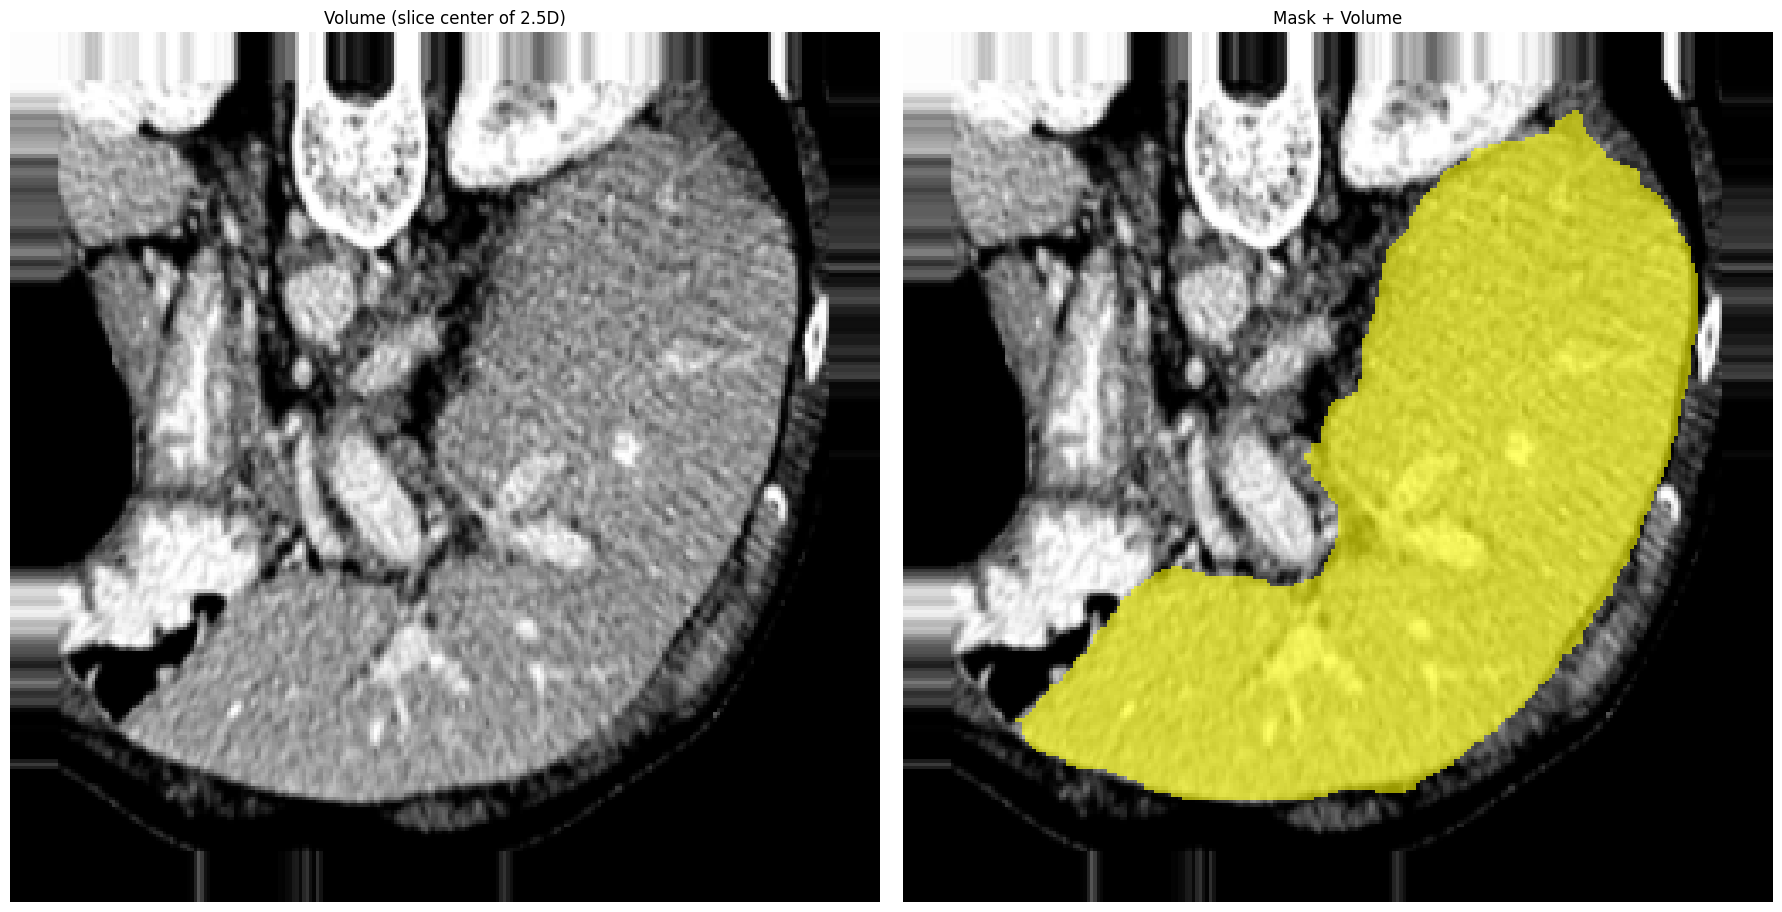

In [ ]:
i = 0
for train_data in train_loader:
    image = train_data["image"]
    label = train_data["label"]
    liver_mask = train_data["liver_mask"]
    visualize_from_loader(image, label, liver_mask)
    # i += 1
    # if i == 10:
    #   break

    if np.any(label.cpu().numpy().squeeze() > 0):
      i += 1
      visualize_from_loader(image, label, liver_mask)

      if i == 10:
        break
    else:
      continue



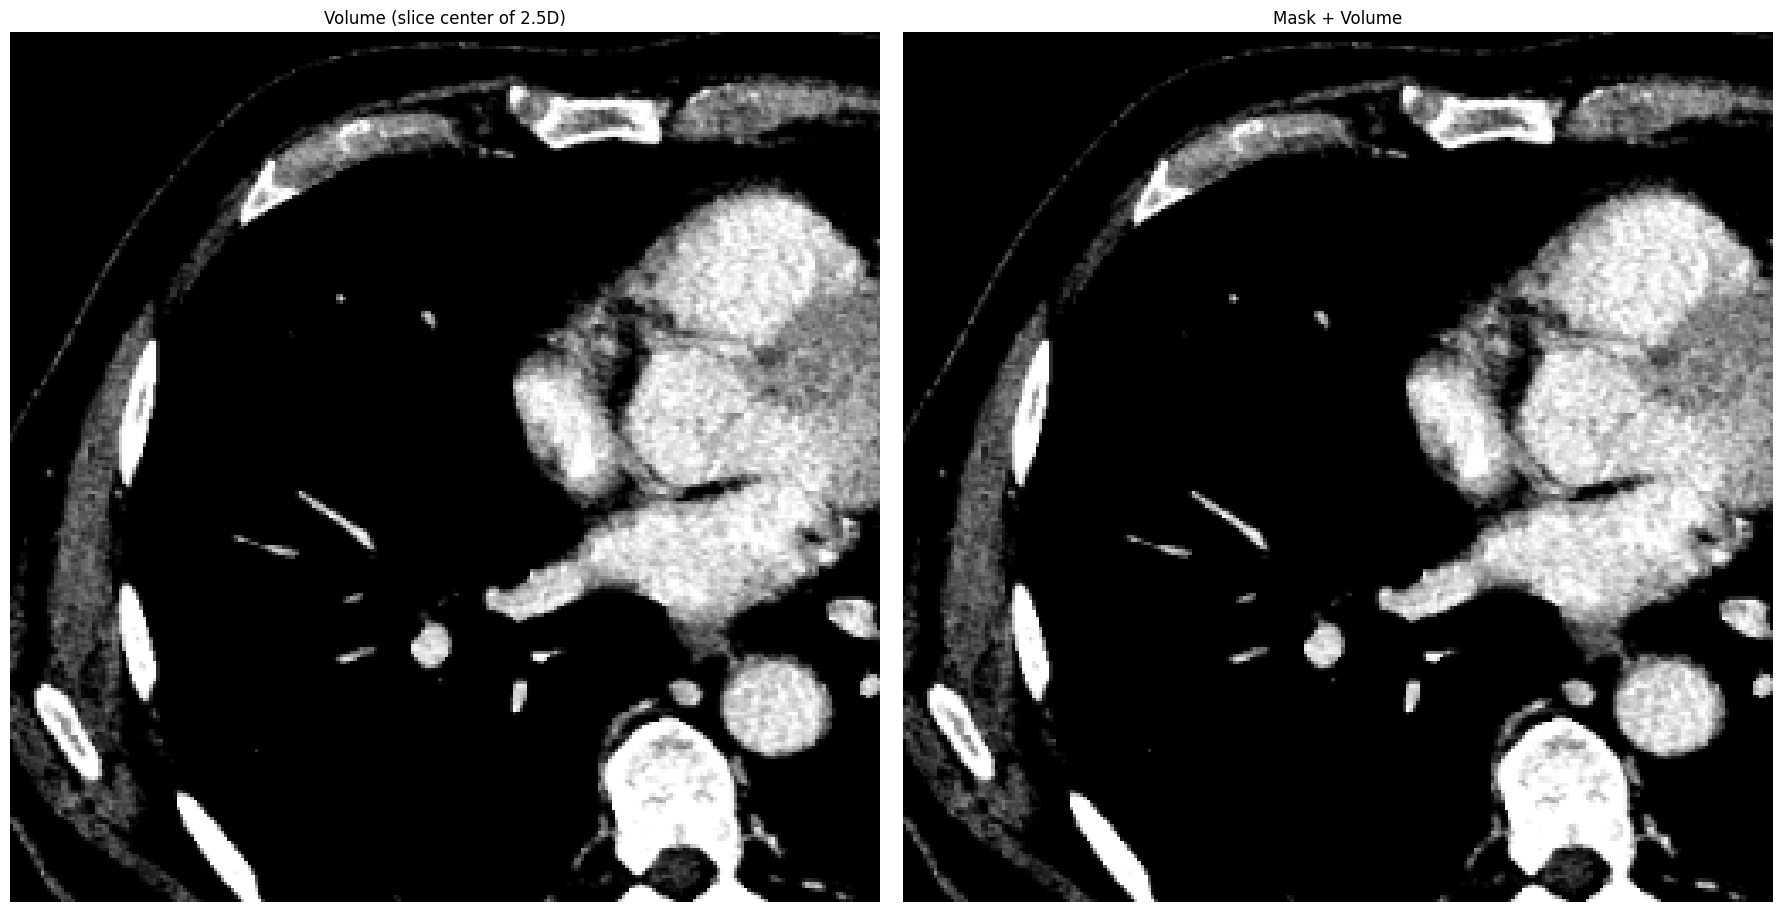

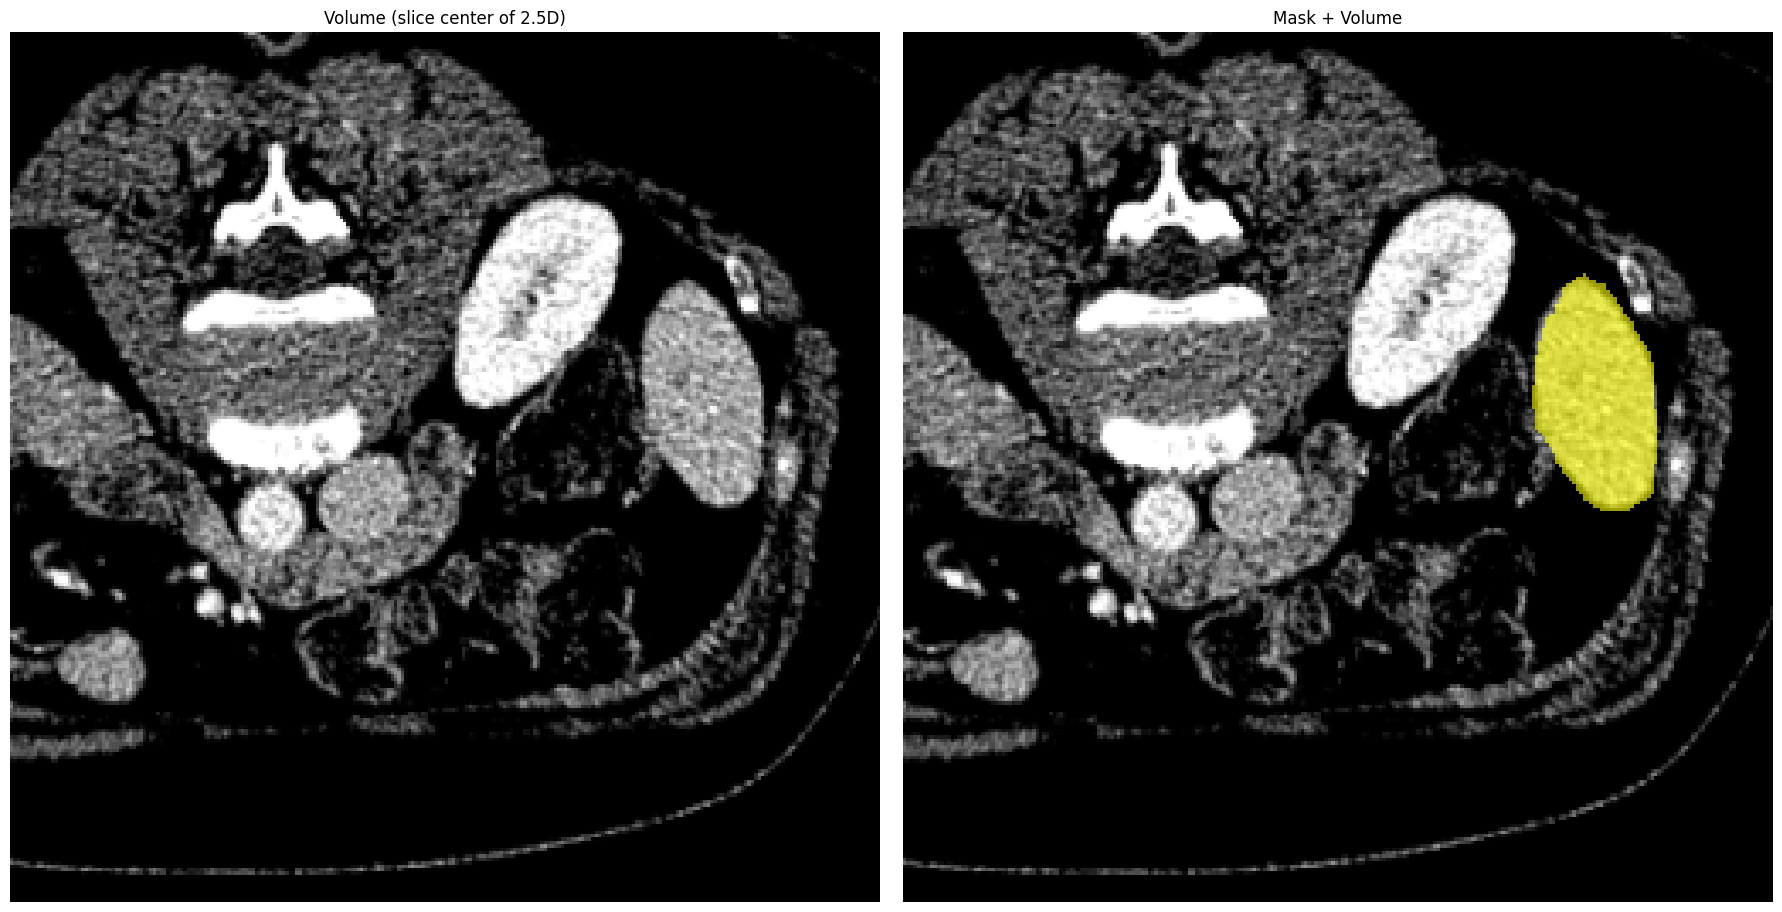

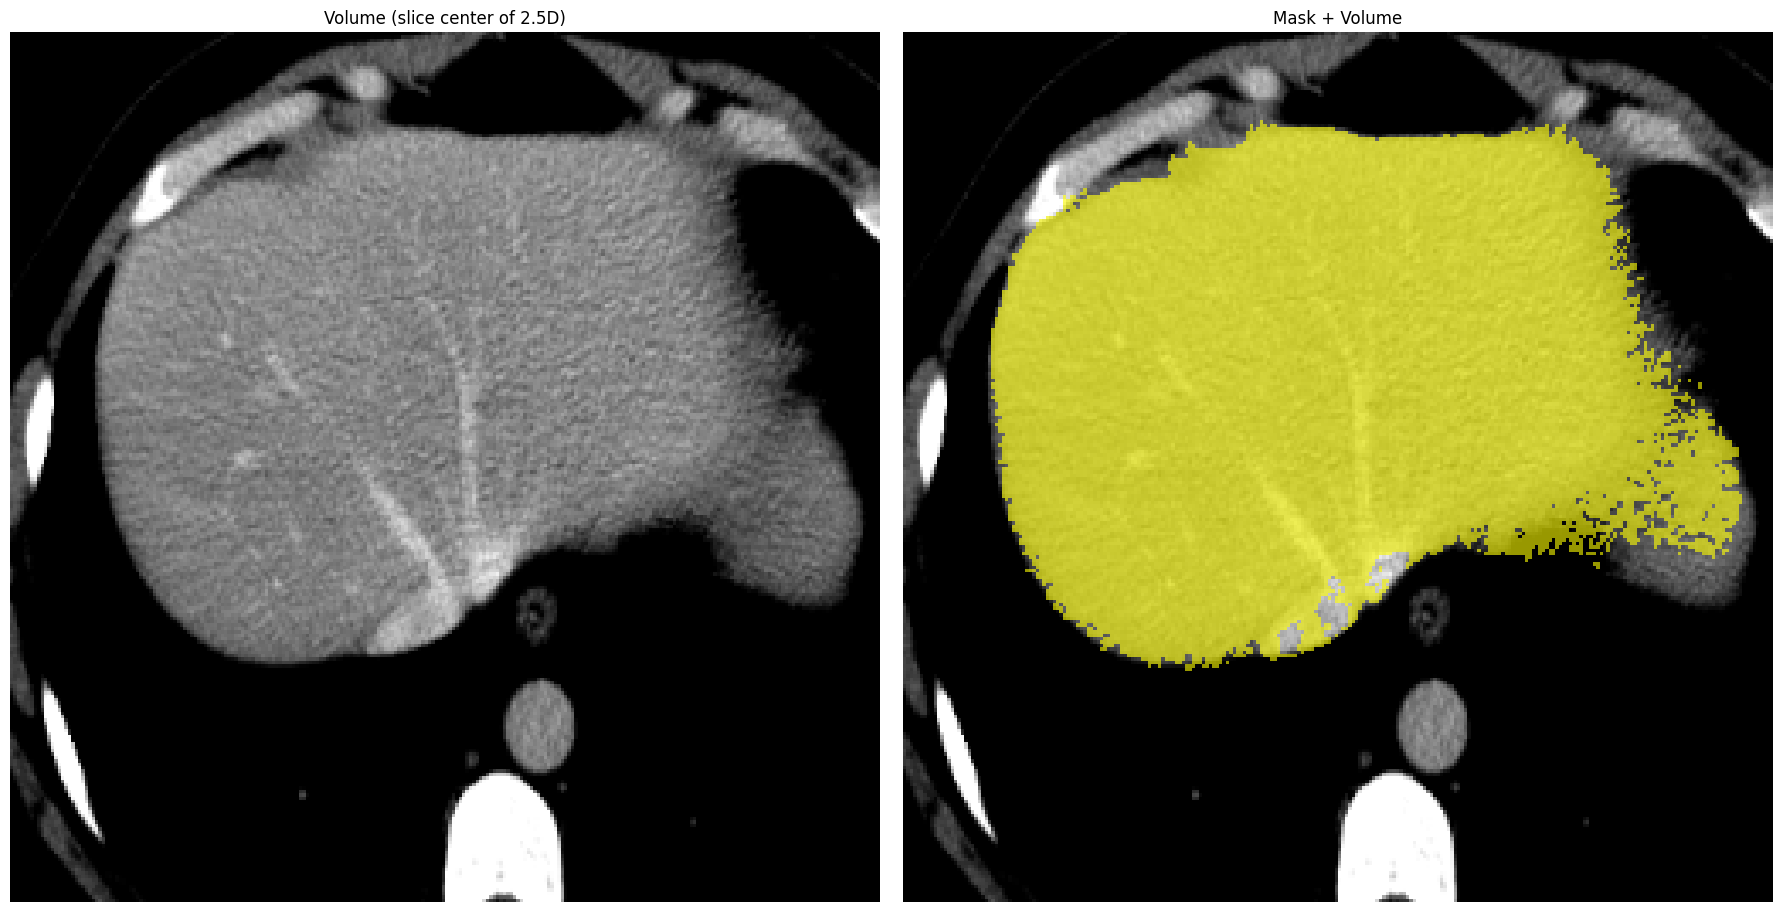

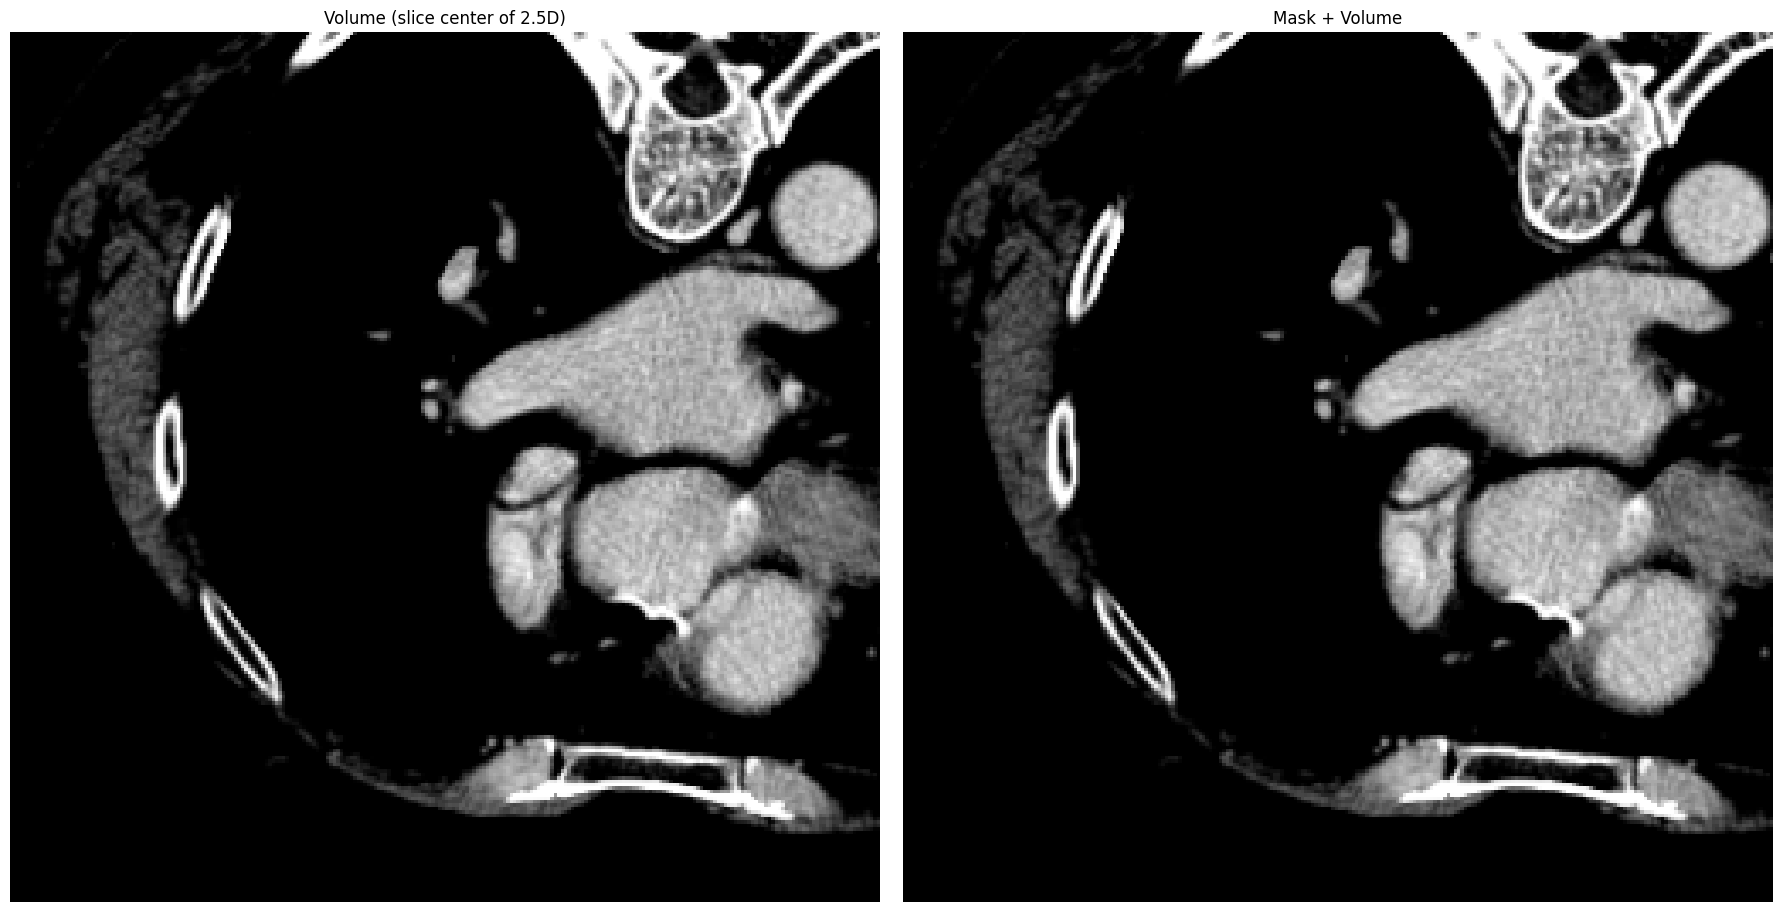

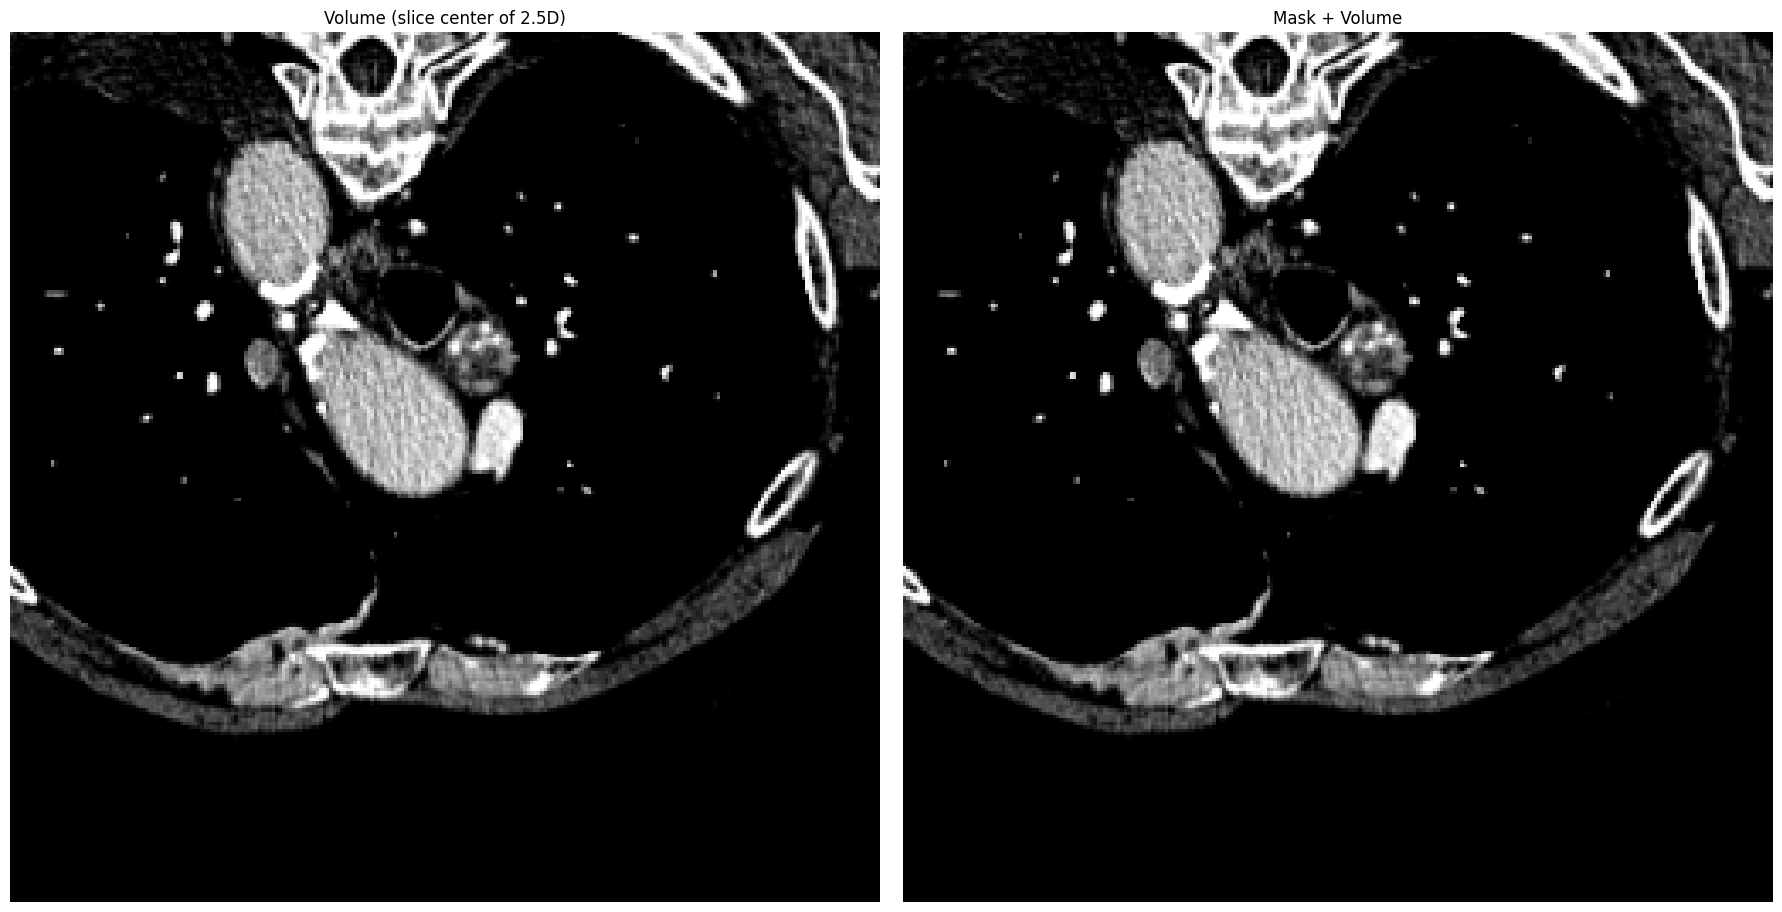

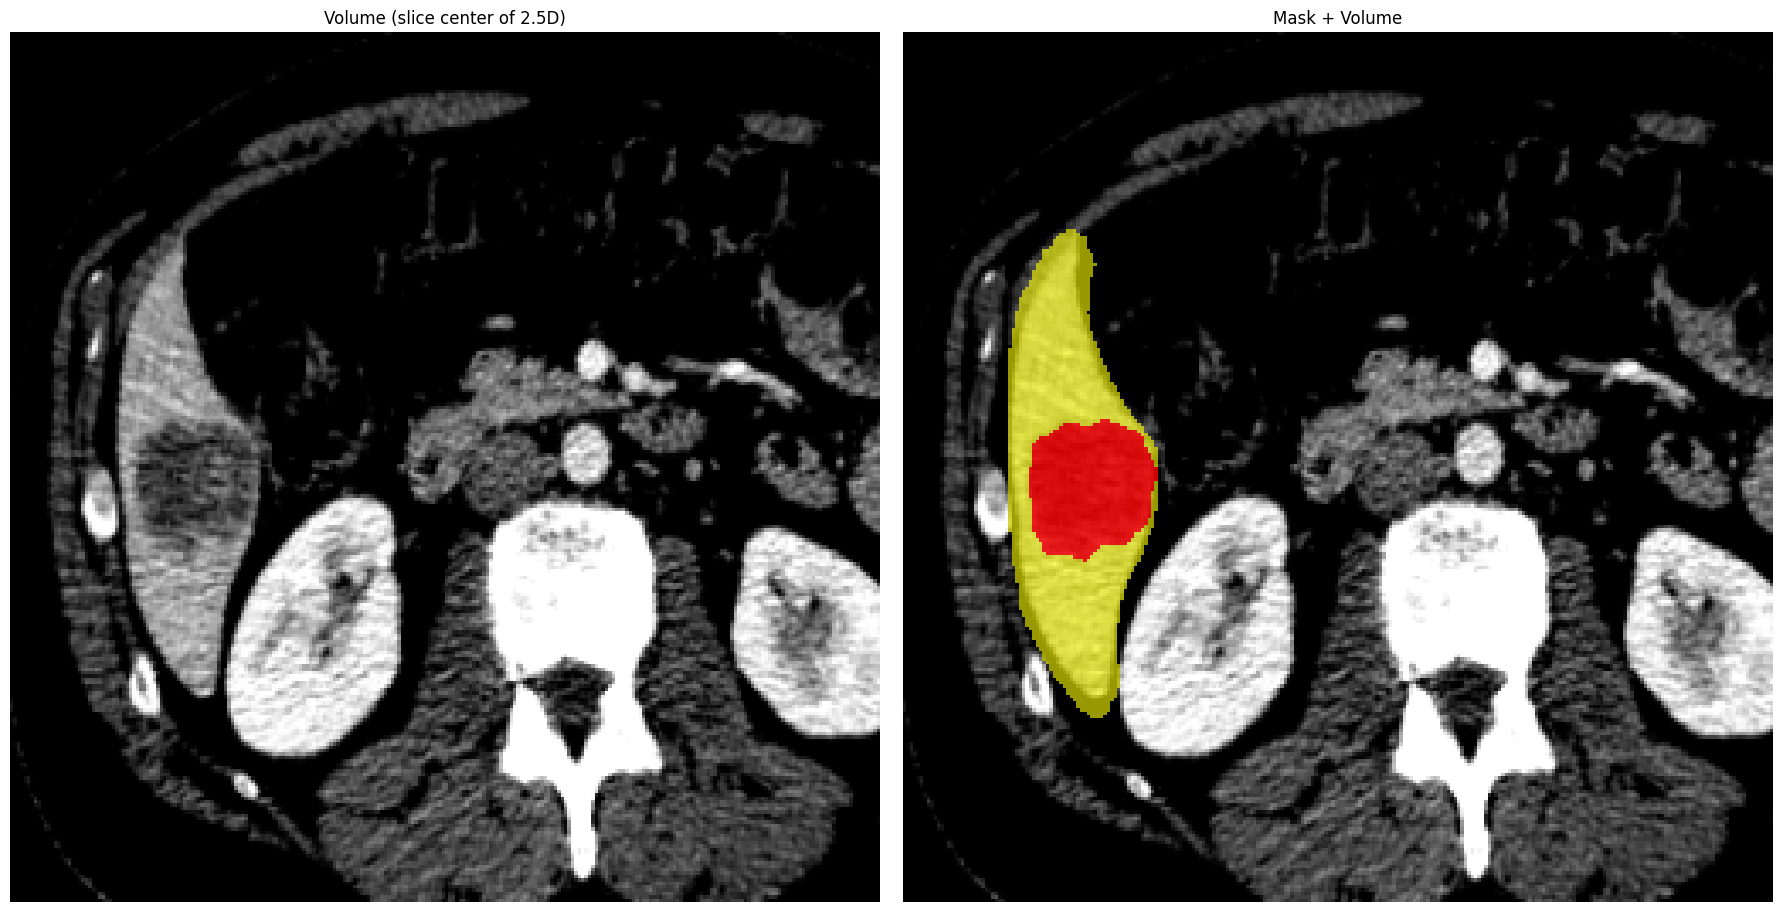

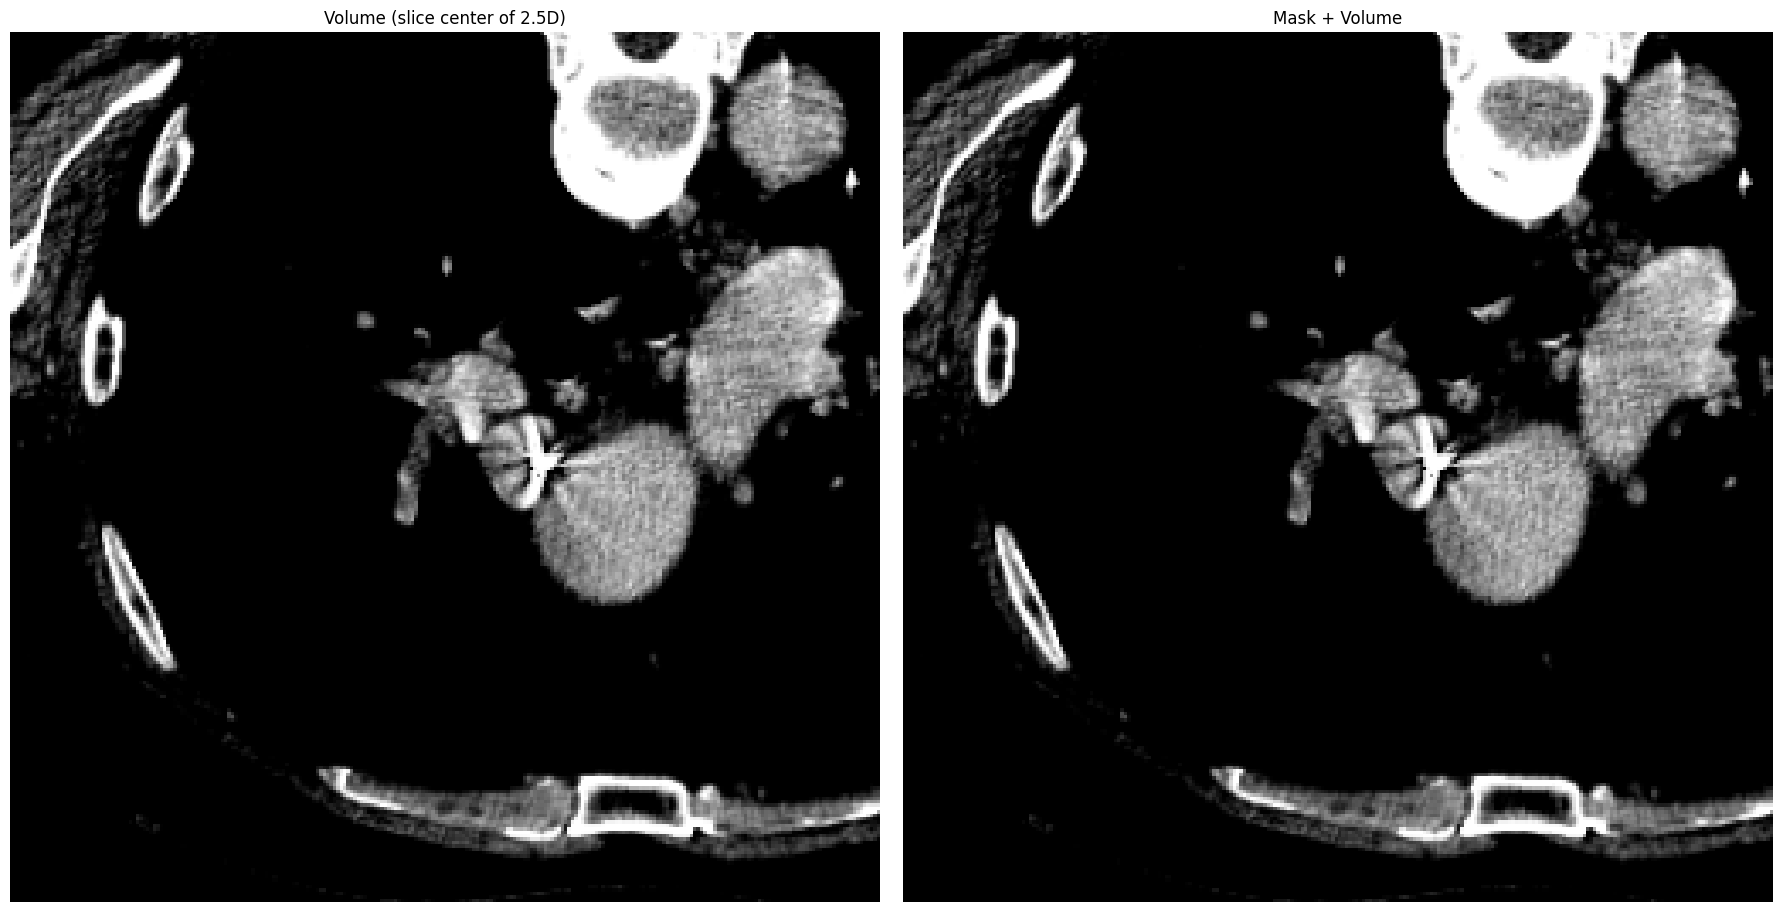

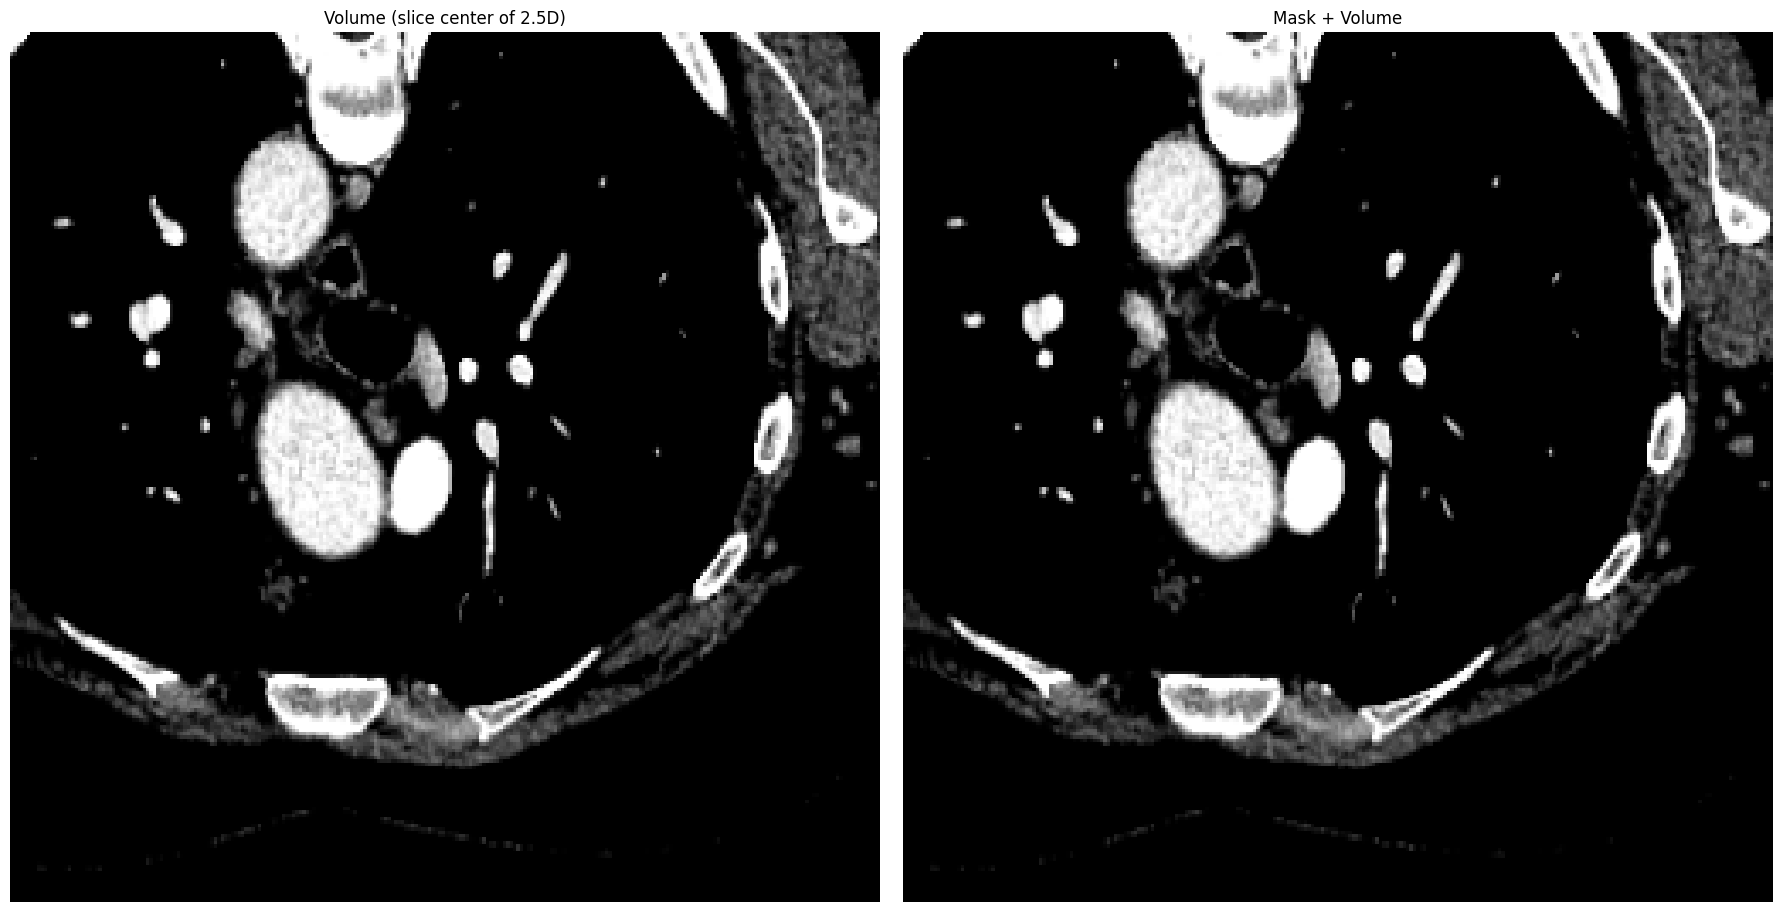

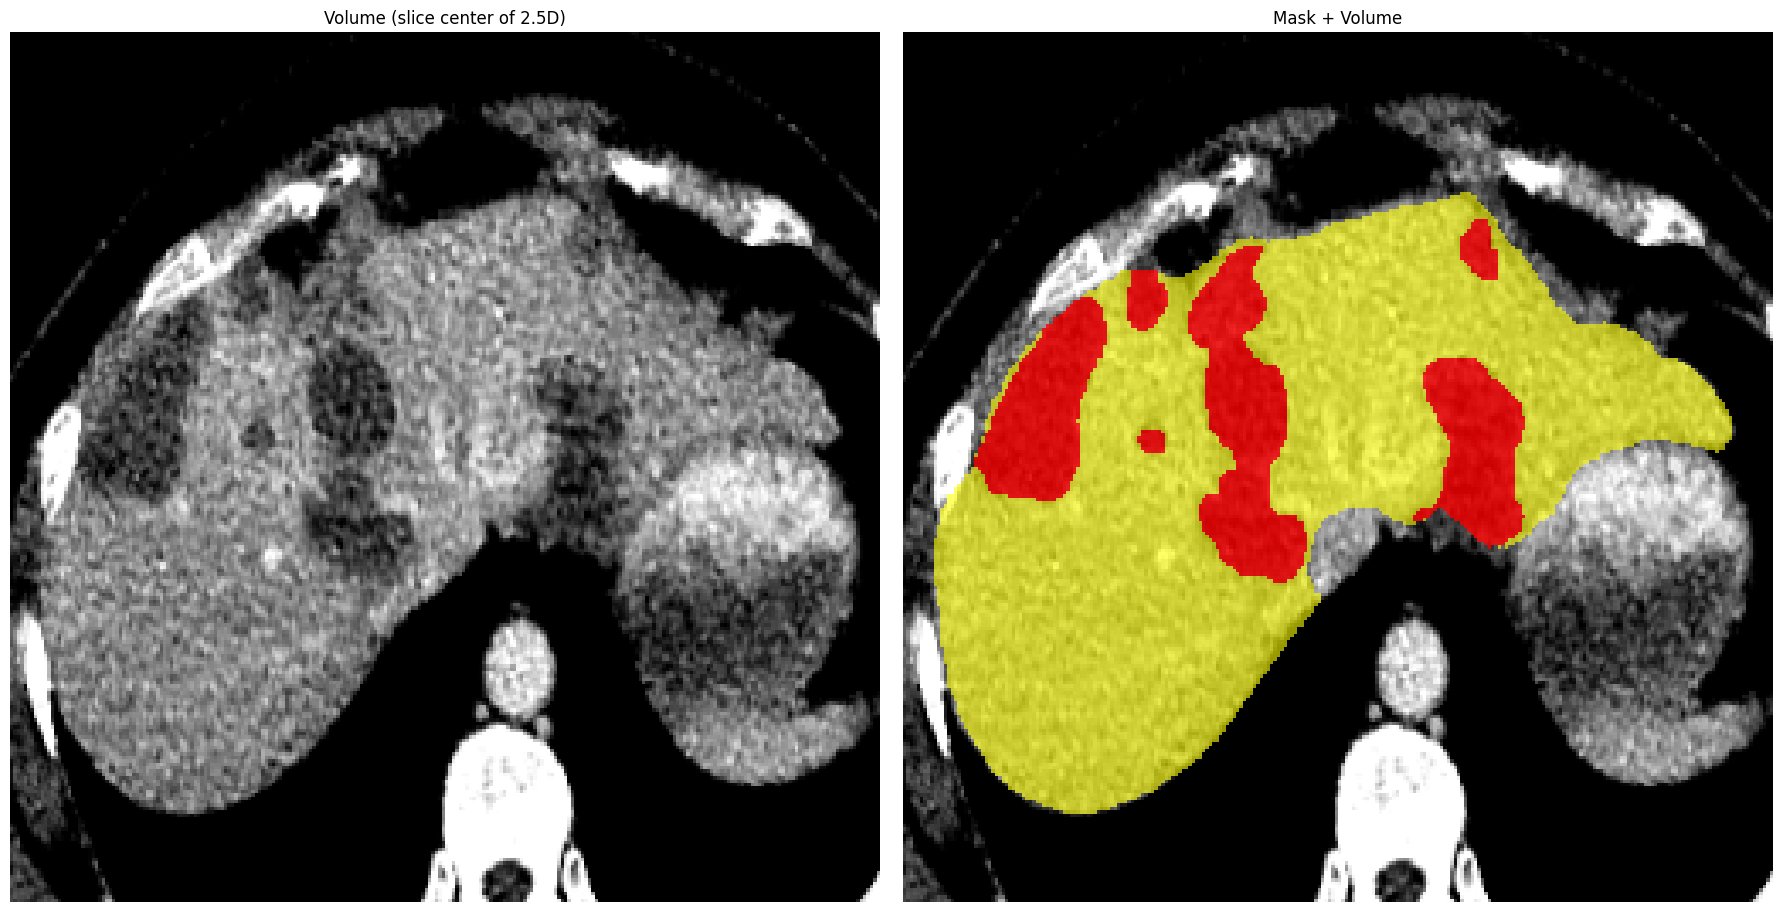

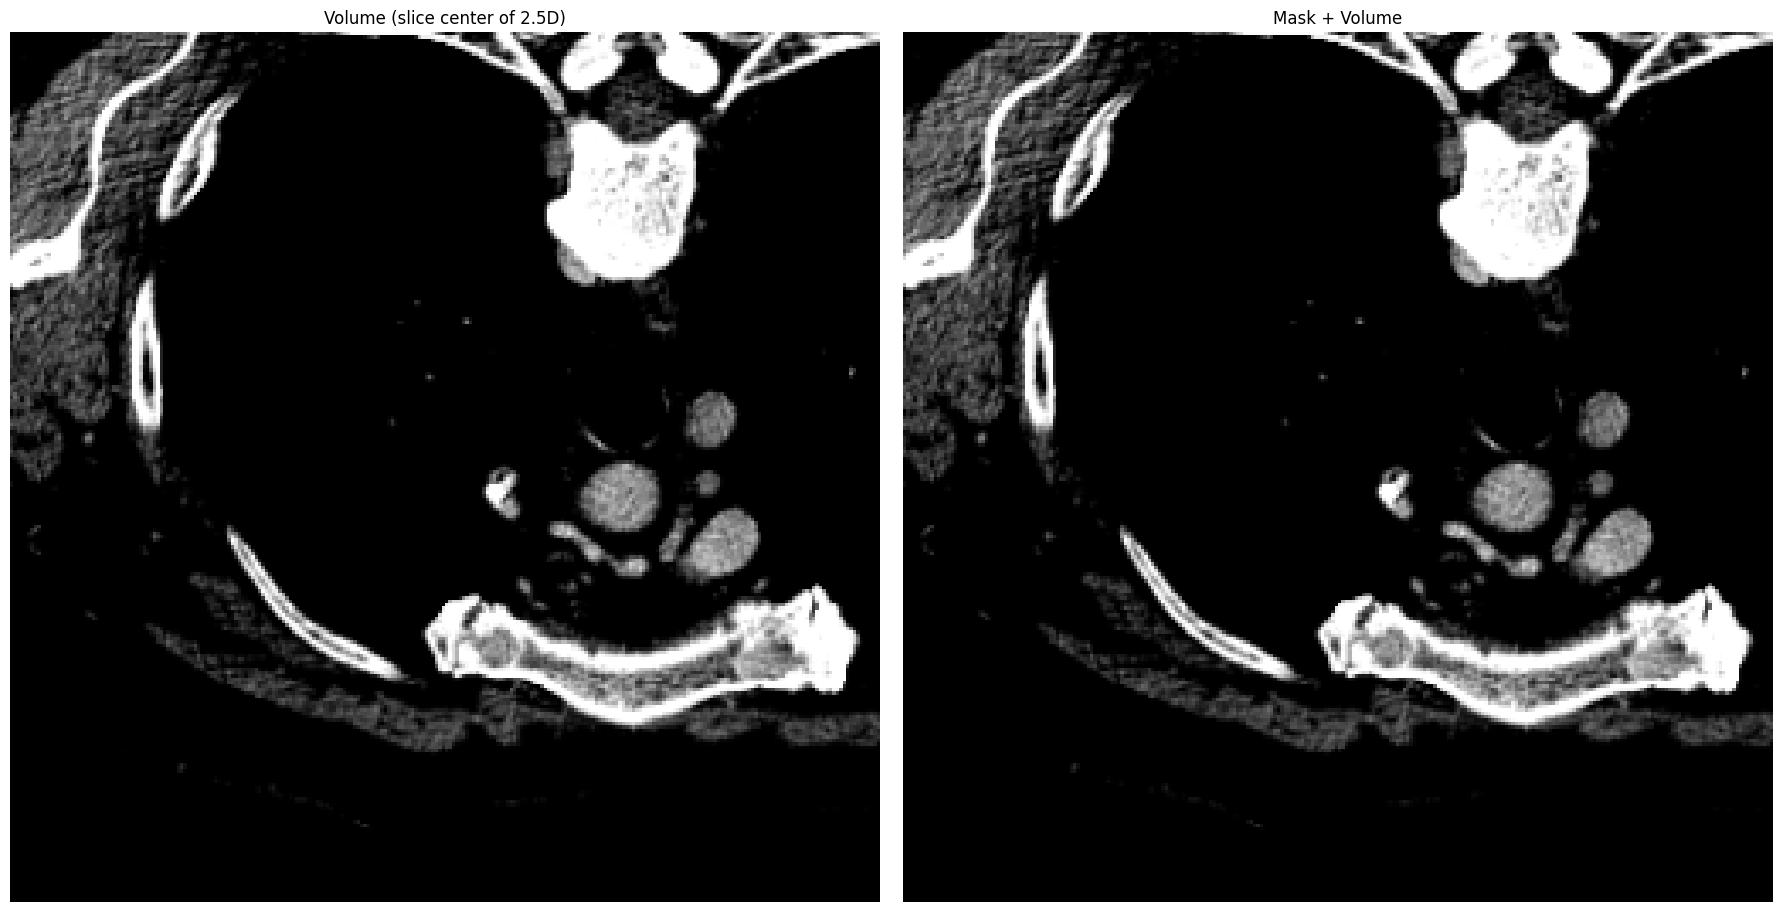

In [ ]:
i = 0
for val_data in val_loader:
    i+= 1

    image = val_data["image"]
    label = val_data["label"]
    liver_mask = val_data["liver_mask"]
    visualize_from_loader(image, label, liver_mask)

    if i == 10:
      break

## Custom train dataset

In [15]:
import random

indices_liver = []
indices_tumor = []
indices_background = []

for i in range(len(full_train_dataset)):
    sample = full_train_dataset[i]
    label = sample["label"]
    liver = sample["liver_mask"]

    if label.sum() > 0:
        indices_tumor.append(i)
    elif liver.sum() > 0:
        indices_liver.append(i)
    else:
        indices_background.append(i)
random.seed(42)
selected_background = random.sample(indices_background, k=int(len(indices_background) * 0.3))
final_indices = indices_tumor + indices_liver + selected_background

EOFError: No data left in file

In [ ]:
from torch.utils.data import Subset
balanced_dataset = Subset(full_train_dataset, final_indices)

In [ ]:
print(len(balanced_dataset))

## WeightedRandomSampler

In [ ]:
import torch
from torch.utils.data import WeightedRandomSampler

weights = []
for i in range(len(balanced_dataset)):
    sample = balanced_dataset[i]
    has_tumor = sample["label"].sum() > 0
    weights.append(5.0 if has_tumor else 1.0)

In [ ]:
sampler = WeightedRandomSampler(weights, num_samples=len(balanced_dataset), replacement=True)
train_loader = torch.utils.data.DataLoader(balanced_dataset, batch_size=16, sampler=sampler, shuffle=False, pin_memory=True, num_workers=2, drop_last=True, prefetch_factor=4)

## Training

In [ ]:
criterion = TverskyLossWSigmoid().to(device)

dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=float(config["learning_rate"]), weight_decay=float(config["weight_decay"]))
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(config["max_epochs"]), eta_min = float(config["eta_min"]))
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min= float(config["eta_min"]))


In [ ]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(
    val_acc_max,
    best_epoch,
    dices_tumor,
    loss_epochs,
    trains_epoch,
    ious_tumor,
    precisions_tumor,
    recalls_tumor,
    time_tmp
) = trainer_stage2(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=criterion,
    acc_func=dice_acc,
    scheduler=scheduler,
    batch_size=config["batch_size"],
    max_epochs = int(config["max_epochs"]) // 2,
    start_epoch = config["start_epoch"],
    val_every=config["val_every"],
    path_save_model=config["path_save_model_state"],
    logger=LOGGER,
    save_model=True,
    post_fix="tumor_2d_1"
    warm_restart=True
)

In [ ]:
import json
path_save_result = f"/content/gdrive/MyDrive/KLTN/code/result_model_{model.__class__.__name__}_tumor_2d_1.json"

results = {
    "dice_tumor": [float(x) for x in np.array(dices_tumor, dtype=np.float32)],
    "loss": [float(x) for x in np.array(loss_epochs, dtype= np.float32)],
    "iou_tumor": [float(x) for x in np.array(ious_tumor, dtype=np.float32)],
    "precision_tumor": [float(x) for x in np.array(precisions_tumor, dtype=np.float32)],
    "recall_tumor": [float(x) for x in np.array(recalls_tumor, dtype=np.float32)],
    "best_epoch": best_epoch,
    "time_train": time_tmp
}
with open(path_save_result, "w") as f:
    json.dump(results, f, indent=4)

## Visualize result

In [ ]:
import glob
print(glob.glob(f"{config['path_save_model_state']}/best_metric_model*"))

In [ ]:
num_images = len(val_loader)
weight_path = "/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_tumor_2d.pth"
visualize_results_stage_2(model, val_loader, weight_path, num_images, device)

## Result Metrics

In [ ]:
def load_metrics(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

In [ ]:
import glob
print(glob.glob("/content/gdrive/MyDrive/KLTN/code/result_model_*_2d.json"))

['/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor_2d.json']


## Result

In [ ]:
model_result = load_metrics("/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor_2d.json")

max dice score: 0.672622
loss: 0.4171
epoch: 32


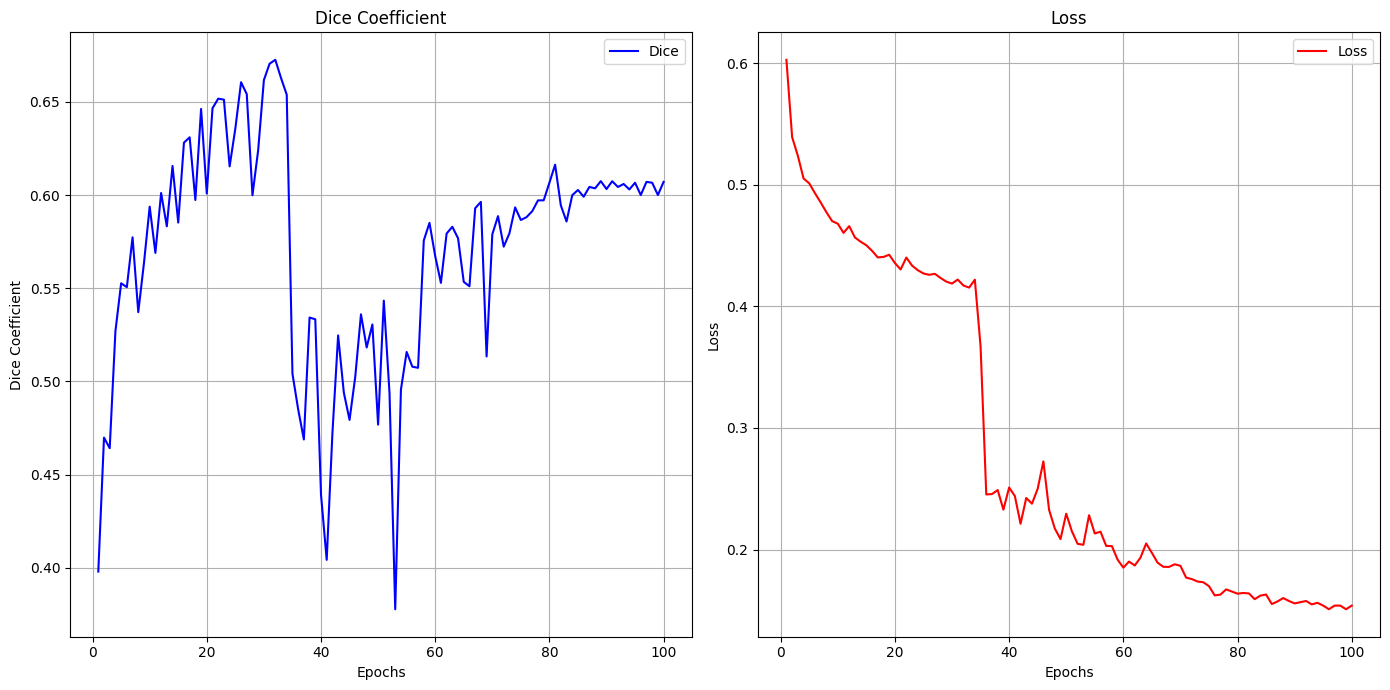

In [ ]:
epochs = np.arange(1, len(model_result["dice_tumor"]) + 1)
plt.figure(figsize=(14, 7))
print(f"max dice score: {model_result['dice_tumor'][model_result['best_epoch'] - 1]}")
print(f"loss: {model_result['loss'][model_result['best_epoch'] - 1]}")
print(f"epoch: {model_result['best_epoch']}")

# dice
plt.subplot(1, 2, 1)
plt.plot(epochs, model_result["dice_tumor"], label="Dice", color='blue')
plt.title("Dice Coefficient")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend()
plt.grid()

# loss
plt.subplot(1, 2, 2)
plt.plot(epochs, model_result["loss"], label="Loss", color='red')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()